In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgbm
from sklearn.metrics import *
import math
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
import sklearn.metrics
import math
from pathlib import Path
from warnings import filterwarnings
filterwarnings('ignore')

/home/arma/miniforge3/envs/teachopencadd/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Set path to this notebook
HERE = Path(_dh[-1])
#inputFile = Path(HERE).resolve().parents[0] /"Selectivity/input"
HDAC6 = Path(HERE).resolve().parents[0] / "BioactivityModels/HDAC6"
HDAC1 = Path(HERE).resolve().parents[0] / "BioactivityModels/HDAC1"
HDAC1and6 = Path(HERE).resolve().parents[0] / "SelectivityModels"

In [3]:
hdac1and6 = pd.read_pickle(HDAC1and6/"input/HDAC1and6_SemiSel_1024B.csv")
#hdac1and6.rename({"selectivityIndex": "SelectivityWindow"}, axis=1, inplace=True)
hdac1and6.reset_index(inplace=True)
hdac1and6.drop('index', axis=1, inplace=True)
hdac1and6_labeled = pd.read_csv(HDAC1and6/"input/HDAC1and6_SemiSel_dataset.csv",)
hdac1and6_labeled = hdac1and6_labeled[['molecule_chembl_id','pChEMBL_HDAC1', 'pChEMBL_HDAC6', 'label' ]]
hdac1and6 = pd.merge(hdac1and6, hdac1and6_labeled, on="molecule_chembl_id",)
hdac1and6

,molecule_chembl_id,fp_MACCS,fp_Morgan3,fp_MorganF,fp_MAP4,SelectivityWindow,pChEMBL_HDAC1,pChEMBL_HDAC6,label
0,CHEMBL4098975,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, ...","[2770663, 83582, 137380, 5467685, 28861, 20399...",2.89,6.96,9.85,HDAC6-selective
1,CHEMBL3912061,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[5976924, 3913535, 4142580, 576166, 5215404, 6...",3.56,6.21,9.77,HDAC6-selective
2,CHEMBL4243347,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, ...","[6411541, 3821889, 137380, 4236434, 7332227, 2...",1.00,8.70,9.70,Dual-binder
3,CHEMBL4247128,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, ...","[3808044, 3821889, 137380, 2385390, 6940687, 2...",2.52,7.08,9.60,HDAC6-selective
4,CHEMBL4126811,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[4928228, 22758228, 8033062, 10725227, 1087409...",3.12,6.36,9.48,HDAC6-selective
...,...,...,...,...,...,...,...,...,...
1905,CHEMBL4167599,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[3711565, 16948577, 1025304, 2017438, 1592299,...",1.91,5.39,7.30,Semi-selective
1906,CHEMBL4282471,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, ...","[13333824, 941437, 137380, 3205036, 930906, 69...",1.46,5.47,6.93,Semi-selective
1907,CHEMBL470843,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...","[6670835, 11359116, 7998790, 30395991, 1422832...",1.56,5.20,6.76,Semi-selective
1908,CHEMBL3215861,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...","[12352886, 3035081, 6095547, 12235944, 1201851...",-0.94,7.55,6.61,Dual-binder


In [4]:
extSet = pd.read_pickle("input/HDAC1and6_external_420Mols_1024B.csv")
extSet.reset_index(inplace=True)
extSet.drop('index', axis=1, inplace=True)
extSet_labeled = pd.read_csv("input/HDAC1and6_external_420Mols.csv", )
extSet = pd.merge(extSet, extSet_labeled[['molecule_chembl_id','pChEMBL_HDAC1', 'pChEMBL_HDAC6',
                                                   'label'  ]], on="molecule_chembl_id",)
#extSet.rename(columns={'pChEMBL_value_HDAC1': 'pChEMBL_HDAC1', 'pChEMBL_value_HDAC6': 'pChEMBL_HDAC6'},inplace=True)
extSet

,molecule_chembl_id,fp_MACCS,fp_Morgan3,fp_MorganF,fp_MAP4,SelectivityWindow,pChEMBL_HDAC1,pChEMBL_HDAC6,label
0,CHEMBL4442817,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, ...","[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, ...","[727366, 2349897, 137380, 18248611, 6944096, 4...",0.7754,6.508638,7.283997,Semi-selective
1,CHEMBL4455447,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, ...","[1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, ...","[6411541, 2349897, 137380, 18248611, 7332227, ...",0.2951,7.136677,7.431798,Dual-binder
2,CHEMBL4463358,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, ...","[1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, ...","[727366, 2349897, 137380, 18248611, 135217, 29...",0.7392,6.716699,7.455932,Dual-binder
3,CHEMBL4463948,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, ...","[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, ...","[6411541, 2349897, 137380, 14079558, 7332227, ...",0.7707,6.638272,7.408935,Dual-binder
4,CHEMBL4465542,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, ...","[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, ...","[727366, 2349897, 137380, 12231903, 7332227, 4...",0.7379,6.047208,6.785156,Semi-selective
...,...,...,...,...,...,...,...,...,...
415,CHEMBL5220434,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...","[3643172, 3593585, 2980590, 6979644, 3194622, ...",0.8300,7.060000,7.890000,Dual-binder
416,CHEMBL5220776,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...","[7229253, 3913535, 8033062, 8233429, 4256652, ...",0.6500,6.700000,7.350000,Dual-binder
417,CHEMBL5220934,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...","[5976924, 3913535, 781637, 963745, 3421313, 14...",1.1100,6.440000,7.550000,Semi-selective
418,CHEMBL5221043,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...","[6872051, 4617681, 20142422, 7125875, 6611002,...",-0.1500,7.070000,6.920000,Dual-binder


## HDAC1 Regression Models

In [5]:
# Add a column for activity against HDAC6

extSet["HDAC1activity"] = np.zeros(len(extSet))

# Mark every molecule as active with an pIC50 of >= 6.3, 0 otherwise
extSet.loc[extSet[extSet.pChEMBL_HDAC1 >= 6.6].index, "HDAC1activity"] = 1.0

# NBVAL_CHECK_OUTPUT
print("Number of active compounds:", int(extSet.HDAC1activity.sum()))
print("Number of inactive compounds:", len(extSet) - int(extSet.HDAC1activity.sum()))

Number of active compounds: 209
Number of inactive compounds: 211


In [6]:
#By using Morgan fingerprints with radius of 3 and 1025 bits
X_allDouble_hdac1 = np.array(list((hdac1and6['fp_Morgan3']))).astype(float)
#X.shape
y_allDouble_hdac1 = hdac1and6["pChEMBL_HDAC1"].values
y_allDouble_hdac1_cat = np.where(y_allDouble_hdac1 >= 6.6, 1, 0)

In [7]:
#By using Morgan fingerprints with radius of 3 and 1025 bits
X_hdac1_reg = np.array(list((extSet['fp_Morgan3']))).astype(float)
#X.shape
y_hdac1_reg = extSet["pChEMBL_HDAC1"].values
y_hdac1_reg_cat = extSet["HDAC1activity"].values
len(X_hdac1_reg), len(y_hdac1_reg), len(y_hdac1_reg_cat)

(420, 420, 420)

In [8]:
#regression models
import joblib
optimizedCV_reg_rf_hdac1 =  joblib.load(HDAC1/"models/Numeric/OUTPUT/optimizedCV_rf.joblib")
optimizedCV_reg_rf_hdac1.fit(X_allDouble_hdac1, y_allDouble_hdac1)
pred_reg_rf_hdac1 = optimizedCV_reg_rf_hdac1.predict(X_hdac1_reg)
r2_scores_rf_hdac1 = r2_score(y_hdac1_reg, pred_reg_rf_hdac1)
# now convert the resuls to binary with cutoff 6.6
 
pred_reg_rf_hdac1_cat = np.where(pred_reg_rf_hdac1 >= 6.6, 1, 0)
conf_matrix_rf_hdac1 = confusion_matrix(y_hdac1_reg_cat, pred_reg_rf_hdac1_cat) 
TP_rf_hdac1 = conf_matrix_rf_hdac1[1][1]
TN_rf_hdac1 = conf_matrix_rf_hdac1[0][0]
FP_rf_hdac1 = conf_matrix_rf_hdac1[0][1] 
FN_rf_hdac1 = conf_matrix_rf_hdac1[1][0]
Accuracy_rf_hdac1 = accuracy_score(y_hdac1_reg_cat, pred_reg_rf_hdac1_cat)
Precision_rf_hdac1 = precision_score(y_hdac1_reg_cat, pred_reg_rf_hdac1_cat)
Sensitivity_rf_hdac1 = recall_score(y_hdac1_reg_cat, pred_reg_rf_hdac1_cat)
Specificity_rf_hdac1 = round( TN_rf_hdac1 / (TN_rf_hdac1+FP_rf_hdac1),4 )
f1_scores_rf_hdac1 = f1_score(y_hdac1_reg_cat, pred_reg_rf_hdac1_cat)
f1_scores_W_rf_hdac1 = f1_score(y_hdac1_reg_cat, pred_reg_rf_hdac1_cat, average="weighted")
f1_scores_M_rf_hdac1 = f1_score(y_hdac1_reg_cat, pred_reg_rf_hdac1_cat, average="macro")
BA_scores_rf_hdac1 = balanced_accuracy_score(y_hdac1_reg_cat, pred_reg_rf_hdac1_cat)
MCC_rf_hdac1= matthews_corrcoef(y_hdac1_reg_cat, pred_reg_rf_hdac1_cat)
NPV_rf_hdac1= round( TN_rf_hdac1 / (TN_rf_hdac1+FN_rf_hdac1),4 )
ROC_AUC_rf_hdac1 = roc_auc_score(y_hdac1_reg_cat, pred_reg_rf_hdac1_cat)

mat_met_hdac1 = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)',
                            'F1 score (macro)', 'Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'RF (average)':[np.mean(r2_scores_rf_hdac1), 
                                    np.mean(TP_rf_hdac1), np.mean(TN_rf_hdac1),
                                    np.mean(FP_rf_hdac1), np.mean(FN_rf_hdac1),
                                    np.mean(Accuracy_rf_hdac1),
                                    np.mean(Precision_rf_hdac1),
                                    np.mean(Sensitivity_rf_hdac1),
                                    np.mean(Specificity_rf_hdac1),
                                    np.mean(f1_scores_rf_hdac1),
                                    np.mean(f1_scores_W_rf_hdac1), 
                                    np.mean(f1_scores_M_rf_hdac1), 
                                    np.mean(BA_scores_rf_hdac1), 
                                    np.mean(MCC_rf_hdac1),
                                    np.mean(NPV_rf_hdac1),
                                    np.mean(ROC_AUC_rf_hdac1)],
                              
                        
                        
                       }) 
    
print(mat_met_hdac1)

                 Metric  RF (average)
0                    R2      0.232804
1                    TP    138.000000
2                    TN    169.000000
3                    FP     42.000000
4                    FN     71.000000
5              Accuracy      0.730952
6             Precision      0.766667
7           Sensitivity      0.660287
8           Specificity      0.800900
9              F1 score      0.709512
10  F1 score (weighted)      0.729574
11     F1 score (macro)      0.729479
12    Balanced Accuracy      0.730617
13                  MCC      0.466009
14                  NPV      0.704200
15              ROC_AUC      0.730617


In [9]:
#regression models

optimizedCV_reg_lgbm_hdac1 =  joblib.load(HDAC1/"models/Numeric/OUTPUT/optimizedCV_lgbm.joblib")
optimizedCV_reg_lgbm_hdac1.fit(X_allDouble_hdac1, y_allDouble_hdac1)
pred_reg_lgbm_hdac1 = optimizedCV_reg_lgbm_hdac1.predict(X_hdac1_reg)
r2_scores_lgbm_hdac1 = r2_score(y_hdac1_reg, pred_reg_lgbm_hdac1)
# now convert the resuls to binary with cutoff 6.6
 
pred_reg_lgbm_hdac1_cat = np.where(pred_reg_lgbm_hdac1 >= 6.6, 1, 0)
conf_matrix_lgbm_hdac1 = confusion_matrix(y_hdac1_reg_cat, pred_reg_lgbm_hdac1_cat) 
TP_lgbm_hdac1 = conf_matrix_lgbm_hdac1[1][1]
TN_lgbm_hdac1 = conf_matrix_lgbm_hdac1[0][0]
FP_lgbm_hdac1 = conf_matrix_lgbm_hdac1[0][1] 
FN_lgbm_hdac1 = conf_matrix_lgbm_hdac1[1][0]
Accuracy_lgbm_hdac1 = accuracy_score(y_hdac1_reg_cat, pred_reg_lgbm_hdac1_cat)
Precision_lgbm_hdac1 = precision_score(y_hdac1_reg_cat, pred_reg_lgbm_hdac1_cat)
Sensitivity_lgbm_hdac1 = recall_score(y_hdac1_reg_cat, pred_reg_lgbm_hdac1_cat)
Specificity_lgbm_hdac1 = round( TN_lgbm_hdac1 / (TN_lgbm_hdac1+FP_lgbm_hdac1),4 )
f1_scores_lgbm_hdac1 = f1_score(y_hdac1_reg_cat, pred_reg_lgbm_hdac1_cat)
f1_scores_W_lgbm_hdac1 = f1_score(y_hdac1_reg_cat, pred_reg_lgbm_hdac1_cat, average="weighted")
f1_scores_M_lgbm_hdac1 = f1_score(y_hdac1_reg_cat, pred_reg_lgbm_hdac1_cat, average="macro")
BA_scores_lgbm_hdac1 = balanced_accuracy_score(y_hdac1_reg_cat, pred_reg_lgbm_hdac1_cat)
MCC_lgbm_hdac1= matthews_corrcoef(y_hdac1_reg_cat, pred_reg_lgbm_hdac1_cat)
NPV_lgbm_hdac1= round( TN_lgbm_hdac1 / (TN_lgbm_hdac1+FN_lgbm_hdac1),4 )
ROC_AUC_lgbm_hdac1 = roc_auc_score(y_hdac1_reg_cat, pred_reg_lgbm_hdac1_cat)

lgbm_hdac1 = pd.DataFrame({  'LGBM (average)':[np.mean(r2_scores_lgbm_hdac1), 
                                    np.mean(TP_lgbm_hdac1), np.mean(TN_lgbm_hdac1),
                                    np.mean(FP_lgbm_hdac1), np.mean(FN_lgbm_hdac1),
                                    np.mean(Accuracy_lgbm_hdac1),
                                    np.mean(Precision_lgbm_hdac1),
                                    np.mean(Sensitivity_lgbm_hdac1),
                                    np.mean(Specificity_lgbm_hdac1),
                                    np.mean(f1_scores_lgbm_hdac1),
                                    np.mean(f1_scores_W_lgbm_hdac1), 
                                    np.mean(f1_scores_M_lgbm_hdac1), 
                                    np.mean(BA_scores_lgbm_hdac1), 
                                    np.mean(MCC_lgbm_hdac1),
                                    np.mean(NPV_lgbm_hdac1),
                                    np.mean(ROC_AUC_lgbm_hdac1)],
                 }) 

mat_met_hdac1['LGBM'] = lgbm_hdac1   
print(mat_met_hdac1)

                 Metric  RF (average)        LGBM
0                    R2      0.232804    0.233740
1                    TP    138.000000  153.000000
2                    TN    169.000000  164.000000
3                    FP     42.000000   47.000000
4                    FN     71.000000   56.000000
5              Accuracy      0.730952    0.754762
6             Precision      0.766667    0.765000
7           Sensitivity      0.660287    0.732057
8           Specificity      0.800900    0.777300
9              F1 score      0.709512    0.748166
10  F1 score (weighted)      0.729574    0.754624
11     F1 score (macro)      0.729479    0.754594
12    Balanced Accuracy      0.730617    0.754654
13                  MCC      0.466009    0.509881
14                  NPV      0.704200    0.745500
15              ROC_AUC      0.730617    0.754654


In [10]:
#regression models

optimizedCV_reg_xgb_hdac1 =  joblib.load(HDAC1/"models/Numeric/OUTPUT/optimizedCV_xgb.joblib")
optimizedCV_reg_xgb_hdac1.fit(X_allDouble_hdac1, y_allDouble_hdac1)
pred_reg_xgb_hdac1 = optimizedCV_reg_xgb_hdac1.predict(X_hdac1_reg)
r2_scores_xgb_hdac1 = r2_score(y_hdac1_reg, pred_reg_xgb_hdac1)
# now convert the resuls to binary with cutoff 6.6
 
pred_reg_xgb_hdac1_cat = np.where(pred_reg_xgb_hdac1 >= 6.6, 1, 0)
conf_matrix_xgb_hdac1 = confusion_matrix(y_hdac1_reg_cat, pred_reg_xgb_hdac1_cat) 
TP_xgb_hdac1 = conf_matrix_xgb_hdac1[1][1]
TN_xgb_hdac1 = conf_matrix_xgb_hdac1[0][0]
FP_xgb_hdac1 = conf_matrix_xgb_hdac1[0][1] 
FN_xgb_hdac1 = conf_matrix_xgb_hdac1[1][0]
Accuracy_xgb_hdac1 = accuracy_score(y_hdac1_reg_cat, pred_reg_xgb_hdac1_cat)
Precision_xgb_hdac1 = precision_score(y_hdac1_reg_cat, pred_reg_xgb_hdac1_cat)
Sensitivity_xgb_hdac1 = recall_score(y_hdac1_reg_cat, pred_reg_xgb_hdac1_cat)
Specificity_xgb_hdac1 = round( TN_xgb_hdac1 / (TN_xgb_hdac1+FP_xgb_hdac1),4 )
f1_scores_xgb_hdac1 = f1_score(y_hdac1_reg_cat, pred_reg_xgb_hdac1_cat)
f1_scores_W_xgb_hdac1 = f1_score(y_hdac1_reg_cat, pred_reg_xgb_hdac1_cat, average="weighted")
f1_scores_M_xgb_hdac1 = f1_score(y_hdac1_reg_cat, pred_reg_xgb_hdac1_cat, average="macro")
BA_scores_xgb_hdac1 = balanced_accuracy_score(y_hdac1_reg_cat, pred_reg_xgb_hdac1_cat)
MCC_xgb_hdac1= matthews_corrcoef(y_hdac1_reg_cat, pred_reg_xgb_hdac1_cat)
NPV_xgb_hdac1= round( TN_xgb_hdac1 / (TN_xgb_hdac1+FN_xgb_hdac1),4 )
ROC_AUC_xgb_hdac1 = roc_auc_score(y_hdac1_reg_cat, pred_reg_xgb_hdac1_cat)

xgb_hdac1 = pd.DataFrame({  'xgb (average)':[np.mean(r2_scores_xgb_hdac1), 
                                    np.mean(TP_xgb_hdac1), np.mean(TN_xgb_hdac1),
                                    np.mean(FP_xgb_hdac1), np.mean(FN_xgb_hdac1),
                                    np.mean(Accuracy_xgb_hdac1),
                                    np.mean(Precision_xgb_hdac1),
                                    np.mean(Sensitivity_xgb_hdac1),
                                    np.mean(Specificity_xgb_hdac1),
                                    np.mean(f1_scores_xgb_hdac1),
                                    np.mean(f1_scores_W_xgb_hdac1), 
                                    np.mean(f1_scores_M_xgb_hdac1), 
                                    np.mean(BA_scores_xgb_hdac1), 
                                    np.mean(MCC_xgb_hdac1),
                                    np.mean(NPV_xgb_hdac1),
                                    np.mean(ROC_AUC_xgb_hdac1)],
                 }) 

mat_met_hdac1['xgb'] = xgb_hdac1   
print(mat_met_hdac1)

                 Metric  RF (average)        LGBM         xgb
0                    R2      0.232804    0.233740    0.149265
1                    TP    138.000000  153.000000  132.000000
2                    TN    169.000000  164.000000  169.000000
3                    FP     42.000000   47.000000   42.000000
4                    FN     71.000000   56.000000   77.000000
5              Accuracy      0.730952    0.754762    0.716667
6             Precision      0.766667    0.765000    0.758621
7           Sensitivity      0.660287    0.732057    0.631579
8           Specificity      0.800900    0.777300    0.800900
9              F1 score      0.709512    0.748166    0.689295
10  F1 score (weighted)      0.729574    0.754624    0.714570
11     F1 score (macro)      0.729479    0.754594    0.714451
12    Balanced Accuracy      0.730617    0.754654    0.716263
13                  MCC      0.466009    0.509881    0.439021
14                  NPV      0.704200    0.745500    0.687000
15      

In [11]:
#regression models

optimizedCV_reg_knn_hdac1 =  joblib.load(HDAC1/"models/Numeric/OUTPUT/optimizedCV_knn.joblib")
optimizedCV_reg_knn_hdac1.fit(X_allDouble_hdac1, y_allDouble_hdac1)
pred_reg_knn_hdac1 = optimizedCV_reg_knn_hdac1.predict(X_hdac1_reg)
r2_scores_knn_hdac1 = r2_score(y_hdac1_reg, pred_reg_knn_hdac1)
# now convert the resuls to binary with cutoff 6.6
 
pred_reg_knn_hdac1_cat = np.where(pred_reg_knn_hdac1 >= 6.6, 1, 0)
conf_matrix_knn_hdac1 = confusion_matrix(y_hdac1_reg_cat, pred_reg_knn_hdac1_cat) 
TP_knn_hdac1 = conf_matrix_knn_hdac1[1][1]
TN_knn_hdac1 = conf_matrix_knn_hdac1[0][0]
FP_knn_hdac1 = conf_matrix_knn_hdac1[0][1] 
FN_knn_hdac1 = conf_matrix_knn_hdac1[1][0]
Accuracy_knn_hdac1 = accuracy_score(y_hdac1_reg_cat, pred_reg_knn_hdac1_cat)
Precision_knn_hdac1 = precision_score(y_hdac1_reg_cat, pred_reg_knn_hdac1_cat)
Sensitivity_knn_hdac1 = recall_score(y_hdac1_reg_cat, pred_reg_knn_hdac1_cat)
Specificity_knn_hdac1 = round( TN_knn_hdac1 / (TN_knn_hdac1+FP_knn_hdac1),4 )
f1_scores_knn_hdac1 = f1_score(y_hdac1_reg_cat, pred_reg_knn_hdac1_cat)
f1_scores_W_knn_hdac1 = f1_score(y_hdac1_reg_cat, pred_reg_knn_hdac1_cat, average="weighted")
f1_scores_M_knn_hdac1 = f1_score(y_hdac1_reg_cat, pred_reg_knn_hdac1_cat, average="macro")
BA_scores_knn_hdac1 = balanced_accuracy_score(y_hdac1_reg_cat, pred_reg_knn_hdac1_cat)
MCC_knn_hdac1= matthews_corrcoef(y_hdac1_reg_cat, pred_reg_knn_hdac1_cat)
NPV_knn_hdac1= round( TN_knn_hdac1 / (TN_knn_hdac1+FN_knn_hdac1),4 )
ROC_AUC_knn_hdac1 = roc_auc_score(y_hdac1_reg_cat, pred_reg_knn_hdac1_cat)

knn_hdac1 = pd.DataFrame({  'knn (average)':[np.mean(r2_scores_knn_hdac1), 
                                    np.mean(TP_knn_hdac1), np.mean(TN_knn_hdac1),
                                    np.mean(FP_knn_hdac1), np.mean(FN_knn_hdac1),
                                    np.mean(Accuracy_knn_hdac1),
                                    np.mean(Precision_knn_hdac1),
                                    np.mean(Sensitivity_knn_hdac1),
                                    np.mean(Specificity_knn_hdac1),
                                    np.mean(f1_scores_knn_hdac1),
                                    np.mean(f1_scores_W_knn_hdac1), 
                                    np.mean(f1_scores_M_knn_hdac1), 
                                    np.mean(BA_scores_knn_hdac1), 
                                    np.mean(MCC_knn_hdac1),
                                    np.mean(NPV_knn_hdac1),
                                    np.mean(ROC_AUC_knn_hdac1)],
                 }) 

mat_met_hdac1['knn'] = knn_hdac1   
print(mat_met_hdac1)

                 Metric  RF (average)        LGBM         xgb         knn
0                    R2      0.232804    0.233740    0.149265    0.017318
1                    TP    138.000000  153.000000  132.000000  113.000000
2                    TN    169.000000  164.000000  169.000000  166.000000
3                    FP     42.000000   47.000000   42.000000   45.000000
4                    FN     71.000000   56.000000   77.000000   96.000000
5              Accuracy      0.730952    0.754762    0.716667    0.664286
6             Precision      0.766667    0.765000    0.758621    0.715190
7           Sensitivity      0.660287    0.732057    0.631579    0.540670
8           Specificity      0.800900    0.777300    0.800900    0.786700
9              F1 score      0.709512    0.748166    0.689295    0.615804
10  F1 score (weighted)      0.729574    0.754624    0.714570    0.659058
11     F1 score (macro)      0.729479    0.754594    0.714451    0.658853
12    Balanced Accuracy      0.730617 

In [12]:
#regression models

optimizedCV_reg_svm_hdac1 =  joblib.load(HDAC1/"models/Numeric/OUTPUT/optimizedCV_svm.joblib")
optimizedCV_reg_svm_hdac1.fit(X_allDouble_hdac1, y_allDouble_hdac1)
pred_reg_svm_hdac1 = optimizedCV_reg_svm_hdac1.predict(X_hdac1_reg)
r2_scores_svm_hdac1 = r2_score(y_hdac1_reg, pred_reg_svm_hdac1)
# now convert the resuls to binary with cutoff 6.6
 
pred_reg_svm_hdac1_cat = np.where(pred_reg_svm_hdac1 >= 6.6, 1, 0)
conf_matrix_svm_hdac1 = confusion_matrix(y_hdac1_reg_cat, pred_reg_svm_hdac1_cat) 
TP_svm_hdac1 = conf_matrix_svm_hdac1[1][1]
TN_svm_hdac1 = conf_matrix_svm_hdac1[0][0]
FP_svm_hdac1 = conf_matrix_svm_hdac1[0][1] 
FN_svm_hdac1 = conf_matrix_svm_hdac1[1][0]
Accuracy_svm_hdac1 = accuracy_score(y_hdac1_reg_cat, pred_reg_svm_hdac1_cat)
Precision_svm_hdac1 = precision_score(y_hdac1_reg_cat, pred_reg_svm_hdac1_cat)
Sensitivity_svm_hdac1 = recall_score(y_hdac1_reg_cat, pred_reg_svm_hdac1_cat)
Specificity_svm_hdac1 = round( TN_svm_hdac1 / (TN_svm_hdac1+FP_svm_hdac1),4 )
f1_scores_svm_hdac1 = f1_score(y_hdac1_reg_cat, pred_reg_svm_hdac1_cat)
f1_scores_W_svm_hdac1 = f1_score(y_hdac1_reg_cat, pred_reg_svm_hdac1_cat, average="weighted")
f1_scores_M_svm_hdac1 = f1_score(y_hdac1_reg_cat, pred_reg_svm_hdac1_cat, average="macro")
BA_scores_svm_hdac1 = balanced_accuracy_score(y_hdac1_reg_cat, pred_reg_svm_hdac1_cat)
MCC_svm_hdac1= matthews_corrcoef(y_hdac1_reg_cat, pred_reg_svm_hdac1_cat)
NPV_svm_hdac1= round( TN_svm_hdac1 / (TN_svm_hdac1+FN_svm_hdac1),4 )
ROC_AUC_svm_hdac1 = roc_auc_score(y_hdac1_reg_cat, pred_reg_svm_hdac1_cat)

svm_hdac1 = pd.DataFrame({  'svm (average)':[np.mean(r2_scores_svm_hdac1), 
                                    np.mean(TP_svm_hdac1), np.mean(TN_svm_hdac1),
                                    np.mean(FP_svm_hdac1), np.mean(FN_svm_hdac1),
                                    np.mean(Accuracy_svm_hdac1),
                                    np.mean(Precision_svm_hdac1),
                                    np.mean(Sensitivity_svm_hdac1),
                                    np.mean(Specificity_svm_hdac1),
                                    np.mean(f1_scores_svm_hdac1),
                                    np.mean(f1_scores_W_svm_hdac1), 
                                    np.mean(f1_scores_M_svm_hdac1), 
                                    np.mean(BA_scores_svm_hdac1), 
                                    np.mean(MCC_svm_hdac1),
                                    np.mean(NPV_svm_hdac1),
                                    np.mean(ROC_AUC_svm_hdac1)],
                 }) 

mat_met_hdac1['svm'] = svm_hdac1   
print(mat_met_hdac1)

                 Metric  RF (average)        LGBM         xgb         knn  \
0                    R2      0.232804    0.233740    0.149265    0.017318   
1                    TP    138.000000  153.000000  132.000000  113.000000   
2                    TN    169.000000  164.000000  169.000000  166.000000   
3                    FP     42.000000   47.000000   42.000000   45.000000   
4                    FN     71.000000   56.000000   77.000000   96.000000   
5              Accuracy      0.730952    0.754762    0.716667    0.664286   
6             Precision      0.766667    0.765000    0.758621    0.715190   
7           Sensitivity      0.660287    0.732057    0.631579    0.540670   
8           Specificity      0.800900    0.777300    0.800900    0.786700   
9              F1 score      0.709512    0.748166    0.689295    0.615804   
10  F1 score (weighted)      0.729574    0.754624    0.714570    0.659058   
11     F1 score (macro)      0.729479    0.754594    0.714451    0.658853   

## HDAC6 Regression Models

In [13]:
# Add a column for activity against HDAC6

extSet["HDAC6activity"] = np.zeros(len(extSet))

# Mark every molecule as active with an pIC50 of >= 6.6, 0 otherwise
extSet.loc[extSet[extSet.pChEMBL_HDAC6 >= 6.6].index, "HDAC6activity"] = 1.0

# NBVAL_CHECK_OUTPUT
print("Number of active compounds:", int(extSet.HDAC6activity.sum()))
print("Number of inactive compounds:", len(extSet) - int(extSet.HDAC6activity.sum()))

Number of active compounds: 288
Number of inactive compounds: 132


In [14]:
#By using Morgan fingerprints with radius of 3 and 1025 bits
X_hdac6_reg = np.array(list((extSet['fp_Morgan3']))).astype(float)
#X.shape
y_hdac6_reg = extSet["pChEMBL_HDAC6"].values
y_hdac6_reg_cat = extSet["HDAC6activity"].values


In [15]:
#By using Morgan fingerprints with radius of 3 and 1025 bits
X_allDouble_hdac6 = np.array(list((hdac1and6['fp_Morgan3']))).astype(float)
#X.shape
y_allDouble_hdac6 = hdac1and6["pChEMBL_HDAC6"].values
y_allDouble_hdac6_cat = np.where(y_allDouble_hdac6 >= 6.6, 1, 0)

In [16]:
#regression models

optimizedCV_reg_rf_hdac6 =  joblib.load(HDAC6/"models/Numeric/OUTPUT/optimizedCV_rf.joblib")
optimizedCV_reg_rf_hdac6.fit(X_allDouble_hdac6, y_allDouble_hdac6)
pred_reg_rf_hdac6 = optimizedCV_reg_rf_hdac6.predict(X_hdac6_reg)
r2_scores_rf_hdac6 = r2_score(y_hdac6_reg, pred_reg_rf_hdac6)
# now convert the resuls to binary with cutoff 6.6
 
pred_reg_rf_hdac6_cat = np.where(pred_reg_rf_hdac6 >= 6.6, 1, 0)
conf_matrix_rf_hdac6 = confusion_matrix(y_hdac6_reg_cat, pred_reg_rf_hdac6_cat) 
TP_rf_hdac6 = conf_matrix_rf_hdac6[1][1]
TN_rf_hdac6 = conf_matrix_rf_hdac6[0][0]
FP_rf_hdac6 = conf_matrix_rf_hdac6[0][1] 
FN_rf_hdac6 = conf_matrix_rf_hdac6[1][0]
Accuracy_rf_hdac6 = accuracy_score(y_hdac6_reg_cat, pred_reg_rf_hdac6_cat)
Precision_rf_hdac6 = precision_score(y_hdac6_reg_cat, pred_reg_rf_hdac6_cat)
Sensitivity_rf_hdac6 = recall_score(y_hdac6_reg_cat, pred_reg_rf_hdac6_cat)
Specificity_rf_hdac6 = round( TN_rf_hdac6 / (TN_rf_hdac6+FP_rf_hdac6),4 )
f1_scores_rf_hdac6 = f1_score(y_hdac6_reg_cat, pred_reg_rf_hdac6_cat)
f1_scores_W_rf_hdac6 = f1_score(y_hdac6_reg_cat, pred_reg_rf_hdac6_cat, average="weighted")
f1_scores_M_rf_hdac6 = f1_score(y_hdac6_reg_cat, pred_reg_rf_hdac6_cat, average="macro")
BA_scores_rf_hdac6 = balanced_accuracy_score(y_hdac6_reg_cat, pred_reg_rf_hdac6_cat)
MCC_rf_hdac6= matthews_corrcoef(y_hdac6_reg_cat, pred_reg_rf_hdac6_cat)
NPV_rf_hdac6= round( TN_rf_hdac6 / (TN_rf_hdac6+FN_rf_hdac6),4 )
ROC_AUC_rf_hdac6 = roc_auc_score(y_hdac6_reg_cat, pred_reg_rf_hdac6_cat)

mat_met_hdac6 = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)',
                            'F1 score (macro)', 'Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'RF (average)':[np.mean(r2_scores_rf_hdac6), 
                                    np.mean(TP_rf_hdac6), np.mean(TN_rf_hdac6),
                                    np.mean(FP_rf_hdac6), np.mean(FN_rf_hdac6),
                                    np.mean(Accuracy_rf_hdac6),
                                    np.mean(Precision_rf_hdac6),
                                    np.mean(Sensitivity_rf_hdac6),
                                    np.mean(Specificity_rf_hdac6),
                                    np.mean(f1_scores_rf_hdac6),
                                    np.mean(f1_scores_W_rf_hdac6), 
                                    np.mean(f1_scores_M_rf_hdac6), 
                                    np.mean(BA_scores_rf_hdac6), 
                                    np.mean(MCC_rf_hdac6),
                                    np.mean(NPV_rf_hdac6),
                                    np.mean(ROC_AUC_rf_hdac6)],
                              
                        
                        
                       }) 
    
print(mat_met_hdac6)

                 Metric  RF (average)
0                    R2      0.355859
1                    TP    266.000000
2                    TN     74.000000
3                    FP     58.000000
4                    FN     22.000000
5              Accuracy      0.809524
6             Precision      0.820988
7           Sensitivity      0.923611
8           Specificity      0.560600
9              F1 score      0.869281
10  F1 score (weighted)      0.800088
11     F1 score (macro)      0.759202
12    Balanced Accuracy      0.742109
13                  MCC      0.535322
14                  NPV      0.770800
15              ROC_AUC      0.742109


In [17]:
#regression models

optimizedCV_reg_lgbm_hdac6 =  joblib.load(HDAC6/"models/Numeric/OUTPUT/optimizedCV_lgbm.joblib")
optimizedCV_reg_lgbm_hdac6.fit(X_allDouble_hdac6, y_allDouble_hdac6)
pred_reg_lgbm_hdac6 = optimizedCV_reg_lgbm_hdac6.predict(X_hdac6_reg)
r2_scores_lgbm_hdac6 = r2_score(y_hdac6_reg, pred_reg_lgbm_hdac6)
# now convert the resuls to binary with cutoff 6.6
 
pred_reg_lgbm_hdac6_cat = np.where(pred_reg_lgbm_hdac6 >= 6.6, 1, 0)
conf_matrix_lgbm_hdac6 = confusion_matrix(y_hdac6_reg_cat, pred_reg_lgbm_hdac6_cat) 
TP_lgbm_hdac6 = conf_matrix_lgbm_hdac6[1][1]
TN_lgbm_hdac6 = conf_matrix_lgbm_hdac6[0][0]
FP_lgbm_hdac6 = conf_matrix_lgbm_hdac6[0][1] 
FN_lgbm_hdac6 = conf_matrix_lgbm_hdac6[1][0]
Accuracy_lgbm_hdac6 = accuracy_score(y_hdac6_reg_cat, pred_reg_lgbm_hdac6_cat)
Precision_lgbm_hdac6 = precision_score(y_hdac6_reg_cat, pred_reg_lgbm_hdac6_cat)
Sensitivity_lgbm_hdac6 = recall_score(y_hdac6_reg_cat, pred_reg_lgbm_hdac6_cat)
Specificity_lgbm_hdac6 = round( TN_lgbm_hdac6 / (TN_lgbm_hdac6+FP_lgbm_hdac6),4 )
f1_scores_lgbm_hdac6 = f1_score(y_hdac6_reg_cat, pred_reg_lgbm_hdac6_cat)
f1_scores_W_lgbm_hdac6 = f1_score(y_hdac6_reg_cat, pred_reg_lgbm_hdac6_cat, average="weighted")
f1_scores_M_lgbm_hdac6 = f1_score(y_hdac6_reg_cat, pred_reg_lgbm_hdac6_cat, average="macro")
BA_scores_lgbm_hdac6 = balanced_accuracy_score(y_hdac6_reg_cat, pred_reg_lgbm_hdac6_cat)
MCC_lgbm_hdac6= matthews_corrcoef(y_hdac6_reg_cat, pred_reg_lgbm_hdac6_cat)
NPV_lgbm_hdac6= round( TN_lgbm_hdac6 / (TN_lgbm_hdac6+FN_lgbm_hdac6),4 )
ROC_AUC_lgbm_hdac6 = roc_auc_score(y_hdac6_reg_cat, pred_reg_lgbm_hdac6_cat)

lgbm_hdac6 = pd.DataFrame({  'LGBM (average)':[np.mean(r2_scores_lgbm_hdac6), 
                                    np.mean(TP_lgbm_hdac6), np.mean(TN_lgbm_hdac6),
                                    np.mean(FP_lgbm_hdac6), np.mean(FN_lgbm_hdac6),
                                    np.mean(Accuracy_lgbm_hdac6),
                                    np.mean(Precision_lgbm_hdac6),
                                    np.mean(Sensitivity_lgbm_hdac6),
                                    np.mean(Specificity_lgbm_hdac6),
                                    np.mean(f1_scores_lgbm_hdac6),
                                    np.mean(f1_scores_W_lgbm_hdac6), 
                                    np.mean(f1_scores_M_lgbm_hdac6), 
                                    np.mean(BA_scores_lgbm_hdac6), 
                                    np.mean(MCC_lgbm_hdac6),
                                    np.mean(NPV_lgbm_hdac6),
                                    np.mean(ROC_AUC_lgbm_hdac6)],
                 }) 

mat_met_hdac6['LGBM'] = lgbm_hdac6   
print(mat_met_hdac6)

                 Metric  RF (average)        LGBM
0                    R2      0.355859    0.380371
1                    TP    266.000000  253.000000
2                    TN     74.000000   82.000000
3                    FP     58.000000   50.000000
4                    FN     22.000000   35.000000
5              Accuracy      0.809524    0.797619
6             Precision      0.820988    0.834983
7           Sensitivity      0.923611    0.878472
8           Specificity      0.560600    0.621200
9              F1 score      0.869281    0.856176
10  F1 score (weighted)      0.800088    0.794092
11     F1 score (macro)      0.759202    0.757405
12    Balanced Accuracy      0.742109    0.749842
13                  MCC      0.535322    0.517446
14                  NPV      0.770800    0.700900
15              ROC_AUC      0.742109    0.749842


In [18]:
#regression models

optimizedCV_reg_xgb_hdac6 =  joblib.load(HDAC6/"models/Numeric/OUTPUT/optimizedCV_xgb.joblib")
optimizedCV_reg_xgb_hdac6.fit(X_allDouble_hdac6, y_allDouble_hdac6)
pred_reg_xgb_hdac6 = optimizedCV_reg_xgb_hdac6.predict(X_hdac6_reg)
r2_scores_xgb_hdac6 = r2_score(y_hdac6_reg, pred_reg_xgb_hdac6)
# now convert the resuls to binary with cutoff 6.6
 
pred_reg_xgb_hdac6_cat = np.where(pred_reg_xgb_hdac6 >= 6.6, 1, 0)
conf_matrix_xgb_hdac6 = confusion_matrix(y_hdac6_reg_cat, pred_reg_xgb_hdac6_cat) 
TP_xgb_hdac6 = conf_matrix_xgb_hdac6[1][1]
TN_xgb_hdac6 = conf_matrix_xgb_hdac6[0][0]
FP_xgb_hdac6 = conf_matrix_xgb_hdac6[0][1] 
FN_xgb_hdac6 = conf_matrix_xgb_hdac6[1][0]
Accuracy_xgb_hdac6 = accuracy_score(y_hdac6_reg_cat, pred_reg_xgb_hdac6_cat)
Precision_xgb_hdac6 = precision_score(y_hdac6_reg_cat, pred_reg_xgb_hdac6_cat)
Sensitivity_xgb_hdac6 = recall_score(y_hdac6_reg_cat, pred_reg_xgb_hdac6_cat)
Specificity_xgb_hdac6 = round( TN_xgb_hdac6 / (TN_xgb_hdac6+FP_xgb_hdac6),4 )
f1_scores_xgb_hdac6 = f1_score(y_hdac6_reg_cat, pred_reg_xgb_hdac6_cat)
f1_scores_W_xgb_hdac6 = f1_score(y_hdac6_reg_cat, pred_reg_xgb_hdac6_cat, average="weighted")
f1_scores_M_xgb_hdac6 = f1_score(y_hdac6_reg_cat, pred_reg_xgb_hdac6_cat, average="macro")
BA_scores_xgb_hdac6 = balanced_accuracy_score(y_hdac6_reg_cat, pred_reg_xgb_hdac6_cat)
MCC_xgb_hdac6= matthews_corrcoef(y_hdac6_reg_cat, pred_reg_xgb_hdac6_cat)
NPV_xgb_hdac6= round( TN_xgb_hdac6 / (TN_xgb_hdac6+FN_xgb_hdac6),4 )
ROC_AUC_xgb_hdac6 = roc_auc_score(y_hdac6_reg_cat, pred_reg_xgb_hdac6_cat)

xgb_hdac6 = pd.DataFrame({  'xgb (average)':[np.mean(r2_scores_xgb_hdac6), 
                                    np.mean(TP_xgb_hdac6), np.mean(TN_xgb_hdac6),
                                    np.mean(FP_xgb_hdac6), np.mean(FN_xgb_hdac6),
                                    np.mean(Accuracy_xgb_hdac6),
                                    np.mean(Precision_xgb_hdac6),
                                    np.mean(Sensitivity_xgb_hdac6),
                                    np.mean(Specificity_xgb_hdac6),
                                    np.mean(f1_scores_xgb_hdac6),
                                    np.mean(f1_scores_W_xgb_hdac6), 
                                    np.mean(f1_scores_M_xgb_hdac6), 
                                    np.mean(BA_scores_xgb_hdac6), 
                                    np.mean(MCC_xgb_hdac6),
                                    np.mean(NPV_xgb_hdac6),
                                    np.mean(ROC_AUC_xgb_hdac6)],
                 }) 

mat_met_hdac6['xgb'] = xgb_hdac6   
print(mat_met_hdac6)

                 Metric  RF (average)        LGBM         xgb
0                    R2      0.355859    0.380371    0.392796
1                    TP    266.000000  253.000000  250.000000
2                    TN     74.000000   82.000000   91.000000
3                    FP     58.000000   50.000000   41.000000
4                    FN     22.000000   35.000000   38.000000
5              Accuracy      0.809524    0.797619    0.811905
6             Precision      0.820988    0.834983    0.859107
7           Sensitivity      0.923611    0.878472    0.868056
8           Specificity      0.560600    0.621200    0.689400
9              F1 score      0.869281    0.856176    0.863558
10  F1 score (weighted)      0.800088    0.794092    0.811311
11     F1 score (macro)      0.759202    0.757405    0.780438
12    Balanced Accuracy      0.742109    0.749842    0.778725
13                  MCC      0.535322    0.517446    0.560980
14                  NPV      0.770800    0.700900    0.705400
15      

In [19]:
#regression models

optimizedCV_reg_knn_hdac6 =  joblib.load(HDAC6/"models/Numeric/OUTPUT/optimizedCV_knn.joblib")
optimizedCV_reg_knn_hdac6.fit(X_allDouble_hdac6, y_allDouble_hdac6)
pred_reg_knn_hdac6 = optimizedCV_reg_knn_hdac6.predict(X_hdac6_reg)
r2_scores_knn_hdac6 = r2_score(y_hdac6_reg, pred_reg_knn_hdac6)
# now convert the resuls to binary with cutoff 6.6
 
pred_reg_knn_hdac6_cat = np.where(pred_reg_knn_hdac6 >= 6.6, 1, 0)
conf_matrix_knn_hdac6 = confusion_matrix(y_hdac6_reg_cat, pred_reg_knn_hdac6_cat) 
TP_knn_hdac6 = conf_matrix_knn_hdac6[1][1]
TN_knn_hdac6 = conf_matrix_knn_hdac6[0][0]
FP_knn_hdac6 = conf_matrix_knn_hdac6[0][1] 
FN_knn_hdac6 = conf_matrix_knn_hdac6[1][0]
Accuracy_knn_hdac6 = accuracy_score(y_hdac6_reg_cat, pred_reg_knn_hdac6_cat)
Precision_knn_hdac6 = precision_score(y_hdac6_reg_cat, pred_reg_knn_hdac6_cat)
Sensitivity_knn_hdac6 = recall_score(y_hdac6_reg_cat, pred_reg_knn_hdac6_cat)
Specificity_knn_hdac6 = round( TN_knn_hdac6 / (TN_knn_hdac6+FP_knn_hdac6),4 )
f1_scores_knn_hdac6 = f1_score(y_hdac6_reg_cat, pred_reg_knn_hdac6_cat)
f1_scores_W_knn_hdac6 = f1_score(y_hdac6_reg_cat, pred_reg_knn_hdac6_cat, average="weighted")
f1_scores_M_knn_hdac6 = f1_score(y_hdac6_reg_cat, pred_reg_knn_hdac6_cat, average="macro")
BA_scores_knn_hdac6 = balanced_accuracy_score(y_hdac6_reg_cat, pred_reg_knn_hdac6_cat)
MCC_knn_hdac6= matthews_corrcoef(y_hdac6_reg_cat, pred_reg_knn_hdac6_cat)
NPV_knn_hdac6= round( TN_knn_hdac6 / (TN_knn_hdac6+FN_knn_hdac6),4 )
ROC_AUC_knn_hdac6 = roc_auc_score(y_hdac6_reg_cat, pred_reg_knn_hdac6_cat)

knn_hdac6 = pd.DataFrame({  'knn (average)':[np.mean(r2_scores_knn_hdac6), 
                                    np.mean(TP_knn_hdac6), np.mean(TN_knn_hdac6),
                                    np.mean(FP_knn_hdac6), np.mean(FN_knn_hdac6),
                                    np.mean(Accuracy_knn_hdac6),
                                    np.mean(Precision_knn_hdac6),
                                    np.mean(Sensitivity_knn_hdac6),
                                    np.mean(Specificity_knn_hdac6),
                                    np.mean(f1_scores_knn_hdac6),
                                    np.mean(f1_scores_W_knn_hdac6), 
                                    np.mean(f1_scores_M_knn_hdac6), 
                                    np.mean(BA_scores_knn_hdac6), 
                                    np.mean(MCC_knn_hdac6),
                                    np.mean(NPV_knn_hdac6),
                                    np.mean(ROC_AUC_knn_hdac6)],
                 }) 

mat_met_hdac6['knn'] = knn_hdac6   
print(mat_met_hdac6)

                 Metric  RF (average)        LGBM         xgb         knn
0                    R2      0.355859    0.380371    0.392796    0.157883
1                    TP    266.000000  253.000000  250.000000  264.000000
2                    TN     74.000000   82.000000   91.000000   57.000000
3                    FP     58.000000   50.000000   41.000000   75.000000
4                    FN     22.000000   35.000000   38.000000   24.000000
5              Accuracy      0.809524    0.797619    0.811905    0.764286
6             Precision      0.820988    0.834983    0.859107    0.778761
7           Sensitivity      0.923611    0.878472    0.868056    0.916667
8           Specificity      0.560600    0.621200    0.689400    0.431800
9              F1 score      0.869281    0.856176    0.863558    0.842105
10  F1 score (weighted)      0.800088    0.794092    0.811311    0.745653
11     F1 score (macro)      0.759202    0.757405    0.780438    0.688658
12    Balanced Accuracy      0.742109 

In [20]:
#regression models

optimizedCV_reg_svm_hdac6 =  joblib.load(HDAC6/"models/Numeric/OUTPUT/optimizedCV_svm.joblib")
optimizedCV_reg_svm_hdac6.fit(X_allDouble_hdac6, y_allDouble_hdac6)
pred_reg_svm_hdac6 = optimizedCV_reg_svm_hdac6.predict(X_hdac6_reg)
r2_scores_svm_hdac6 = r2_score(y_hdac6_reg, pred_reg_svm_hdac6)
# now convert the resuls to binary with cutoff 6.6
 
pred_reg_svm_hdac6_cat = np.where(pred_reg_svm_hdac6 >= 6.6, 1, 0)
conf_matrix_svm_hdac6 = confusion_matrix(y_hdac6_reg_cat, pred_reg_svm_hdac6_cat) 
TP_svm_hdac6 = conf_matrix_svm_hdac6[1][1]
TN_svm_hdac6 = conf_matrix_svm_hdac6[0][0]
FP_svm_hdac6 = conf_matrix_svm_hdac6[0][1] 
FN_svm_hdac6 = conf_matrix_svm_hdac6[1][0]
Accuracy_svm_hdac6 = accuracy_score(y_hdac6_reg_cat, pred_reg_svm_hdac6_cat)
Precision_svm_hdac6 = precision_score(y_hdac6_reg_cat, pred_reg_svm_hdac6_cat)
Sensitivity_svm_hdac6 = recall_score(y_hdac6_reg_cat, pred_reg_svm_hdac6_cat)
Specificity_svm_hdac6 = round( TN_svm_hdac6 / (TN_svm_hdac6+FP_svm_hdac6),4 )
f1_scores_svm_hdac6 = f1_score(y_hdac6_reg_cat, pred_reg_svm_hdac6_cat)
f1_scores_W_svm_hdac6 = f1_score(y_hdac6_reg_cat, pred_reg_svm_hdac6_cat, average="weighted")
f1_scores_M_svm_hdac6 = f1_score(y_hdac6_reg_cat, pred_reg_svm_hdac6_cat, average="macro")
BA_scores_svm_hdac6 = balanced_accuracy_score(y_hdac6_reg_cat, pred_reg_svm_hdac6_cat)
MCC_svm_hdac6= matthews_corrcoef(y_hdac6_reg_cat, pred_reg_svm_hdac6_cat)
NPV_svm_hdac6= round( TN_svm_hdac6 / (TN_svm_hdac6+FN_svm_hdac6),4 )
ROC_AUC_svm_hdac6 = roc_auc_score(y_hdac6_reg_cat, pred_reg_svm_hdac6_cat)

svm_hdac6 = pd.DataFrame({  'svm (average)':[np.mean(r2_scores_svm_hdac6), 
                                    np.mean(TP_svm_hdac6), np.mean(TN_svm_hdac6),
                                    np.mean(FP_svm_hdac6), np.mean(FN_svm_hdac6),
                                    np.mean(Accuracy_svm_hdac6),
                                    np.mean(Precision_svm_hdac6),
                                    np.mean(Sensitivity_svm_hdac6),
                                    np.mean(Specificity_svm_hdac6),
                                    np.mean(f1_scores_svm_hdac6),
                                    np.mean(f1_scores_W_svm_hdac6), 
                                    np.mean(f1_scores_M_svm_hdac6), 
                                    np.mean(BA_scores_svm_hdac6), 
                                    np.mean(MCC_svm_hdac6),
                                    np.mean(NPV_svm_hdac6),
                                    np.mean(ROC_AUC_svm_hdac6)],
                 }) 

mat_met_hdac6['svm'] = svm_hdac6   
print(mat_met_hdac6)

                 Metric  RF (average)        LGBM         xgb         knn  \
0                    R2      0.355859    0.380371    0.392796    0.157883   
1                    TP    266.000000  253.000000  250.000000  264.000000   
2                    TN     74.000000   82.000000   91.000000   57.000000   
3                    FP     58.000000   50.000000   41.000000   75.000000   
4                    FN     22.000000   35.000000   38.000000   24.000000   
5              Accuracy      0.809524    0.797619    0.811905    0.764286   
6             Precision      0.820988    0.834983    0.859107    0.778761   
7           Sensitivity      0.923611    0.878472    0.868056    0.916667   
8           Specificity      0.560600    0.621200    0.689400    0.431800   
9              F1 score      0.869281    0.856176    0.863558    0.842105   
10  F1 score (weighted)      0.800088    0.794092    0.811311    0.745653   
11     F1 score (macro)      0.759202    0.757405    0.780438    0.688658   

## Two Step Selectivity Prediction with Regression Models

In [21]:
# Add column for activity
extSet["selectivity"] = np.zeros(len(extSet))

# Mark every molecule as selective if SelectivityWindow is >=1.5 or >=-2, 0 otherwise
extSet.loc[extSet[extSet['SelectivityWindow'] >= 1.5].index, "selectivity"] = 1.0
extSet.loc[extSet[extSet['SelectivityWindow'] <= -1.0].index, "selectivity"] = 1.0
# NBVAL_CHECK_OUTPUT
print("Number of selective compounds:", int(extSet.selectivity.sum()))
print("Number of nonselective compounds:", len(extSet) - int(extSet.selectivity.sum()))

Number of selective compounds: 114
Number of nonselective compounds: 306


In [22]:
# predict selectivity using two-step QSAR model. 
# first with RF
extSet_ID_SP = extSet[['molecule_chembl_id', 'SelectivityWindow', 'selectivity', 'label']]
pred_reg_conc = np.column_stack([pred_reg_rf_hdac1, pred_reg_rf_hdac6])
pred_reg_conc_df = pd.DataFrame(pred_reg_conc, columns = ['RF_hdac1_pred','RF_hdac6_pred'])
pred_reg_conc_df_mols = pd.concat([extSet_ID_SP, pred_reg_conc_df], axis=1)

#pred_reg_conc_df_mols['SP_rf'] = np.ones(len(pred_reg_conc_df_mols))
pred_reg_conc_df_mols['SP_rf'] = pred_reg_conc_df_mols['RF_hdac6_pred'] - pred_reg_conc_df_mols['RF_hdac1_pred']
pred_reg_conc_df_mols

,molecule_chembl_id,SelectivityWindow,selectivity,label,RF_hdac1_pred,RF_hdac6_pred,SP_rf
0,CHEMBL4442817,0.7754,0.0,Semi-selective,7.078231,7.613667,0.535436
1,CHEMBL4455447,0.2951,0.0,Dual-binder,7.307961,7.872771,0.564811
2,CHEMBL4463358,0.7392,0.0,Dual-binder,6.911613,7.728213,0.816599
3,CHEMBL4463948,0.7707,0.0,Dual-binder,7.018812,7.603873,0.585060
4,CHEMBL4465542,0.7379,0.0,Semi-selective,6.526433,7.476960,0.950526
...,...,...,...,...,...,...,...
415,CHEMBL5220434,0.8300,0.0,Dual-binder,6.494756,7.012157,0.517402
416,CHEMBL5220776,0.6500,0.0,Dual-binder,6.317330,7.082031,0.764701
417,CHEMBL5220934,1.1100,0.0,Semi-selective,5.778989,7.757187,1.978198
418,CHEMBL5221043,-0.1500,0.0,Dual-binder,6.505807,7.809816,1.304010


In [23]:
# predict selectivity using two-step QSAR model. 
# with lgbm
pred_reg_conc_lgbm = np.column_stack([pred_reg_lgbm_hdac1, pred_reg_lgbm_hdac6])
pred_reg_conc_lgbm_df = pd.DataFrame(pred_reg_conc_lgbm, columns = ['lgbm_hdac1_pred','lgbm_hdac6_pred'])
pred_reg_conc_df_mols = pd.concat([pred_reg_conc_df_mols, pred_reg_conc_lgbm_df], axis=1)
pred_reg_conc_df_mols['SP_lgbm'] = pred_reg_conc_df_mols['lgbm_hdac6_pred'] - pred_reg_conc_df_mols['lgbm_hdac1_pred']
pred_reg_conc_df_mols

,molecule_chembl_id,SelectivityWindow,selectivity,label,RF_hdac1_pred,RF_hdac6_pred,SP_rf,lgbm_hdac1_pred,lgbm_hdac6_pred,SP_lgbm
0,CHEMBL4442817,0.7754,0.0,Semi-selective,7.078231,7.613667,0.535436,6.830856,7.588952,0.758096
1,CHEMBL4455447,0.2951,0.0,Dual-binder,7.307961,7.872771,0.564811,6.934038,7.367412,0.433373
2,CHEMBL4463358,0.7392,0.0,Dual-binder,6.911613,7.728213,0.816599,6.832765,7.289903,0.457138
3,CHEMBL4463948,0.7707,0.0,Dual-binder,7.018812,7.603873,0.585060,6.684494,7.592822,0.908328
4,CHEMBL4465542,0.7379,0.0,Semi-selective,6.526433,7.476960,0.950526,6.325574,7.355704,1.030131
...,...,...,...,...,...,...,...,...,...,...
415,CHEMBL5220434,0.8300,0.0,Dual-binder,6.494756,7.012157,0.517402,6.279101,7.929182,1.650081
416,CHEMBL5220776,0.6500,0.0,Dual-binder,6.317330,7.082031,0.764701,7.205222,7.835503,0.630281
417,CHEMBL5220934,1.1100,0.0,Semi-selective,5.778989,7.757187,1.978198,5.662314,7.911032,2.248719
418,CHEMBL5221043,-0.1500,0.0,Dual-binder,6.505807,7.809816,1.304010,6.865429,8.323128,1.457699


In [24]:
# predict selectivity using two-step QSAR model. 
# with XGB

pred_reg_conc_xgb = np.column_stack([pred_reg_xgb_hdac1, pred_reg_xgb_hdac6])
pred_reg_conc_xgb_df = pd.DataFrame(pred_reg_conc_xgb, columns = ['xgb_hdac1_pred','xgb_hdac6_pred'])
pred_reg_conc_df_mols = pd.concat([pred_reg_conc_df_mols, pred_reg_conc_xgb_df], axis=1)
pred_reg_conc_df_mols['SP_xgb'] = pred_reg_conc_df_mols['xgb_hdac6_pred'] - pred_reg_conc_df_mols['xgb_hdac1_pred']
pred_reg_conc_df_mols

,molecule_chembl_id,SelectivityWindow,selectivity,label,RF_hdac1_pred,RF_hdac6_pred,SP_rf,lgbm_hdac1_pred,lgbm_hdac6_pred,SP_lgbm,xgb_hdac1_pred,xgb_hdac6_pred,SP_xgb
0,CHEMBL4442817,0.7754,0.0,Semi-selective,7.078231,7.613667,0.535436,6.830856,7.588952,0.758096,7.030992,7.603152,0.572160
1,CHEMBL4455447,0.2951,0.0,Dual-binder,7.307961,7.872771,0.564811,6.934038,7.367412,0.433373,6.817616,7.816639,0.999023
2,CHEMBL4463358,0.7392,0.0,Dual-binder,6.911613,7.728213,0.816599,6.832765,7.289903,0.457138,6.597395,7.688148,1.090753
3,CHEMBL4463948,0.7707,0.0,Dual-binder,7.018812,7.603873,0.585060,6.684494,7.592822,0.908328,6.929141,7.668753,0.739612
4,CHEMBL4465542,0.7379,0.0,Semi-selective,6.526433,7.476960,0.950526,6.325574,7.355704,1.030131,6.536274,7.293506,0.757232
...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,CHEMBL5220434,0.8300,0.0,Dual-binder,6.494756,7.012157,0.517402,6.279101,7.929182,1.650081,5.741658,7.266998,1.525340
416,CHEMBL5220776,0.6500,0.0,Dual-binder,6.317330,7.082031,0.764701,7.205222,7.835503,0.630281,6.275778,7.401102,1.125324
417,CHEMBL5220934,1.1100,0.0,Semi-selective,5.778989,7.757187,1.978198,5.662314,7.911032,2.248719,5.315865,7.863259,2.547394
418,CHEMBL5221043,-0.1500,0.0,Dual-binder,6.505807,7.809816,1.304010,6.865429,8.323128,1.457699,6.584159,8.027624,1.443465


In [25]:
# predict selectivity using two-step QSAR model. 
# with knn

pred_reg_conc_knn = np.column_stack([pred_reg_knn_hdac1, pred_reg_knn_hdac6])
pred_reg_conc_knn_df = pd.DataFrame(pred_reg_conc_knn, columns = ['knn_hdac1_pred','knn_hdac6_pred'])
pred_reg_conc_df_mols = pd.concat([pred_reg_conc_df_mols, pred_reg_conc_knn_df], axis=1)
pred_reg_conc_df_mols['SP_knn'] = pred_reg_conc_df_mols['knn_hdac6_pred'] - pred_reg_conc_df_mols['knn_hdac1_pred']
pred_reg_conc_df_mols

,molecule_chembl_id,SelectivityWindow,selectivity,label,RF_hdac1_pred,RF_hdac6_pred,SP_rf,lgbm_hdac1_pred,lgbm_hdac6_pred,SP_lgbm,xgb_hdac1_pred,xgb_hdac6_pred,SP_xgb,knn_hdac1_pred,knn_hdac6_pred,SP_knn
0,CHEMBL4442817,0.7754,0.0,Semi-selective,7.078231,7.613667,0.535436,6.830856,7.588952,0.758096,7.030992,7.603152,0.572160,7.403628,7.724464,0.320836
1,CHEMBL4455447,0.2951,0.0,Dual-binder,7.307961,7.872771,0.564811,6.934038,7.367412,0.433373,6.817616,7.816639,0.999023,7.403805,7.718205,0.314400
2,CHEMBL4463358,0.7392,0.0,Dual-binder,6.911613,7.728213,0.816599,6.832765,7.289903,0.457138,6.597395,7.688148,1.090753,7.384560,7.725896,0.341336
3,CHEMBL4463948,0.7707,0.0,Dual-binder,7.018812,7.603873,0.585060,6.684494,7.592822,0.908328,6.929141,7.668753,0.739612,7.397343,7.630197,0.232854
4,CHEMBL4465542,0.7379,0.0,Semi-selective,6.526433,7.476960,0.950526,6.325574,7.355704,1.030131,6.536274,7.293506,0.757232,7.403761,7.724071,0.320310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,CHEMBL5220434,0.8300,0.0,Dual-binder,6.494756,7.012157,0.517402,6.279101,7.929182,1.650081,5.741658,7.266998,1.525340,5.264947,5.937826,0.672878
416,CHEMBL5220776,0.6500,0.0,Dual-binder,6.317330,7.082031,0.764701,7.205222,7.835503,0.630281,6.275778,7.401102,1.125324,4.818907,6.866885,2.047978
417,CHEMBL5220934,1.1100,0.0,Semi-selective,5.778989,7.757187,1.978198,5.662314,7.911032,2.248719,5.315865,7.863259,2.547394,5.142039,7.495780,2.353741
418,CHEMBL5221043,-0.1500,0.0,Dual-binder,6.505807,7.809816,1.304010,6.865429,8.323128,1.457699,6.584159,8.027624,1.443465,5.970126,7.381187,1.411061


In [26]:
# predict selectivity using two-step QSAR model. 
# with svm

pred_reg_conc_svm = np.column_stack([pred_reg_svm_hdac1, pred_reg_svm_hdac6])
pred_reg_conc_svm_df = pd.DataFrame(pred_reg_conc_svm, columns = ['svm_hdac1_pred','svm_hdac6_pred'])
pred_reg_conc_df_mols = pd.concat([pred_reg_conc_df_mols, pred_reg_conc_svm_df], axis=1)
pred_reg_conc_df_mols['SP_svm'] = pred_reg_conc_df_mols['svm_hdac6_pred'] - pred_reg_conc_df_mols['svm_hdac1_pred']
pred_reg_conc_df_mols

,molecule_chembl_id,SelectivityWindow,selectivity,label,RF_hdac1_pred,RF_hdac6_pred,SP_rf,lgbm_hdac1_pred,lgbm_hdac6_pred,SP_lgbm,xgb_hdac1_pred,xgb_hdac6_pred,SP_xgb,knn_hdac1_pred,knn_hdac6_pred,SP_knn,svm_hdac1_pred,svm_hdac6_pred,SP_svm
0,CHEMBL4442817,0.7754,0.0,Semi-selective,7.078231,7.613667,0.535436,6.830856,7.588952,0.758096,7.030992,7.603152,0.572160,7.403628,7.724464,0.320836,6.731724,7.529681,0.797958
1,CHEMBL4455447,0.2951,0.0,Dual-binder,7.307961,7.872771,0.564811,6.934038,7.367412,0.433373,6.817616,7.816639,0.999023,7.403805,7.718205,0.314400,6.309359,7.485940,1.176581
2,CHEMBL4463358,0.7392,0.0,Dual-binder,6.911613,7.728213,0.816599,6.832765,7.289903,0.457138,6.597395,7.688148,1.090753,7.384560,7.725896,0.341336,6.489353,7.609404,1.120051
3,CHEMBL4463948,0.7707,0.0,Dual-binder,7.018812,7.603873,0.585060,6.684494,7.592822,0.908328,6.929141,7.668753,0.739612,7.397343,7.630197,0.232854,6.655235,7.536974,0.881739
4,CHEMBL4465542,0.7379,0.0,Semi-selective,6.526433,7.476960,0.950526,6.325574,7.355704,1.030131,6.536274,7.293506,0.757232,7.403761,7.724071,0.320310,6.421046,7.306220,0.885174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,CHEMBL5220434,0.8300,0.0,Dual-binder,6.494756,7.012157,0.517402,6.279101,7.929182,1.650081,5.741658,7.266998,1.525340,5.264947,5.937826,0.672878,6.400446,6.868659,0.468213
416,CHEMBL5220776,0.6500,0.0,Dual-binder,6.317330,7.082031,0.764701,7.205222,7.835503,0.630281,6.275778,7.401102,1.125324,4.818907,6.866885,2.047978,6.517618,7.460579,0.942961
417,CHEMBL5220934,1.1100,0.0,Semi-selective,5.778989,7.757187,1.978198,5.662314,7.911032,2.248719,5.315865,7.863259,2.547394,5.142039,7.495780,2.353741,6.128797,7.612918,1.484120
418,CHEMBL5221043,-0.1500,0.0,Dual-binder,6.505807,7.809816,1.304010,6.865429,8.323128,1.457699,6.584159,8.027624,1.443465,5.970126,7.381187,1.411061,6.490788,7.761782,1.270994


In [27]:
pred_reg_conc_df_mols['ave_hdac1_pred'] = (pred_reg_conc_df_mols['RF_hdac1_pred'] + pred_reg_conc_df_mols['lgbm_hdac1_pred'] + pred_reg_conc_df_mols['xgb_hdac1_pred'] + pred_reg_conc_df_mols['knn_hdac1_pred'] + pred_reg_conc_df_mols['svm_hdac1_pred'])/5
pred_reg_conc_df_mols['ave_hdac6_pred'] = (pred_reg_conc_df_mols['RF_hdac6_pred'] + pred_reg_conc_df_mols['lgbm_hdac6_pred'] + pred_reg_conc_df_mols['xgb_hdac6_pred'] + pred_reg_conc_df_mols['knn_hdac6_pred'] + pred_reg_conc_df_mols['svm_hdac6_pred'])/5
pred_reg_conc_df_mols['SP_ave'] = pred_reg_conc_df_mols['ave_hdac6_pred'] - pred_reg_conc_df_mols['ave_hdac1_pred']
pred_reg_conc_df_mols

,molecule_chembl_id,SelectivityWindow,selectivity,label,RF_hdac1_pred,RF_hdac6_pred,SP_rf,lgbm_hdac1_pred,lgbm_hdac6_pred,SP_lgbm,...,SP_xgb,knn_hdac1_pred,knn_hdac6_pred,SP_knn,svm_hdac1_pred,svm_hdac6_pred,SP_svm,ave_hdac1_pred,ave_hdac6_pred,SP_ave
0,CHEMBL4442817,0.7754,0.0,Semi-selective,7.078231,7.613667,0.535436,6.830856,7.588952,0.758096,...,0.572160,7.403628,7.724464,0.320836,6.731724,7.529681,0.797958,7.015086,7.611983,0.596897
1,CHEMBL4455447,0.2951,0.0,Dual-binder,7.307961,7.872771,0.564811,6.934038,7.367412,0.433373,...,0.999023,7.403805,7.718205,0.314400,6.309359,7.485940,1.176581,6.954556,7.652194,0.697638
2,CHEMBL4463358,0.7392,0.0,Dual-binder,6.911613,7.728213,0.816599,6.832765,7.289903,0.457138,...,1.090753,7.384560,7.725896,0.341336,6.489353,7.609404,1.120051,6.843137,7.608313,0.765175
3,CHEMBL4463948,0.7707,0.0,Dual-binder,7.018812,7.603873,0.585060,6.684494,7.592822,0.908328,...,0.739612,7.397343,7.630197,0.232854,6.655235,7.536974,0.881739,6.937005,7.606524,0.669519
4,CHEMBL4465542,0.7379,0.0,Semi-selective,6.526433,7.476960,0.950526,6.325574,7.355704,1.030131,...,0.757232,7.403761,7.724071,0.320310,6.421046,7.306220,0.885174,6.642618,7.431292,0.788675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,CHEMBL5220434,0.8300,0.0,Dual-binder,6.494756,7.012157,0.517402,6.279101,7.929182,1.650081,...,1.525340,5.264947,5.937826,0.672878,6.400446,6.868659,0.468213,6.036182,7.002964,0.966783
416,CHEMBL5220776,0.6500,0.0,Dual-binder,6.317330,7.082031,0.764701,7.205222,7.835503,0.630281,...,1.125324,4.818907,6.866885,2.047978,6.517618,7.460579,0.942961,6.226971,7.329220,1.102249
417,CHEMBL5220934,1.1100,0.0,Semi-selective,5.778989,7.757187,1.978198,5.662314,7.911032,2.248719,...,2.547394,5.142039,7.495780,2.353741,6.128797,7.612918,1.484120,5.605601,7.728035,2.122435
418,CHEMBL5221043,-0.1500,0.0,Dual-binder,6.505807,7.809816,1.304010,6.865429,8.323128,1.457699,...,1.443465,5.970126,7.381187,1.411061,6.490788,7.761782,1.270994,6.483262,7.860708,1.377446


In [28]:
selectivity_profile_reg = pred_reg_conc_df_mols[['molecule_chembl_id', 'SelectivityWindow','label', 'SP_rf', 'SP_lgbm', 'SP_xgb', 'SP_knn', 'SP_svm', 'SP_ave']]
selectivity_profile_reg

,molecule_chembl_id,SelectivityWindow,label,SP_rf,SP_lgbm,SP_xgb,SP_knn,SP_svm,SP_ave
0,CHEMBL4442817,0.7754,Semi-selective,0.535436,0.758096,0.572160,0.320836,0.797958,0.596897
1,CHEMBL4455447,0.2951,Dual-binder,0.564811,0.433373,0.999023,0.314400,1.176581,0.697638
2,CHEMBL4463358,0.7392,Dual-binder,0.816599,0.457138,1.090753,0.341336,1.120051,0.765175
3,CHEMBL4463948,0.7707,Dual-binder,0.585060,0.908328,0.739612,0.232854,0.881739,0.669519
4,CHEMBL4465542,0.7379,Semi-selective,0.950526,1.030131,0.757232,0.320310,0.885174,0.788675
...,...,...,...,...,...,...,...,...,...
415,CHEMBL5220434,0.8300,Dual-binder,0.517402,1.650081,1.525340,0.672878,0.468213,0.966783
416,CHEMBL5220776,0.6500,Dual-binder,0.764701,0.630281,1.125324,2.047978,0.942961,1.102249
417,CHEMBL5220934,1.1100,Semi-selective,1.978198,2.248719,2.547394,2.353741,1.484120,2.122435
418,CHEMBL5221043,-0.1500,Dual-binder,1.304010,1.457699,1.443465,1.411061,1.270994,1.377446


In [29]:
SP_reg_hdac1Sel = selectivity_profile_reg[selectivity_profile_reg['label'] == 'HDAC1-selective']
SP_reg_hdac6Sel = selectivity_profile_reg[selectivity_profile_reg['label'] == 'HDAC6-selective']
SP_reg_dual = selectivity_profile_reg[selectivity_profile_reg['label'] == 'Dual-binder']


In [30]:
SP_reg_hdac1Sel['Marker']=0
SP_reg_hdac6Sel['Marker']=1
SP_reg_dual['Marker']=2

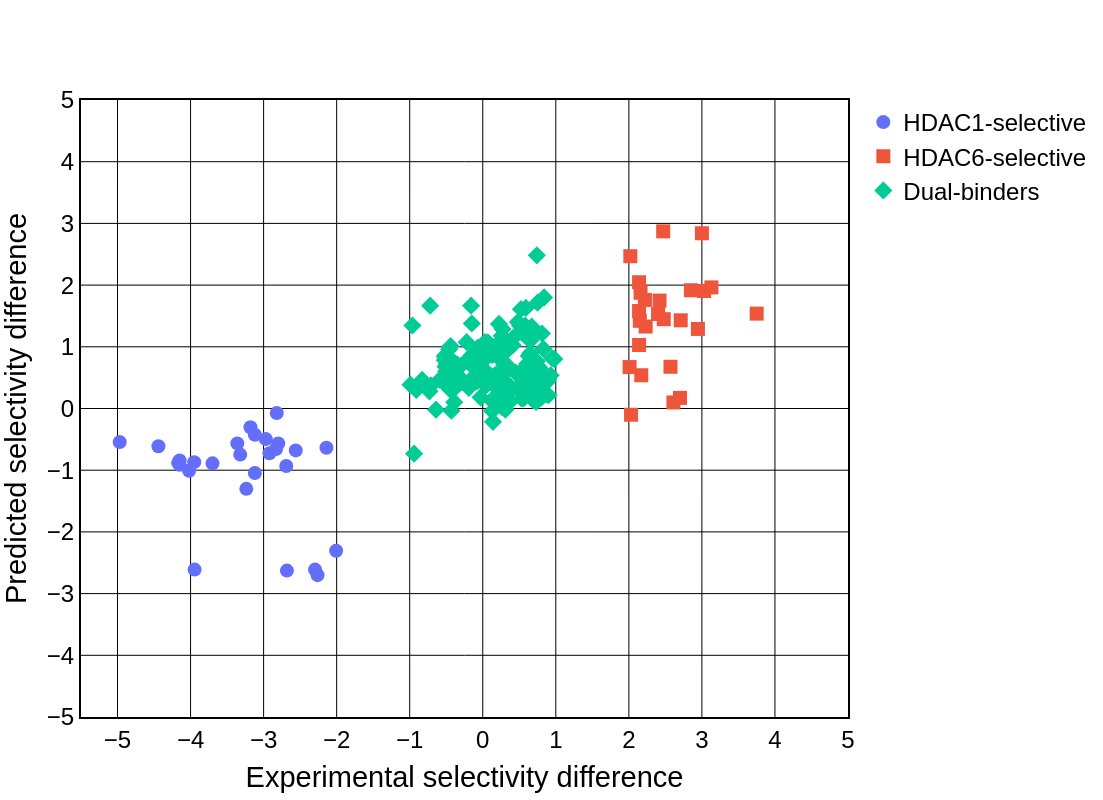

In [31]:
# plot hdac1-selective, hdac6-selective and dual selective compounds in predicted vs experimental plot
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)


#fig = px.scatter(df=HDAC1and6_ref_pred_DF_hdac1Sel, x="SelectivityWindow", y="RF", )
#fig.show() 

dfs = {"HDAC1-selective" : SP_reg_hdac1Sel, "HDAC6-selective": SP_reg_hdac6Sel, "Dual-binders" : SP_reg_dual}



# plot the data
fig = go.Figure()

for i in dfs:
    fig = fig.add_trace(go.Scatter(x = dfs[i]["SelectivityWindow"],
                                   y = dfs[i]["SP_ave"], 
                                   name = i,mode="markers",marker=dict(size=14, symbol = dfs[i]['Marker']) ), )

fig.update_layout(
    autosize=False,
    width=1000,
    height=800,
    xaxis_title="Experimental selectivity difference",
    yaxis_title="Predicted selectivity difference",
    template= "plotly_white",
    
    font=dict(
        #family="Courier New, monospace",
        size=24,
        color="Black"
    )
) 
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', dtick=1, showgrid=True, zeroline=True, mirror=True, zerolinecolor='black',
       zerolinewidth=1, gridwidth=1, gridcolor='black', range=[-5.5, 5])
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', dtick=1, showgrid=True, zeroline=True, mirror=True, zerolinecolor='black',
       zerolinewidth=1, gridwidth=1, gridcolor='black', range=[-5, 5])

#fig.add_shape( # add a horizontal "target" line
#    type="line", line_color="salmon", line_width=3, opacity=1, line_dash="dot",
#    x0=-4, x1=5, y0=2, y1=2, )

#fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)', 'paper_bgcolor': 'rgba(0, 0, 0, 0)',
#})

fig.show()

## Selectivity Profiling Evaluate Each Class Separately 

In [32]:
SelProf_rf_HDAC1Sel = selectivity_profile_reg.copy()
SelProf_rf_HDAC1Sel['selectivity'] = np.zeros(len(SelProf_rf_HDAC1Sel))
SelProf_rf_HDAC1Sel.loc[SelProf_rf_HDAC1Sel[SelProf_rf_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelProf_rf_HDAC1Sel.loc[SelProf_rf_HDAC1Sel[SelProf_rf_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_rf_HDAC1Sel['HDAC1_SP_rf'] = np.zeros(len(SelProf_rf_HDAC1Sel))
SelProf_rf_HDAC1Sel.loc[SelProf_rf_HDAC1Sel[(SelProf_rf_HDAC1Sel['SP_rf'] <= -1.0)].index, 'HDAC1_SP_rf'] = 1
SP_HDAC1Sel = SelProf_rf_HDAC1Sel['selectivity']
SP_HDAC1Sel_rf = SelProf_rf_HDAC1Sel['HDAC1_SP_rf']
conf_matrix_HDAC1Sel_rf=confusion_matrix(SP_HDAC1Sel, SP_HDAC1Sel_rf)
TP_HDAC1Sel_rf = conf_matrix_HDAC1Sel_rf[1][1]
TN_HDAC1Sel_rf = conf_matrix_HDAC1Sel_rf[0][0]
FP_HDAC1Sel_rf = conf_matrix_HDAC1Sel_rf[0][1] 
FN_HDAC1Sel_rf = conf_matrix_HDAC1Sel_rf[1][0]
Accuracy_HDAC1Sel_rf = accuracy_score(SP_HDAC1Sel,SP_HDAC1Sel_rf)
Precision_HDAC1Sel_rf = precision_score(SP_HDAC1Sel, SP_HDAC1Sel_rf)
Sensitivity_HDAC1Sel_rf = recall_score(SP_HDAC1Sel, SP_HDAC1Sel_rf)
Specificity_HDAC1Sel_rf = round( TN_HDAC1Sel_rf/ (TN_HDAC1Sel_rf+FP_HDAC1Sel_rf),4 )
f1_scores_HDAC1Sel_rf = f1_score(SP_HDAC1Sel, SP_HDAC1Sel_rf)
f1_scores_M_HDAC1Sel_rf = f1_score(SP_HDAC1Sel, SP_HDAC1Sel_rf, average="macro")
BA_scores_HDAC1Sel_rf = balanced_accuracy_score(SP_HDAC1Sel, SP_HDAC1Sel_rf)
MCC_HDAC1Sel_rf = matthews_corrcoef(SP_HDAC1Sel, SP_HDAC1Sel_rf)
NPV_HDAC1Sel_rf= round( TN_HDAC1Sel_rf / (TN_HDAC1Sel_rf+FN_HDAC1Sel_rf),4 )
ROC_AUC_HDAC1Sel_rf = roc_auc_score(SP_HDAC1Sel, SP_HDAC1Sel_rf)
mat_met_SP_rf = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'RF(HDAC1-binder)':[np.mean(TP_HDAC1Sel_rf),np.mean(TN_HDAC1Sel_rf),np.mean(FP_HDAC1Sel_rf),
                 np.mean(FN_HDAC1Sel_rf),np.mean(Accuracy_HDAC1Sel_rf),np.mean(Precision_HDAC1Sel_rf),
                 np.mean(Sensitivity_HDAC1Sel_rf),np.mean(Specificity_HDAC1Sel_rf),np.mean(f1_scores_HDAC1Sel_rf),
                 np.mean(f1_scores_M_HDAC1Sel_rf), np.mean(BA_scores_HDAC1Sel_rf),np.mean(MCC_HDAC1Sel_rf),
                 np.mean(NPV_HDAC1Sel_rf), np.mean(ROC_AUC_HDAC1Sel_rf)]}) 


SelProf_rf_HDAC6Sel = selectivity_profile_reg.copy()
SelProf_rf_HDAC6Sel['selectivity'] = np.zeros(len(SelProf_rf_HDAC6Sel))
SelProf_rf_HDAC6Sel.loc[SelProf_rf_HDAC6Sel[SelProf_rf_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelProf_rf_HDAC6Sel.loc[SelProf_rf_HDAC6Sel[SelProf_rf_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_rf_HDAC6Sel['HDAC6_SP_rf'] = np.zeros(len(SelProf_rf_HDAC6Sel))
SelProf_rf_HDAC6Sel.loc[SelProf_rf_HDAC6Sel[(SelProf_rf_HDAC6Sel['SP_rf'] >= 1.5)].index, 'HDAC6_SP_rf'] = 1
SP_HDAC6Sel = SelProf_rf_HDAC6Sel['selectivity']
SP_HDAC6Sel_rf = SelProf_rf_HDAC6Sel['HDAC6_SP_rf']
conf_matrix_HDAC6Sel_rf=confusion_matrix(SP_HDAC6Sel, SP_HDAC6Sel_rf)
TP_HDAC6Sel_rf = conf_matrix_HDAC6Sel_rf[1][1]
TN_HDAC6Sel_rf = conf_matrix_HDAC6Sel_rf[0][0]
FP_HDAC6Sel_rf = conf_matrix_HDAC6Sel_rf[0][1] 
FN_HDAC6Sel_rf = conf_matrix_HDAC6Sel_rf[1][0]
Accuracy_HDAC6Sel_rf = accuracy_score(SP_HDAC6Sel,SP_HDAC6Sel_rf)
Precision_HDAC6Sel_rf = precision_score(SP_HDAC6Sel, SP_HDAC6Sel_rf)
Sensitivity_HDAC6Sel_rf = recall_score(SP_HDAC6Sel, SP_HDAC6Sel_rf)
Specificity_HDAC6Sel_rf = round( TN_HDAC6Sel_rf/ (TN_HDAC6Sel_rf+FP_HDAC6Sel_rf),4 )
f1_scores_HDAC6Sel_rf = f1_score(SP_HDAC6Sel, SP_HDAC6Sel_rf)
f1_scores_M_HDAC6Sel_rf = f1_score(SP_HDAC6Sel, SP_HDAC6Sel_rf, average="macro")
BA_scores_HDAC6Sel_rf = balanced_accuracy_score(SP_HDAC6Sel, SP_HDAC6Sel_rf)
MCC_HDAC6Sel_rf = matthews_corrcoef(SP_HDAC6Sel, SP_HDAC6Sel_rf)
NPV_HDAC6Sel_rf= round( TN_HDAC6Sel_rf / (TN_HDAC6Sel_rf+FN_HDAC6Sel_rf),4 )
ROC_AUC_HDAC6Sel_rf = roc_auc_score(SP_HDAC6Sel, SP_HDAC6Sel_rf)
HDAC6_SP_rf_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'RF(HDAC6-binder)':[np.mean(TP_HDAC6Sel_rf),np.mean(TN_HDAC6Sel_rf),np.mean(FP_HDAC6Sel_rf),
                 np.mean(FN_HDAC6Sel_rf),np.mean(Accuracy_HDAC6Sel_rf),np.mean(Precision_HDAC6Sel_rf),
                 np.mean(Sensitivity_HDAC6Sel_rf),np.mean(Specificity_HDAC6Sel_rf),np.mean(f1_scores_HDAC6Sel_rf),
                 np.mean(f1_scores_M_HDAC6Sel_rf), np.mean(BA_scores_HDAC6Sel_rf),np.mean(MCC_HDAC6Sel_rf),
                 np.mean(NPV_HDAC6Sel_rf), np.mean(ROC_AUC_HDAC6Sel_rf)]}) 
mat_met_SP_rf = mat_met_SP_rf.merge(HDAC6_SP_rf_ave, on='Metric')


SelProf_rf_DualSel = selectivity_profile_reg.copy()
SelProf_rf_DualSel['selectivity'] = np.zeros(len(SelProf_rf_DualSel))
SelProf_rf_DualSel.loc[SelProf_rf_DualSel[SelProf_rf_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelProf_rf_DualSel.loc[SelProf_rf_DualSel[SelProf_rf_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_rf_DualSel['Dual_SP_rf'] = np.zeros(len(SelProf_rf_DualSel))
SelProf_rf_DualSel.loc[SelProf_rf_DualSel[(SelProf_rf_DualSel['SP_rf'] >= -1)  & (SelProf_rf_DualSel['SP_rf'] <= 1)].index, 'Dual_SP_rf'] = 1
SP_DualSel = SelProf_rf_DualSel['selectivity']
SP_DualSel_rf = SelProf_rf_DualSel['Dual_SP_rf']
conf_matrix_DualSel_rf=confusion_matrix(SP_DualSel, SP_DualSel_rf)
TP_DualSel_rf = conf_matrix_DualSel_rf[1][1]
TN_DualSel_rf = conf_matrix_DualSel_rf[0][0]
FP_DualSel_rf = conf_matrix_DualSel_rf[0][1] 
FN_DualSel_rf = conf_matrix_DualSel_rf[1][0]
Accuracy_DualSel_rf = accuracy_score(SP_DualSel,SP_DualSel_rf)
Precision_DualSel_rf = precision_score(SP_DualSel, SP_DualSel_rf)
Sensitivity_DualSel_rf = recall_score(SP_DualSel, SP_DualSel_rf)
Specificity_DualSel_rf = round( TN_DualSel_rf/ (TN_DualSel_rf+FP_DualSel_rf),4 )
f1_scores_DualSel_rf = f1_score(SP_DualSel, SP_DualSel_rf)
f1_scores_M_DualSel_rf = f1_score(SP_DualSel, SP_DualSel_rf, average="macro")
BA_scores_DualSel_rf = balanced_accuracy_score(SP_DualSel, SP_DualSel_rf)
MCC_DualSel_rf = matthews_corrcoef(SP_DualSel, SP_DualSel_rf)
NPV_DualSel_rf= round( TN_DualSel_rf / (TN_DualSel_rf+FN_DualSel_rf),4 )
ROC_AUC_DualSel_rf = roc_auc_score(SP_DualSel, SP_DualSel_rf)
Dual_SP_rf_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'RF(Dual-binder)':[np.mean(TP_DualSel_rf),np.mean(TN_DualSel_rf),np.mean(FP_DualSel_rf),
                 np.mean(FN_DualSel_rf),np.mean(Accuracy_DualSel_rf),np.mean(Precision_DualSel_rf),
                 np.mean(Sensitivity_DualSel_rf),np.mean(Specificity_DualSel_rf),np.mean(f1_scores_DualSel_rf),
                 np.mean(f1_scores_M_DualSel_rf), np.mean(BA_scores_DualSel_rf),np.mean(MCC_DualSel_rf),
                 np.mean(NPV_DualSel_rf), np.mean(ROC_AUC_DualSel_rf)]}) 
mat_met_SP_rf = mat_met_SP_rf.merge(Dual_SP_rf_ave, on='Metric')
mat_met_SP_rf

,Metric,RF(HDAC1-binder),RF(HDAC6-binder),RF(Dual-binder)
0,TP,7.000000,15.000000,108.000000
1,TN,389.000000,331.000000,125.000000
2,FP,4.000000,63.000000,158.000000
3,FN,20.000000,11.000000,29.000000
4,Accuracy,0.942857,0.823810,0.554762
5,Precision,0.636364,0.192308,0.406015
6,Sensitivity,0.259259,0.576923,0.788321
7,Specificity,0.989800,0.840100,0.441700
8,F1 score,0.368421,0.288462,0.535980
9,F1 score (macro),0.669248,0.593959,0.554031


In [33]:
SelProf_lgbm_HDAC1Sel = selectivity_profile_reg.copy()
SelProf_lgbm_HDAC1Sel['selectivity'] = np.zeros(len(SelProf_lgbm_HDAC1Sel))
SelProf_lgbm_HDAC1Sel.loc[SelProf_lgbm_HDAC1Sel[SelProf_lgbm_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelProf_lgbm_HDAC1Sel.loc[SelProf_lgbm_HDAC1Sel[SelProf_lgbm_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_lgbm_HDAC1Sel['HDAC1_SP_lgbm'] = np.zeros(len(SelProf_lgbm_HDAC1Sel))
SelProf_lgbm_HDAC1Sel.loc[SelProf_lgbm_HDAC1Sel[(SelProf_lgbm_HDAC1Sel['SP_lgbm'] <= -1.0)].index, 'HDAC1_SP_lgbm'] = 1
SP_HDAC1Sel = SelProf_lgbm_HDAC1Sel['selectivity']
SP_HDAC1Sel_lgbm = SelProf_lgbm_HDAC1Sel['HDAC1_SP_lgbm']
conf_matrix_HDAC1Sel_lgbm=confusion_matrix(SP_HDAC1Sel, SP_HDAC1Sel_lgbm)
TP_HDAC1Sel_lgbm = conf_matrix_HDAC1Sel_lgbm[1][1]
TN_HDAC1Sel_lgbm = conf_matrix_HDAC1Sel_lgbm[0][0]
FP_HDAC1Sel_lgbm = conf_matrix_HDAC1Sel_lgbm[0][1] 
FN_HDAC1Sel_lgbm = conf_matrix_HDAC1Sel_lgbm[1][0]
Accuracy_HDAC1Sel_lgbm = accuracy_score(SP_HDAC1Sel,SP_HDAC1Sel_lgbm)
Precision_HDAC1Sel_lgbm = precision_score(SP_HDAC1Sel, SP_HDAC1Sel_lgbm)
Sensitivity_HDAC1Sel_lgbm = recall_score(SP_HDAC1Sel, SP_HDAC1Sel_lgbm)
Specificity_HDAC1Sel_lgbm = round( TN_HDAC1Sel_lgbm/ (TN_HDAC1Sel_lgbm+FP_HDAC1Sel_lgbm),4 )
f1_scores_HDAC1Sel_lgbm = f1_score(SP_HDAC1Sel, SP_HDAC1Sel_lgbm)
f1_scores_M_HDAC1Sel_lgbm = f1_score(SP_HDAC1Sel, SP_HDAC1Sel_lgbm, average="macro")
BA_scores_HDAC1Sel_lgbm = balanced_accuracy_score(SP_HDAC1Sel, SP_HDAC1Sel_lgbm)
MCC_HDAC1Sel_lgbm = matthews_corrcoef(SP_HDAC1Sel, SP_HDAC1Sel_lgbm)
NPV_HDAC1Sel_lgbm= round( TN_HDAC1Sel_lgbm / (TN_HDAC1Sel_lgbm+FN_HDAC1Sel_lgbm),4 )
ROC_AUC_HDAC1Sel_lgbm = roc_auc_score(SP_HDAC1Sel, SP_HDAC1Sel_lgbm)
mat_met_SP_lgbm = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'lgbm(HDAC1-binder)':[np.mean(TP_HDAC1Sel_lgbm),np.mean(TN_HDAC1Sel_lgbm),np.mean(FP_HDAC1Sel_lgbm),
                 np.mean(FN_HDAC1Sel_lgbm),np.mean(Accuracy_HDAC1Sel_lgbm),np.mean(Precision_HDAC1Sel_lgbm),
                 np.mean(Sensitivity_HDAC1Sel_lgbm),np.mean(Specificity_HDAC1Sel_lgbm),np.mean(f1_scores_HDAC1Sel_lgbm),
                 np.mean(f1_scores_M_HDAC1Sel_lgbm), np.mean(BA_scores_HDAC1Sel_lgbm),np.mean(MCC_HDAC1Sel_lgbm),
                 np.mean(NPV_HDAC1Sel_lgbm), np.mean(ROC_AUC_HDAC1Sel_lgbm)]}) 


SelProf_lgbm_HDAC6Sel = selectivity_profile_reg.copy()
SelProf_lgbm_HDAC6Sel['selectivity'] = np.zeros(len(SelProf_lgbm_HDAC6Sel))
SelProf_lgbm_HDAC6Sel.loc[SelProf_lgbm_HDAC6Sel[SelProf_lgbm_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelProf_lgbm_HDAC6Sel.loc[SelProf_lgbm_HDAC6Sel[SelProf_lgbm_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_lgbm_HDAC6Sel['HDAC6_SP_lgbm'] = np.zeros(len(SelProf_lgbm_HDAC6Sel))
SelProf_lgbm_HDAC6Sel.loc[SelProf_lgbm_HDAC6Sel[(SelProf_lgbm_HDAC6Sel['SP_lgbm'] >= 1.5)].index, 'HDAC6_SP_lgbm'] = 1
SP_HDAC6Sel = SelProf_lgbm_HDAC6Sel['selectivity']
SP_HDAC6Sel_lgbm = SelProf_lgbm_HDAC6Sel['HDAC6_SP_lgbm']
conf_matrix_HDAC6Sel_lgbm=confusion_matrix(SP_HDAC6Sel, SP_HDAC6Sel_lgbm)
TP_HDAC6Sel_lgbm = conf_matrix_HDAC6Sel_lgbm[1][1]
TN_HDAC6Sel_lgbm = conf_matrix_HDAC6Sel_lgbm[0][0]
FP_HDAC6Sel_lgbm = conf_matrix_HDAC6Sel_lgbm[0][1] 
FN_HDAC6Sel_lgbm = conf_matrix_HDAC6Sel_lgbm[1][0]
Accuracy_HDAC6Sel_lgbm = accuracy_score(SP_HDAC6Sel,SP_HDAC6Sel_lgbm)
Precision_HDAC6Sel_lgbm = precision_score(SP_HDAC6Sel, SP_HDAC6Sel_lgbm)
Sensitivity_HDAC6Sel_lgbm = recall_score(SP_HDAC6Sel, SP_HDAC6Sel_lgbm)
Specificity_HDAC6Sel_lgbm = round( TN_HDAC6Sel_lgbm/ (TN_HDAC6Sel_lgbm+FP_HDAC6Sel_lgbm),4 )
f1_scores_HDAC6Sel_lgbm = f1_score(SP_HDAC6Sel, SP_HDAC6Sel_lgbm)
f1_scores_M_HDAC6Sel_lgbm = f1_score(SP_HDAC6Sel, SP_HDAC6Sel_lgbm, average="macro")
BA_scores_HDAC6Sel_lgbm = balanced_accuracy_score(SP_HDAC6Sel, SP_HDAC6Sel_lgbm)
MCC_HDAC6Sel_lgbm = matthews_corrcoef(SP_HDAC6Sel, SP_HDAC6Sel_lgbm)
NPV_HDAC6Sel_lgbm= round( TN_HDAC6Sel_lgbm / (TN_HDAC6Sel_lgbm+FN_HDAC6Sel_lgbm),4 )
ROC_AUC_HDAC6Sel_lgbm = roc_auc_score(SP_HDAC6Sel, SP_HDAC6Sel_lgbm)
HDAC6_SP_lgbm_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'lgbm(HDAC6-binder)':[np.mean(TP_HDAC6Sel_lgbm),np.mean(TN_HDAC6Sel_lgbm),np.mean(FP_HDAC6Sel_lgbm),
                 np.mean(FN_HDAC6Sel_lgbm),np.mean(Accuracy_HDAC6Sel_lgbm),np.mean(Precision_HDAC6Sel_lgbm),
                 np.mean(Sensitivity_HDAC6Sel_lgbm),np.mean(Specificity_HDAC6Sel_lgbm),np.mean(f1_scores_HDAC6Sel_lgbm),
                 np.mean(f1_scores_M_HDAC6Sel_lgbm), np.mean(BA_scores_HDAC6Sel_lgbm),np.mean(MCC_HDAC6Sel_lgbm),
                 np.mean(NPV_HDAC6Sel_lgbm), np.mean(ROC_AUC_HDAC6Sel_lgbm)]}) 
mat_met_SP_lgbm = mat_met_SP_lgbm.merge(HDAC6_SP_lgbm_ave, on='Metric')


SelProf_lgbm_DualSel = selectivity_profile_reg.copy()
SelProf_lgbm_DualSel['selectivity'] = np.zeros(len(SelProf_lgbm_DualSel))
SelProf_lgbm_DualSel.loc[SelProf_lgbm_DualSel[SelProf_lgbm_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelProf_lgbm_DualSel.loc[SelProf_lgbm_DualSel[SelProf_lgbm_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_lgbm_DualSel['Dual_SP_lgbm'] = np.zeros(len(SelProf_lgbm_DualSel))
SelProf_lgbm_DualSel.loc[SelProf_lgbm_DualSel[(SelProf_lgbm_DualSel['SP_lgbm'] >= -1)  & (SelProf_lgbm_DualSel['SP_lgbm'] <= 1)].index, 'Dual_SP_lgbm'] = 1
SP_DualSel = SelProf_lgbm_DualSel['selectivity']
SP_DualSel_lgbm = SelProf_lgbm_DualSel['Dual_SP_lgbm']
conf_matrix_DualSel_lgbm=confusion_matrix(SP_DualSel, SP_DualSel_lgbm)
TP_DualSel_lgbm = conf_matrix_DualSel_lgbm[1][1]
TN_DualSel_lgbm = conf_matrix_DualSel_lgbm[0][0]
FP_DualSel_lgbm = conf_matrix_DualSel_lgbm[0][1] 
FN_DualSel_lgbm = conf_matrix_DualSel_lgbm[1][0]
Accuracy_DualSel_lgbm = accuracy_score(SP_DualSel,SP_DualSel_lgbm)
Precision_DualSel_lgbm = precision_score(SP_DualSel, SP_DualSel_lgbm)
Sensitivity_DualSel_lgbm = recall_score(SP_DualSel, SP_DualSel_lgbm)
Specificity_DualSel_lgbm = round( TN_DualSel_lgbm/ (TN_DualSel_lgbm+FP_DualSel_lgbm),4 )
f1_scores_DualSel_lgbm = f1_score(SP_DualSel, SP_DualSel_lgbm)
f1_scores_M_DualSel_lgbm = f1_score(SP_DualSel, SP_DualSel_lgbm, average="macro")
BA_scores_DualSel_lgbm = balanced_accuracy_score(SP_DualSel, SP_DualSel_lgbm)
MCC_DualSel_lgbm = matthews_corrcoef(SP_DualSel, SP_DualSel_lgbm)
NPV_DualSel_lgbm= round( TN_DualSel_lgbm / (TN_DualSel_lgbm+FN_DualSel_lgbm),4 )
ROC_AUC_DualSel_lgbm = roc_auc_score(SP_DualSel, SP_DualSel_lgbm)
Dual_SP_lgbm_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'lgbm(Dual-binder)':[np.mean(TP_DualSel_lgbm),np.mean(TN_DualSel_lgbm),np.mean(FP_DualSel_lgbm),
                 np.mean(FN_DualSel_lgbm),np.mean(Accuracy_DualSel_lgbm),np.mean(Precision_DualSel_lgbm),
                 np.mean(Sensitivity_DualSel_lgbm),np.mean(Specificity_DualSel_lgbm),np.mean(f1_scores_DualSel_lgbm),
                 np.mean(f1_scores_M_DualSel_lgbm), np.mean(BA_scores_DualSel_lgbm),np.mean(MCC_DualSel_lgbm),
                 np.mean(NPV_DualSel_lgbm), np.mean(ROC_AUC_DualSel_lgbm)]}) 
mat_met_SP_lgbm = mat_met_SP_lgbm.merge(Dual_SP_lgbm_ave, on='Metric')
mat_met_SP_lgbm

,Metric,lgbm(HDAC1-binder),lgbm(HDAC6-binder),lgbm(Dual-binder)
0,TP,23.000000,13.000000,100.000000
1,TN,375.000000,334.000000,157.000000
2,FP,18.000000,60.000000,126.000000
3,FN,4.000000,13.000000,37.000000
4,Accuracy,0.947619,0.826190,0.611905
5,Precision,0.560976,0.178082,0.442478
6,Sensitivity,0.851852,0.500000,0.729927
7,Specificity,0.954200,0.847700,0.554800
8,F1 score,0.676471,0.262626,0.550964
9,F1 score (macro),0.823987,0.582055,0.604623


In [34]:
SelProf_xgb_HDAC1Sel = selectivity_profile_reg.copy()
SelProf_xgb_HDAC1Sel['selectivity'] = np.zeros(len(SelProf_xgb_HDAC1Sel))
SelProf_xgb_HDAC1Sel.loc[SelProf_xgb_HDAC1Sel[SelProf_xgb_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelProf_xgb_HDAC1Sel.loc[SelProf_xgb_HDAC1Sel[SelProf_xgb_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_xgb_HDAC1Sel['HDAC1_SP_xgb'] = np.zeros(len(SelProf_xgb_HDAC1Sel))
SelProf_xgb_HDAC1Sel.loc[SelProf_xgb_HDAC1Sel[(SelProf_xgb_HDAC1Sel['SP_xgb'] <= -1.0)].index, 'HDAC1_SP_xgb'] = 1
SP_HDAC1Sel = SelProf_xgb_HDAC1Sel['selectivity']
SP_HDAC1Sel_xgb = SelProf_xgb_HDAC1Sel['HDAC1_SP_xgb']
conf_matrix_HDAC1Sel_xgb=confusion_matrix(SP_HDAC1Sel, SP_HDAC1Sel_xgb)
TP_HDAC1Sel_xgb = conf_matrix_HDAC1Sel_xgb[1][1]
TN_HDAC1Sel_xgb = conf_matrix_HDAC1Sel_xgb[0][0]
FP_HDAC1Sel_xgb = conf_matrix_HDAC1Sel_xgb[0][1] 
FN_HDAC1Sel_xgb = conf_matrix_HDAC1Sel_xgb[1][0]
Accuracy_HDAC1Sel_xgb = accuracy_score(SP_HDAC1Sel,SP_HDAC1Sel_xgb)
Precision_HDAC1Sel_xgb = precision_score(SP_HDAC1Sel, SP_HDAC1Sel_xgb)
Sensitivity_HDAC1Sel_xgb = recall_score(SP_HDAC1Sel, SP_HDAC1Sel_xgb)
Specificity_HDAC1Sel_xgb = round( TN_HDAC1Sel_xgb/ (TN_HDAC1Sel_xgb+FP_HDAC1Sel_xgb),4 )
f1_scores_HDAC1Sel_xgb = f1_score(SP_HDAC1Sel, SP_HDAC1Sel_xgb)
f1_scores_M_HDAC1Sel_xgb = f1_score(SP_HDAC1Sel, SP_HDAC1Sel_xgb, average="macro")
BA_scores_HDAC1Sel_xgb = balanced_accuracy_score(SP_HDAC1Sel, SP_HDAC1Sel_xgb)
MCC_HDAC1Sel_xgb = matthews_corrcoef(SP_HDAC1Sel, SP_HDAC1Sel_xgb)
NPV_HDAC1Sel_xgb= round( TN_HDAC1Sel_xgb / (TN_HDAC1Sel_xgb+FN_HDAC1Sel_xgb),4 )
ROC_AUC_HDAC1Sel_xgb = roc_auc_score(SP_HDAC1Sel, SP_HDAC1Sel_xgb)
mat_met_SP_xgb = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'xgb(HDAC1-binder)':[np.mean(TP_HDAC1Sel_xgb),np.mean(TN_HDAC1Sel_xgb),np.mean(FP_HDAC1Sel_xgb),
                 np.mean(FN_HDAC1Sel_xgb),np.mean(Accuracy_HDAC1Sel_xgb),np.mean(Precision_HDAC1Sel_xgb),
                 np.mean(Sensitivity_HDAC1Sel_xgb),np.mean(Specificity_HDAC1Sel_xgb),np.mean(f1_scores_HDAC1Sel_xgb),
                 np.mean(f1_scores_M_HDAC1Sel_xgb), np.mean(BA_scores_HDAC1Sel_xgb),np.mean(MCC_HDAC1Sel_xgb),
                 np.mean(NPV_HDAC1Sel_xgb), np.mean(ROC_AUC_HDAC1Sel_xgb)]}) 


SelProf_xgb_HDAC6Sel = selectivity_profile_reg.copy()
SelProf_xgb_HDAC6Sel['selectivity'] = np.zeros(len(SelProf_xgb_HDAC6Sel))
SelProf_xgb_HDAC6Sel.loc[SelProf_xgb_HDAC6Sel[SelProf_xgb_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelProf_xgb_HDAC6Sel.loc[SelProf_xgb_HDAC6Sel[SelProf_xgb_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_xgb_HDAC6Sel['HDAC6_SP_xgb'] = np.zeros(len(SelProf_xgb_HDAC6Sel))
SelProf_xgb_HDAC6Sel.loc[SelProf_xgb_HDAC6Sel[(SelProf_xgb_HDAC6Sel['SP_xgb'] >= 1.5)].index, 'HDAC6_SP_xgb'] = 1
SP_HDAC6Sel = SelProf_xgb_HDAC6Sel['selectivity']
SP_HDAC6Sel_xgb = SelProf_xgb_HDAC6Sel['HDAC6_SP_xgb']
conf_matrix_HDAC6Sel_xgb=confusion_matrix(SP_HDAC6Sel, SP_HDAC6Sel_xgb)
TP_HDAC6Sel_xgb = conf_matrix_HDAC6Sel_xgb[1][1]
TN_HDAC6Sel_xgb = conf_matrix_HDAC6Sel_xgb[0][0]
FP_HDAC6Sel_xgb = conf_matrix_HDAC6Sel_xgb[0][1] 
FN_HDAC6Sel_xgb = conf_matrix_HDAC6Sel_xgb[1][0]
Accuracy_HDAC6Sel_xgb = accuracy_score(SP_HDAC6Sel,SP_HDAC6Sel_xgb)
Precision_HDAC6Sel_xgb = precision_score(SP_HDAC6Sel, SP_HDAC6Sel_xgb)
Sensitivity_HDAC6Sel_xgb = recall_score(SP_HDAC6Sel, SP_HDAC6Sel_xgb)
Specificity_HDAC6Sel_xgb = round( TN_HDAC6Sel_xgb/ (TN_HDAC6Sel_xgb+FP_HDAC6Sel_xgb),4 )
f1_scores_HDAC6Sel_xgb = f1_score(SP_HDAC6Sel, SP_HDAC6Sel_xgb)
f1_scores_M_HDAC6Sel_xgb = f1_score(SP_HDAC6Sel, SP_HDAC6Sel_xgb, average="macro")
BA_scores_HDAC6Sel_xgb = balanced_accuracy_score(SP_HDAC6Sel, SP_HDAC6Sel_xgb)
MCC_HDAC6Sel_xgb = matthews_corrcoef(SP_HDAC6Sel, SP_HDAC6Sel_xgb)
NPV_HDAC6Sel_xgb= round( TN_HDAC6Sel_xgb / (TN_HDAC6Sel_xgb+FN_HDAC6Sel_xgb),4 )
ROC_AUC_HDAC6Sel_xgb = roc_auc_score(SP_HDAC6Sel, SP_HDAC6Sel_xgb)
HDAC6_SP_xgb_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'xgb(HDAC6-binder)':[np.mean(TP_HDAC6Sel_xgb),np.mean(TN_HDAC6Sel_xgb),np.mean(FP_HDAC6Sel_xgb),
                 np.mean(FN_HDAC6Sel_xgb),np.mean(Accuracy_HDAC6Sel_xgb),np.mean(Precision_HDAC6Sel_xgb),
                 np.mean(Sensitivity_HDAC6Sel_xgb),np.mean(Specificity_HDAC6Sel_xgb),np.mean(f1_scores_HDAC6Sel_xgb),
                 np.mean(f1_scores_M_HDAC6Sel_xgb), np.mean(BA_scores_HDAC6Sel_xgb),np.mean(MCC_HDAC6Sel_xgb),
                 np.mean(NPV_HDAC6Sel_xgb), np.mean(ROC_AUC_HDAC6Sel_xgb)]}) 
mat_met_SP_xgb = mat_met_SP_xgb.merge(HDAC6_SP_xgb_ave, on='Metric')


SelProf_xgb_DualSel = selectivity_profile_reg.copy()
SelProf_xgb_DualSel['selectivity'] = np.zeros(len(SelProf_xgb_DualSel))
SelProf_xgb_DualSel.loc[SelProf_xgb_DualSel[SelProf_xgb_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelProf_xgb_DualSel.loc[SelProf_xgb_DualSel[SelProf_xgb_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_xgb_DualSel['Dual_SP_xgb'] = np.zeros(len(SelProf_xgb_DualSel))
SelProf_xgb_DualSel.loc[SelProf_xgb_DualSel[(SelProf_xgb_DualSel['SP_xgb'] >= -1)  & (SelProf_xgb_DualSel['SP_xgb'] <= 1)].index, 'Dual_SP_xgb'] = 1
SP_DualSel = SelProf_xgb_DualSel['selectivity']
SP_DualSel_xgb = SelProf_xgb_DualSel['Dual_SP_xgb']
conf_matrix_DualSel_xgb=confusion_matrix(SP_DualSel, SP_DualSel_xgb)
TP_DualSel_xgb = conf_matrix_DualSel_xgb[1][1]
TN_DualSel_xgb = conf_matrix_DualSel_xgb[0][0]
FP_DualSel_xgb = conf_matrix_DualSel_xgb[0][1] 
FN_DualSel_xgb = conf_matrix_DualSel_xgb[1][0]
Accuracy_DualSel_xgb = accuracy_score(SP_DualSel,SP_DualSel_xgb)
Precision_DualSel_xgb = precision_score(SP_DualSel, SP_DualSel_xgb)
Sensitivity_DualSel_xgb = recall_score(SP_DualSel, SP_DualSel_xgb)
Specificity_DualSel_xgb = round( TN_DualSel_xgb/ (TN_DualSel_xgb+FP_DualSel_xgb),4 )
f1_scores_DualSel_xgb = f1_score(SP_DualSel, SP_DualSel_xgb)
f1_scores_M_DualSel_xgb = f1_score(SP_DualSel, SP_DualSel_xgb, average="macro")
BA_scores_DualSel_xgb = balanced_accuracy_score(SP_DualSel, SP_DualSel_xgb)
MCC_DualSel_xgb = matthews_corrcoef(SP_DualSel, SP_DualSel_xgb)
NPV_DualSel_xgb= round( TN_DualSel_xgb / (TN_DualSel_xgb+FN_DualSel_xgb),4 )
ROC_AUC_DualSel_xgb = roc_auc_score(SP_DualSel, SP_DualSel_xgb)
Dual_SP_xgb_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'xgb(Dual-binder)':[np.mean(TP_DualSel_xgb),np.mean(TN_DualSel_xgb),np.mean(FP_DualSel_xgb),
                 np.mean(FN_DualSel_xgb),np.mean(Accuracy_DualSel_xgb),np.mean(Precision_DualSel_xgb),
                 np.mean(Sensitivity_DualSel_xgb),np.mean(Specificity_DualSel_xgb),np.mean(f1_scores_DualSel_xgb),
                 np.mean(f1_scores_M_DualSel_xgb), np.mean(BA_scores_DualSel_xgb),np.mean(MCC_DualSel_xgb),
                 np.mean(NPV_DualSel_xgb), np.mean(ROC_AUC_DualSel_xgb)]}) 
mat_met_SP_xgb = mat_met_SP_xgb.merge(Dual_SP_xgb_ave, on='Metric')
mat_met_SP_xgb

,Metric,xgb(HDAC1-binder),xgb(HDAC6-binder),xgb(Dual-binder)
0,TP,10.000000,12.000000,105.000000
1,TN,384.000000,353.000000,113.000000
2,FP,9.000000,41.000000,170.000000
3,FN,17.000000,14.000000,32.000000
4,Accuracy,0.938095,0.869048,0.519048
5,Precision,0.526316,0.226415,0.381818
6,Sensitivity,0.370370,0.461538,0.766423
7,Specificity,0.977100,0.895900,0.399300
8,F1 score,0.434783,0.303797,0.509709
9,F1 score (macro),0.701019,0.615762,0.518873


In [35]:
SelProf_knn_HDAC1Sel = selectivity_profile_reg.copy()
SelProf_knn_HDAC1Sel['selectivity'] = np.zeros(len(SelProf_knn_HDAC1Sel))
SelProf_knn_HDAC1Sel.loc[SelProf_knn_HDAC1Sel[SelProf_knn_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelProf_knn_HDAC1Sel.loc[SelProf_knn_HDAC1Sel[SelProf_knn_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_knn_HDAC1Sel['HDAC1_SP_knn'] = np.zeros(len(SelProf_knn_HDAC1Sel))
SelProf_knn_HDAC1Sel.loc[SelProf_knn_HDAC1Sel[(SelProf_knn_HDAC1Sel['SP_knn'] <= -1.0)].index, 'HDAC1_SP_knn'] = 1
SP_HDAC1Sel = SelProf_knn_HDAC1Sel['selectivity']
SP_HDAC1Sel_knn = SelProf_knn_HDAC1Sel['HDAC1_SP_knn']
conf_matrix_HDAC1Sel_knn=confusion_matrix(SP_HDAC1Sel, SP_HDAC1Sel_knn)
TP_HDAC1Sel_knn = conf_matrix_HDAC1Sel_knn[1][1]
TN_HDAC1Sel_knn = conf_matrix_HDAC1Sel_knn[0][0]
FP_HDAC1Sel_knn = conf_matrix_HDAC1Sel_knn[0][1] 
FN_HDAC1Sel_knn = conf_matrix_HDAC1Sel_knn[1][0]
Accuracy_HDAC1Sel_knn = accuracy_score(SP_HDAC1Sel,SP_HDAC1Sel_knn)
Precision_HDAC1Sel_knn = precision_score(SP_HDAC1Sel, SP_HDAC1Sel_knn)
Sensitivity_HDAC1Sel_knn = recall_score(SP_HDAC1Sel, SP_HDAC1Sel_knn)
Specificity_HDAC1Sel_knn = round( TN_HDAC1Sel_knn/ (TN_HDAC1Sel_knn+FP_HDAC1Sel_knn),4 )
f1_scores_HDAC1Sel_knn = f1_score(SP_HDAC1Sel, SP_HDAC1Sel_knn)
f1_scores_M_HDAC1Sel_knn = f1_score(SP_HDAC1Sel, SP_HDAC1Sel_knn, average="macro")
BA_scores_HDAC1Sel_knn = balanced_accuracy_score(SP_HDAC1Sel, SP_HDAC1Sel_knn)
MCC_HDAC1Sel_knn = matthews_corrcoef(SP_HDAC1Sel, SP_HDAC1Sel_knn)
NPV_HDAC1Sel_knn= round( TN_HDAC1Sel_knn / (TN_HDAC1Sel_knn+FN_HDAC1Sel_knn),4 )
ROC_AUC_HDAC1Sel_knn = roc_auc_score(SP_HDAC1Sel, SP_HDAC1Sel_knn)
mat_met_SP_knn = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'knn(HDAC1-binder)':[np.mean(TP_HDAC1Sel_knn),np.mean(TN_HDAC1Sel_knn),np.mean(FP_HDAC1Sel_knn),
                 np.mean(FN_HDAC1Sel_knn),np.mean(Accuracy_HDAC1Sel_knn),np.mean(Precision_HDAC1Sel_knn),
                 np.mean(Sensitivity_HDAC1Sel_knn),np.mean(Specificity_HDAC1Sel_knn),np.mean(f1_scores_HDAC1Sel_knn),
                 np.mean(f1_scores_M_HDAC1Sel_knn), np.mean(BA_scores_HDAC1Sel_knn),np.mean(MCC_HDAC1Sel_knn),
                 np.mean(NPV_HDAC1Sel_knn), np.mean(ROC_AUC_HDAC1Sel_knn)]}) 


SelProf_knn_HDAC6Sel = selectivity_profile_reg.copy()
SelProf_knn_HDAC6Sel['selectivity'] = np.zeros(len(SelProf_knn_HDAC6Sel))
SelProf_knn_HDAC6Sel.loc[SelProf_knn_HDAC6Sel[SelProf_knn_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelProf_knn_HDAC6Sel.loc[SelProf_knn_HDAC6Sel[SelProf_knn_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_knn_HDAC6Sel['HDAC6_SP_knn'] = np.zeros(len(SelProf_knn_HDAC6Sel))
SelProf_knn_HDAC6Sel.loc[SelProf_knn_HDAC6Sel[(SelProf_knn_HDAC6Sel['SP_knn'] >= 1.5)].index, 'HDAC6_SP_knn'] = 1
SP_HDAC6Sel = SelProf_knn_HDAC6Sel['selectivity']
SP_HDAC6Sel_knn = SelProf_knn_HDAC6Sel['HDAC6_SP_knn']
conf_matrix_HDAC6Sel_knn=confusion_matrix(SP_HDAC6Sel, SP_HDAC6Sel_knn)
TP_HDAC6Sel_knn = conf_matrix_HDAC6Sel_knn[1][1]
TN_HDAC6Sel_knn = conf_matrix_HDAC6Sel_knn[0][0]
FP_HDAC6Sel_knn = conf_matrix_HDAC6Sel_knn[0][1] 
FN_HDAC6Sel_knn = conf_matrix_HDAC6Sel_knn[1][0]
Accuracy_HDAC6Sel_knn = accuracy_score(SP_HDAC6Sel,SP_HDAC6Sel_knn)
Precision_HDAC6Sel_knn = precision_score(SP_HDAC6Sel, SP_HDAC6Sel_knn)
Sensitivity_HDAC6Sel_knn = recall_score(SP_HDAC6Sel, SP_HDAC6Sel_knn)
Specificity_HDAC6Sel_knn = round( TN_HDAC6Sel_knn/ (TN_HDAC6Sel_knn+FP_HDAC6Sel_knn),4 )
f1_scores_HDAC6Sel_knn = f1_score(SP_HDAC6Sel, SP_HDAC6Sel_knn)
f1_scores_M_HDAC6Sel_knn = f1_score(SP_HDAC6Sel, SP_HDAC6Sel_knn, average="macro")
BA_scores_HDAC6Sel_knn = balanced_accuracy_score(SP_HDAC6Sel, SP_HDAC6Sel_knn)
MCC_HDAC6Sel_knn = matthews_corrcoef(SP_HDAC6Sel, SP_HDAC6Sel_knn)
NPV_HDAC6Sel_knn= round( TN_HDAC6Sel_knn / (TN_HDAC6Sel_knn+FN_HDAC6Sel_knn),4 )
ROC_AUC_HDAC6Sel_knn = roc_auc_score(SP_HDAC6Sel, SP_HDAC6Sel_knn)
HDAC6_SP_knn_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'knn(HDAC6-binder)':[np.mean(TP_HDAC6Sel_knn),np.mean(TN_HDAC6Sel_knn),np.mean(FP_HDAC6Sel_knn),
                 np.mean(FN_HDAC6Sel_knn),np.mean(Accuracy_HDAC6Sel_knn),np.mean(Precision_HDAC6Sel_knn),
                 np.mean(Sensitivity_HDAC6Sel_knn),np.mean(Specificity_HDAC6Sel_knn),np.mean(f1_scores_HDAC6Sel_knn),
                 np.mean(f1_scores_M_HDAC6Sel_knn), np.mean(BA_scores_HDAC6Sel_knn),np.mean(MCC_HDAC6Sel_knn),
                 np.mean(NPV_HDAC6Sel_knn), np.mean(ROC_AUC_HDAC6Sel_knn)]}) 
mat_met_SP_knn = mat_met_SP_knn.merge(HDAC6_SP_knn_ave, on='Metric')


SelProf_knn_DualSel = selectivity_profile_reg.copy()
SelProf_knn_DualSel['selectivity'] = np.zeros(len(SelProf_knn_DualSel))
SelProf_knn_DualSel.loc[SelProf_knn_DualSel[SelProf_knn_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelProf_knn_DualSel.loc[SelProf_knn_DualSel[SelProf_knn_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_knn_DualSel['Dual_SP_knn'] = np.zeros(len(SelProf_knn_DualSel))
SelProf_knn_DualSel.loc[SelProf_knn_DualSel[(SelProf_knn_DualSel['SP_knn'] >= -1)  & (SelProf_knn_DualSel['SP_knn'] <= 1)].index, 'Dual_SP_knn'] = 1
SP_DualSel = SelProf_knn_DualSel['selectivity']
SP_DualSel_knn = SelProf_knn_DualSel['Dual_SP_knn']
conf_matrix_DualSel_knn=confusion_matrix(SP_DualSel, SP_DualSel_knn)
TP_DualSel_knn = conf_matrix_DualSel_knn[1][1]
TN_DualSel_knn = conf_matrix_DualSel_knn[0][0]
FP_DualSel_knn = conf_matrix_DualSel_knn[0][1] 
FN_DualSel_knn = conf_matrix_DualSel_knn[1][0]
Accuracy_DualSel_knn = accuracy_score(SP_DualSel,SP_DualSel_knn)
Precision_DualSel_knn = precision_score(SP_DualSel, SP_DualSel_knn)
Sensitivity_DualSel_knn = recall_score(SP_DualSel, SP_DualSel_knn)
Specificity_DualSel_knn = round( TN_DualSel_knn/ (TN_DualSel_knn+FP_DualSel_knn),4 )
f1_scores_DualSel_knn = f1_score(SP_DualSel, SP_DualSel_knn)
f1_scores_M_DualSel_knn = f1_score(SP_DualSel, SP_DualSel_knn, average="macro")
BA_scores_DualSel_knn = balanced_accuracy_score(SP_DualSel, SP_DualSel_knn)
MCC_DualSel_knn = matthews_corrcoef(SP_DualSel, SP_DualSel_knn)
NPV_DualSel_knn= round( TN_DualSel_knn / (TN_DualSel_knn+FN_DualSel_knn),4 )
ROC_AUC_DualSel_knn = roc_auc_score(SP_DualSel, SP_DualSel_knn)
Dual_SP_knn_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'knn(Dual-binder)':[np.mean(TP_DualSel_knn),np.mean(TN_DualSel_knn),np.mean(FP_DualSel_knn),
                 np.mean(FN_DualSel_knn),np.mean(Accuracy_DualSel_knn),np.mean(Precision_DualSel_knn),
                 np.mean(Sensitivity_DualSel_knn),np.mean(Specificity_DualSel_knn),np.mean(f1_scores_DualSel_knn),
                 np.mean(f1_scores_M_DualSel_knn), np.mean(BA_scores_DualSel_knn),np.mean(MCC_DualSel_knn),
                 np.mean(NPV_DualSel_knn), np.mean(ROC_AUC_DualSel_knn)]}) 
mat_met_SP_knn = mat_met_SP_knn.merge(Dual_SP_knn_ave, on='Metric')
mat_met_SP_knn

,Metric,knn(HDAC1-binder),knn(HDAC6-binder),knn(Dual-binder)
0,TP,10.000000,15.000000,85.000000
1,TN,389.000000,305.000000,165.000000
2,FP,4.000000,89.000000,118.000000
3,FN,17.000000,11.000000,52.000000
4,Accuracy,0.950000,0.761905,0.595238
5,Precision,0.714286,0.144231,0.418719
6,Sensitivity,0.370370,0.576923,0.620438
7,Specificity,0.989800,0.774100,0.583000
8,F1 score,0.487805,0.230769,0.500000
9,F1 score (macro),0.730761,0.544962,0.580000


In [36]:
SelProf_svm_HDAC1Sel = selectivity_profile_reg.copy()
SelProf_svm_HDAC1Sel['selectivity'] = np.zeros(len(SelProf_svm_HDAC1Sel))
SelProf_svm_HDAC1Sel.loc[SelProf_svm_HDAC1Sel[SelProf_svm_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelProf_svm_HDAC1Sel.loc[SelProf_svm_HDAC1Sel[SelProf_svm_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_svm_HDAC1Sel['HDAC1_SP_svm'] = np.zeros(len(SelProf_svm_HDAC1Sel))
SelProf_svm_HDAC1Sel.loc[SelProf_svm_HDAC1Sel[(SelProf_svm_HDAC1Sel['SP_svm'] <= -1.0)].index, 'HDAC1_SP_svm'] = 1
SP_HDAC1Sel = SelProf_svm_HDAC1Sel['selectivity']
SP_HDAC1Sel_svm = SelProf_svm_HDAC1Sel['HDAC1_SP_svm']
conf_matrix_HDAC1Sel_svm=confusion_matrix(SP_HDAC1Sel, SP_HDAC1Sel_svm)
TP_HDAC1Sel_svm = conf_matrix_HDAC1Sel_svm[1][1]
TN_HDAC1Sel_svm = conf_matrix_HDAC1Sel_svm[0][0]
FP_HDAC1Sel_svm = conf_matrix_HDAC1Sel_svm[0][1] 
FN_HDAC1Sel_svm = conf_matrix_HDAC1Sel_svm[1][0]
Accuracy_HDAC1Sel_svm = accuracy_score(SP_HDAC1Sel,SP_HDAC1Sel_svm)
Precision_HDAC1Sel_svm = precision_score(SP_HDAC1Sel, SP_HDAC1Sel_svm)
Sensitivity_HDAC1Sel_svm = recall_score(SP_HDAC1Sel, SP_HDAC1Sel_svm)
Specificity_HDAC1Sel_svm = round( TN_HDAC1Sel_svm/ (TN_HDAC1Sel_svm+FP_HDAC1Sel_svm),4 )
f1_scores_HDAC1Sel_svm = f1_score(SP_HDAC1Sel, SP_HDAC1Sel_svm)
f1_scores_M_HDAC1Sel_svm = f1_score(SP_HDAC1Sel, SP_HDAC1Sel_svm, average="macro")
BA_scores_HDAC1Sel_svm = balanced_accuracy_score(SP_HDAC1Sel, SP_HDAC1Sel_svm)
MCC_HDAC1Sel_svm = matthews_corrcoef(SP_HDAC1Sel, SP_HDAC1Sel_svm)
NPV_HDAC1Sel_svm= round( TN_HDAC1Sel_svm / (TN_HDAC1Sel_svm+FN_HDAC1Sel_svm),4 )
ROC_AUC_HDAC1Sel_svm = roc_auc_score(SP_HDAC1Sel, SP_HDAC1Sel_svm)
mat_met_SP_svm = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'svm(HDAC1-binder)':[np.mean(TP_HDAC1Sel_svm),np.mean(TN_HDAC1Sel_svm),np.mean(FP_HDAC1Sel_svm),
                 np.mean(FN_HDAC1Sel_svm),np.mean(Accuracy_HDAC1Sel_svm),np.mean(Precision_HDAC1Sel_svm),
                 np.mean(Sensitivity_HDAC1Sel_svm),np.mean(Specificity_HDAC1Sel_svm),np.mean(f1_scores_HDAC1Sel_svm),
                 np.mean(f1_scores_M_HDAC1Sel_svm), np.mean(BA_scores_HDAC1Sel_svm),np.mean(MCC_HDAC1Sel_svm),
                 np.mean(NPV_HDAC1Sel_svm), np.mean(ROC_AUC_HDAC1Sel_svm)]}) 


SelProf_svm_HDAC6Sel = selectivity_profile_reg.copy()
SelProf_svm_HDAC6Sel['selectivity'] = np.zeros(len(SelProf_svm_HDAC6Sel))
SelProf_svm_HDAC6Sel.loc[SelProf_svm_HDAC6Sel[SelProf_svm_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelProf_svm_HDAC6Sel.loc[SelProf_svm_HDAC6Sel[SelProf_svm_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_svm_HDAC6Sel['HDAC6_SP_svm'] = np.zeros(len(SelProf_svm_HDAC6Sel))
SelProf_svm_HDAC6Sel.loc[SelProf_svm_HDAC6Sel[(SelProf_svm_HDAC6Sel['SP_svm'] >= 1.5)].index, 'HDAC6_SP_svm'] = 1
SP_HDAC6Sel = SelProf_svm_HDAC6Sel['selectivity']
SP_HDAC6Sel_svm = SelProf_svm_HDAC6Sel['HDAC6_SP_svm']
conf_matrix_HDAC6Sel_svm=confusion_matrix(SP_HDAC6Sel, SP_HDAC6Sel_svm)
TP_HDAC6Sel_svm = conf_matrix_HDAC6Sel_svm[1][1]
TN_HDAC6Sel_svm = conf_matrix_HDAC6Sel_svm[0][0]
FP_HDAC6Sel_svm = conf_matrix_HDAC6Sel_svm[0][1] 
FN_HDAC6Sel_svm = conf_matrix_HDAC6Sel_svm[1][0]
Accuracy_HDAC6Sel_svm = accuracy_score(SP_HDAC6Sel,SP_HDAC6Sel_svm)
Precision_HDAC6Sel_svm = precision_score(SP_HDAC6Sel, SP_HDAC6Sel_svm)
Sensitivity_HDAC6Sel_svm = recall_score(SP_HDAC6Sel, SP_HDAC6Sel_svm)
Specificity_HDAC6Sel_svm = round( TN_HDAC6Sel_svm/ (TN_HDAC6Sel_svm+FP_HDAC6Sel_svm),4 )
f1_scores_HDAC6Sel_svm = f1_score(SP_HDAC6Sel, SP_HDAC6Sel_svm)
f1_scores_M_HDAC6Sel_svm = f1_score(SP_HDAC6Sel, SP_HDAC6Sel_svm, average="macro")
BA_scores_HDAC6Sel_svm = balanced_accuracy_score(SP_HDAC6Sel, SP_HDAC6Sel_svm)
MCC_HDAC6Sel_svm = matthews_corrcoef(SP_HDAC6Sel, SP_HDAC6Sel_svm)
NPV_HDAC6Sel_svm= round( TN_HDAC6Sel_svm / (TN_HDAC6Sel_svm+FN_HDAC6Sel_svm),4 )
ROC_AUC_HDAC6Sel_svm = roc_auc_score(SP_HDAC6Sel, SP_HDAC6Sel_svm)
HDAC6_SP_svm_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'svm(HDAC6-binder)':[np.mean(TP_HDAC6Sel_svm),np.mean(TN_HDAC6Sel_svm),np.mean(FP_HDAC6Sel_svm),
                 np.mean(FN_HDAC6Sel_svm),np.mean(Accuracy_HDAC6Sel_svm),np.mean(Precision_HDAC6Sel_svm),
                 np.mean(Sensitivity_HDAC6Sel_svm),np.mean(Specificity_HDAC6Sel_svm),np.mean(f1_scores_HDAC6Sel_svm),
                 np.mean(f1_scores_M_HDAC6Sel_svm), np.mean(BA_scores_HDAC6Sel_svm),np.mean(MCC_HDAC6Sel_svm),
                 np.mean(NPV_HDAC6Sel_svm), np.mean(ROC_AUC_HDAC6Sel_svm)]}) 
mat_met_SP_svm = mat_met_SP_svm.merge(HDAC6_SP_svm_ave, on='Metric')


SelProf_svm_DualSel = selectivity_profile_reg.copy()
SelProf_svm_DualSel['selectivity'] = np.zeros(len(SelProf_svm_DualSel))
SelProf_svm_DualSel.loc[SelProf_svm_DualSel[SelProf_svm_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelProf_svm_DualSel.loc[SelProf_svm_DualSel[SelProf_svm_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_svm_DualSel['Dual_SP_svm'] = np.zeros(len(SelProf_svm_DualSel))
SelProf_svm_DualSel.loc[SelProf_svm_DualSel[(SelProf_svm_DualSel['SP_svm'] >= -1)  & (SelProf_svm_DualSel['SP_svm'] <= 1)].index, 'Dual_SP_svm'] = 1
SP_DualSel = SelProf_svm_DualSel['selectivity']
SP_DualSel_svm = SelProf_svm_DualSel['Dual_SP_svm']
conf_matrix_DualSel_svm=confusion_matrix(SP_DualSel, SP_DualSel_svm)
TP_DualSel_svm = conf_matrix_DualSel_svm[1][1]
TN_DualSel_svm = conf_matrix_DualSel_svm[0][0]
FP_DualSel_svm = conf_matrix_DualSel_svm[0][1] 
FN_DualSel_svm = conf_matrix_DualSel_svm[1][0]
Accuracy_DualSel_svm = accuracy_score(SP_DualSel,SP_DualSel_svm)
Precision_DualSel_svm = precision_score(SP_DualSel, SP_DualSel_svm)
Sensitivity_DualSel_svm = recall_score(SP_DualSel, SP_DualSel_svm)
Specificity_DualSel_svm = round( TN_DualSel_svm/ (TN_DualSel_svm+FP_DualSel_svm),4 )
f1_scores_DualSel_svm = f1_score(SP_DualSel, SP_DualSel_svm)
f1_scores_M_DualSel_svm = f1_score(SP_DualSel, SP_DualSel_svm, average="macro")
BA_scores_DualSel_svm = balanced_accuracy_score(SP_DualSel, SP_DualSel_svm)
MCC_DualSel_svm = matthews_corrcoef(SP_DualSel, SP_DualSel_svm)
NPV_DualSel_svm= round( TN_DualSel_svm / (TN_DualSel_svm+FN_DualSel_svm),4 )
ROC_AUC_DualSel_svm = roc_auc_score(SP_DualSel, SP_DualSel_svm)
Dual_SP_svm_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'svm(Dual-binder)':[np.mean(TP_DualSel_svm),np.mean(TN_DualSel_svm),np.mean(FP_DualSel_svm),
                 np.mean(FN_DualSel_svm),np.mean(Accuracy_DualSel_svm),np.mean(Precision_DualSel_svm),
                 np.mean(Sensitivity_DualSel_svm),np.mean(Specificity_DualSel_svm),np.mean(f1_scores_DualSel_svm),
                 np.mean(f1_scores_M_DualSel_svm), np.mean(BA_scores_DualSel_svm),np.mean(MCC_DualSel_svm),
                 np.mean(NPV_DualSel_svm), np.mean(ROC_AUC_DualSel_svm)]}) 
mat_met_SP_svm = mat_met_SP_svm.merge(Dual_SP_svm_ave, on='Metric')
mat_met_SP_svm

,Metric,svm(HDAC1-binder),svm(HDAC6-binder),svm(Dual-binder)
0,TP,5.000000,10.000000,114.000000
1,TN,390.000000,359.000000,102.000000
2,FP,3.000000,35.000000,181.000000
3,FN,22.000000,16.000000,23.000000
4,Accuracy,0.940476,0.878571,0.514286
5,Precision,0.625000,0.222222,0.386441
6,Sensitivity,0.185185,0.384615,0.832117
7,Specificity,0.992400,0.911200,0.360400
8,F1 score,0.285714,0.281690,0.527778
9,F1 score (macro),0.627329,0.607685,0.513889


In [37]:
SelProf_ave_HDAC1Sel = selectivity_profile_reg.copy()
SelProf_ave_HDAC1Sel['selectivity'] = np.zeros(len(SelProf_ave_HDAC1Sel))
SelProf_ave_HDAC1Sel.loc[SelProf_ave_HDAC1Sel[SelProf_ave_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelProf_ave_HDAC1Sel.loc[SelProf_ave_HDAC1Sel[SelProf_ave_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_ave_HDAC1Sel['HDAC1_SP_ave'] = np.zeros(len(SelProf_ave_HDAC1Sel))
SelProf_ave_HDAC1Sel.loc[SelProf_ave_HDAC1Sel[(SelProf_ave_HDAC1Sel['SP_ave'] <= -1.0)].index, 'HDAC1_SP_ave'] = 1
SP_HDAC1Sel = SelProf_ave_HDAC1Sel['selectivity']
SP_HDAC1Sel_ave = SelProf_ave_HDAC1Sel['HDAC1_SP_ave']
conf_matrix_HDAC1Sel_ave=confusion_matrix(SP_HDAC1Sel, SP_HDAC1Sel_ave)
TP_HDAC1Sel_ave = conf_matrix_HDAC1Sel_ave[1][1]
TN_HDAC1Sel_ave = conf_matrix_HDAC1Sel_ave[0][0]
FP_HDAC1Sel_ave = conf_matrix_HDAC1Sel_ave[0][1] 
FN_HDAC1Sel_ave = conf_matrix_HDAC1Sel_ave[1][0]
Accuracy_HDAC1Sel_ave = accuracy_score(SP_HDAC1Sel,SP_HDAC1Sel_ave)
Precision_HDAC1Sel_ave = precision_score(SP_HDAC1Sel, SP_HDAC1Sel_ave)
Sensitivity_HDAC1Sel_ave = recall_score(SP_HDAC1Sel, SP_HDAC1Sel_ave)
Specificity_HDAC1Sel_ave = round( TN_HDAC1Sel_ave/ (TN_HDAC1Sel_ave+FP_HDAC1Sel_ave),4 )
f1_scores_HDAC1Sel_ave = f1_score(SP_HDAC1Sel, SP_HDAC1Sel_ave)
f1_scores_M_HDAC1Sel_ave = f1_score(SP_HDAC1Sel, SP_HDAC1Sel_ave, average="macro")
BA_scores_HDAC1Sel_ave = balanced_accuracy_score(SP_HDAC1Sel, SP_HDAC1Sel_ave)
MCC_HDAC1Sel_ave = matthews_corrcoef(SP_HDAC1Sel, SP_HDAC1Sel_ave)
NPV_HDAC1Sel_ave= round( TN_HDAC1Sel_ave / (TN_HDAC1Sel_ave+FN_HDAC1Sel_ave),4 )
ROC_AUC_HDAC1Sel_ave = roc_auc_score(SP_HDAC1Sel, SP_HDAC1Sel_ave)
mat_met_SP_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'ave(HDAC1-binder)':[np.mean(TP_HDAC1Sel_ave),np.mean(TN_HDAC1Sel_ave),np.mean(FP_HDAC1Sel_ave),
                 np.mean(FN_HDAC1Sel_ave),np.mean(Accuracy_HDAC1Sel_ave),np.mean(Precision_HDAC1Sel_ave),
                 np.mean(Sensitivity_HDAC1Sel_ave),np.mean(Specificity_HDAC1Sel_ave),np.mean(f1_scores_HDAC1Sel_ave),
                 np.mean(f1_scores_M_HDAC1Sel_ave), np.mean(BA_scores_HDAC1Sel_ave),np.mean(MCC_HDAC1Sel_ave),
                 np.mean(NPV_HDAC1Sel_ave), np.mean(ROC_AUC_HDAC1Sel_ave)]}) 


SelProf_ave_HDAC6Sel = selectivity_profile_reg.copy()
SelProf_ave_HDAC6Sel['selectivity'] = np.zeros(len(SelProf_ave_HDAC6Sel))
SelProf_ave_HDAC6Sel.loc[SelProf_ave_HDAC6Sel[SelProf_ave_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelProf_ave_HDAC6Sel.loc[SelProf_ave_HDAC6Sel[SelProf_ave_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_ave_HDAC6Sel['HDAC6_SP_ave'] = np.zeros(len(SelProf_ave_HDAC6Sel))
SelProf_ave_HDAC6Sel.loc[SelProf_ave_HDAC6Sel[(SelProf_ave_HDAC6Sel['SP_ave'] >= 1.5)].index, 'HDAC6_SP_ave'] = 1
SP_HDAC6Sel = SelProf_ave_HDAC6Sel['selectivity']
SP_HDAC6Sel_ave = SelProf_ave_HDAC6Sel['HDAC6_SP_ave']
conf_matrix_HDAC6Sel_ave=confusion_matrix(SP_HDAC6Sel, SP_HDAC6Sel_ave)
TP_HDAC6Sel_ave = conf_matrix_HDAC6Sel_ave[1][1]
TN_HDAC6Sel_ave = conf_matrix_HDAC6Sel_ave[0][0]
FP_HDAC6Sel_ave = conf_matrix_HDAC6Sel_ave[0][1] 
FN_HDAC6Sel_ave = conf_matrix_HDAC6Sel_ave[1][0]
Accuracy_HDAC6Sel_ave = accuracy_score(SP_HDAC6Sel,SP_HDAC6Sel_ave)
Precision_HDAC6Sel_ave = precision_score(SP_HDAC6Sel, SP_HDAC6Sel_ave)
Sensitivity_HDAC6Sel_ave = recall_score(SP_HDAC6Sel, SP_HDAC6Sel_ave)
Specificity_HDAC6Sel_ave = round( TN_HDAC6Sel_ave/ (TN_HDAC6Sel_ave+FP_HDAC6Sel_ave),4 )
f1_scores_HDAC6Sel_ave = f1_score(SP_HDAC6Sel, SP_HDAC6Sel_ave)
f1_scores_M_HDAC6Sel_ave = f1_score(SP_HDAC6Sel, SP_HDAC6Sel_ave, average="macro")
BA_scores_HDAC6Sel_ave = balanced_accuracy_score(SP_HDAC6Sel, SP_HDAC6Sel_ave)
MCC_HDAC6Sel_ave = matthews_corrcoef(SP_HDAC6Sel, SP_HDAC6Sel_ave)
NPV_HDAC6Sel_ave= round( TN_HDAC6Sel_ave / (TN_HDAC6Sel_ave+FN_HDAC6Sel_ave),4 )
ROC_AUC_HDAC6Sel_ave = roc_auc_score(SP_HDAC6Sel, SP_HDAC6Sel_ave)
HDAC6_SP_ave_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'ave(HDAC6-binder)':[np.mean(TP_HDAC6Sel_ave),np.mean(TN_HDAC6Sel_ave),np.mean(FP_HDAC6Sel_ave),
                 np.mean(FN_HDAC6Sel_ave),np.mean(Accuracy_HDAC6Sel_ave),np.mean(Precision_HDAC6Sel_ave),
                 np.mean(Sensitivity_HDAC6Sel_ave),np.mean(Specificity_HDAC6Sel_ave),np.mean(f1_scores_HDAC6Sel_ave),
                 np.mean(f1_scores_M_HDAC6Sel_ave), np.mean(BA_scores_HDAC6Sel_ave),np.mean(MCC_HDAC6Sel_ave),
                 np.mean(NPV_HDAC6Sel_ave), np.mean(ROC_AUC_HDAC6Sel_ave)]}) 
mat_met_SP_ave = mat_met_SP_ave.merge(HDAC6_SP_ave_ave, on='Metric')


SelProf_ave_DualSel = selectivity_profile_reg.copy()
SelProf_ave_DualSel['selectivity'] = np.zeros(len(SelProf_ave_DualSel))
SelProf_ave_DualSel.loc[SelProf_ave_DualSel[SelProf_ave_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelProf_ave_DualSel.loc[SelProf_ave_DualSel[SelProf_ave_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_ave_DualSel['Dual_SP_ave'] = np.zeros(len(SelProf_ave_DualSel))
SelProf_ave_DualSel.loc[SelProf_ave_DualSel[(SelProf_ave_DualSel['SP_ave'] >= -1)  & (SelProf_ave_DualSel['SP_ave'] <= 1)].index, 'Dual_SP_ave'] = 1
SP_DualSel = SelProf_ave_DualSel['selectivity']
SP_DualSel_ave = SelProf_ave_DualSel['Dual_SP_ave']
conf_matrix_DualSel_ave=confusion_matrix(SP_DualSel, SP_DualSel_ave)
TP_DualSel_ave = conf_matrix_DualSel_ave[1][1]
TN_DualSel_ave = conf_matrix_DualSel_ave[0][0]
FP_DualSel_ave = conf_matrix_DualSel_ave[0][1] 
FN_DualSel_ave = conf_matrix_DualSel_ave[1][0]
Accuracy_DualSel_ave = accuracy_score(SP_DualSel,SP_DualSel_ave)
Precision_DualSel_ave = precision_score(SP_DualSel, SP_DualSel_ave)
Sensitivity_DualSel_ave = recall_score(SP_DualSel, SP_DualSel_ave)
Specificity_DualSel_ave = round( TN_DualSel_ave/ (TN_DualSel_ave+FP_DualSel_ave),4 )
f1_scores_DualSel_ave = f1_score(SP_DualSel, SP_DualSel_ave)
f1_scores_M_DualSel_ave = f1_score(SP_DualSel, SP_DualSel_ave, average="macro")
BA_scores_DualSel_ave = balanced_accuracy_score(SP_DualSel, SP_DualSel_ave)
MCC_DualSel_ave = matthews_corrcoef(SP_DualSel, SP_DualSel_ave)
NPV_DualSel_ave= round( TN_DualSel_ave / (TN_DualSel_ave+FN_DualSel_ave),4 )
ROC_AUC_DualSel_ave = roc_auc_score(SP_DualSel, SP_DualSel_ave)
Dual_SP_ave_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'ave(Dual-binder)':[np.mean(TP_DualSel_ave),np.mean(TN_DualSel_ave),np.mean(FP_DualSel_ave),
                 np.mean(FN_DualSel_ave),np.mean(Accuracy_DualSel_ave),np.mean(Precision_DualSel_ave),
                 np.mean(Sensitivity_DualSel_ave),np.mean(Specificity_DualSel_ave),np.mean(f1_scores_DualSel_ave),
                 np.mean(f1_scores_M_DualSel_ave), np.mean(BA_scores_DualSel_ave),np.mean(MCC_DualSel_ave),
                 np.mean(NPV_DualSel_ave), np.mean(ROC_AUC_DualSel_ave)]}) 
mat_met_SP_ave = mat_met_SP_ave.merge(Dual_SP_ave_ave, on='Metric')
mat_met_SP_ave

,Metric,ave(HDAC1-binder),ave(HDAC6-binder),ave(Dual-binder)
0,TP,8.000000,13.000000,107.000000
1,TN,390.000000,353.000000,119.000000
2,FP,3.000000,41.000000,164.000000
3,FN,19.000000,13.000000,30.000000
4,Accuracy,0.947619,0.871429,0.538095
5,Precision,0.727273,0.240741,0.394834
6,Sensitivity,0.296296,0.500000,0.781022
7,Specificity,0.992400,0.895900,0.420500
8,F1 score,0.421053,0.325000,0.524510
9,F1 score (macro),0.696811,0.626974,0.537718


In [38]:
pred_reg_rf = selectivity_profile_reg['SP_rf']
pred_reg_cat_rf = np.where(((pred_reg_rf>=1.5) | (pred_reg_rf<= -1.0)), 1, 0)
pred_reg_cat_rf_df = pd.DataFrame(pred_reg_cat_rf, columns = ['rf_SP_pred'])
pred_reg_cat_conc_df_mols = pd.concat([extSet_ID_SP, pred_reg_cat_rf_df], axis=1)
pred_reg_cat_conc_df_mols

,molecule_chembl_id,SelectivityWindow,selectivity,label,rf_SP_pred
0,CHEMBL4442817,0.7754,0.0,Semi-selective,0
1,CHEMBL4455447,0.2951,0.0,Dual-binder,0
2,CHEMBL4463358,0.7392,0.0,Dual-binder,0
3,CHEMBL4463948,0.7707,0.0,Dual-binder,0
4,CHEMBL4465542,0.7379,0.0,Semi-selective,0
...,...,...,...,...,...
415,CHEMBL5220434,0.8300,0.0,Dual-binder,0
416,CHEMBL5220776,0.6500,0.0,Dual-binder,0
417,CHEMBL5220934,1.1100,0.0,Semi-selective,1
418,CHEMBL5221043,-0.1500,0.0,Dual-binder,0


In [39]:
# correctly identified check with categorical values already converted
# predict selectivity using two-step QSAR model. 
# first with RF
pred_reg_rf = selectivity_profile_reg['SP_rf']
pred_reg_cat_rf = np.where(((pred_reg_rf>=1.5) | (pred_reg_rf<= -1.0)), 1, 0)
pred_reg_cat_rf_df = pd.DataFrame(pred_reg_cat_rf, columns = ['rf_SP_pred'])
pred_reg_cat_conc_df_mols = pd.concat([extSet_ID_SP, pred_reg_cat_rf_df], axis=1)

# with LGBM
pred_reg_lgbm = selectivity_profile_reg['SP_lgbm']
pred_reg_cat_lgbm = np.where(((pred_reg_lgbm>=1.5) | (pred_reg_lgbm<= -1.0)), 1, 0)
pred_reg_cat_lgbm_df = pd.DataFrame(pred_reg_cat_lgbm, columns = ['lgbm_SP_pred'])
pred_reg_cat_conc_df_mols = pd.concat([pred_reg_cat_conc_df_mols, pred_reg_cat_lgbm_df], axis=1)

# with xgb
pred_reg_xgb = selectivity_profile_reg['SP_xgb']
pred_reg_cat_xgb = np.where(((pred_reg_xgb>=1.5) | (pred_reg_xgb<= -1.0)), 1, 0)
pred_reg_cat_xgb_df = pd.DataFrame(pred_reg_cat_xgb, columns = ['xgb_SP_pred'])
pred_reg_cat_conc_df_mols = pd.concat([pred_reg_cat_conc_df_mols, pred_reg_cat_xgb_df], axis=1)

# with knn
ppred_reg_knn = selectivity_profile_reg['SP_knn']
pred_reg_cat_knn= np.where(((ppred_reg_knn>=1.5) | (ppred_reg_knn<= -1.0)), 1, 0)
pred_reg_cat_knn_df = pd.DataFrame(pred_reg_cat_knn, columns = ['knn_SP_pred'])
pred_reg_cat_conc_df_mols = pd.concat([pred_reg_cat_conc_df_mols, pred_reg_cat_knn_df], axis=1)
# with svm
pred_reg_svm = selectivity_profile_reg['SP_svm']
pred_reg_cat_svm = np.where(((pred_reg_svm>=1.5) | (pred_reg_svm<= -1.0)), 1, 0)
pred_reg_cat_svm_df = pd.DataFrame(pred_reg_cat_svm, columns = ['svm_SP_pred'])
pred_reg_cat_conc_df_mols = pd.concat([pred_reg_cat_conc_df_mols, pred_reg_cat_svm_df], axis=1)
# with ave
pred_reg_ave = selectivity_profile_reg['SP_ave']
pred_reg_cat_ave = np.where(((pred_reg_ave>=1.5) | (pred_reg_ave<= -1.0)), 1, 0)
pred_reg_cat_ave_df = pd.DataFrame(pred_reg_cat_ave, columns = ['ave_SP_pred'])
pred_reg_cat_conc_df_mols = pd.concat([pred_reg_cat_conc_df_mols, pred_reg_cat_ave_df], axis=1)
pred_reg_cat_conc_df_mols

,molecule_chembl_id,SelectivityWindow,selectivity,label,rf_SP_pred,lgbm_SP_pred,xgb_SP_pred,knn_SP_pred,svm_SP_pred,ave_SP_pred
0,CHEMBL4442817,0.7754,0.0,Semi-selective,0,0,0,0,0,0
1,CHEMBL4455447,0.2951,0.0,Dual-binder,0,0,0,0,0,0
2,CHEMBL4463358,0.7392,0.0,Dual-binder,0,0,0,0,0,0
3,CHEMBL4463948,0.7707,0.0,Dual-binder,0,0,0,0,0,0
4,CHEMBL4465542,0.7379,0.0,Semi-selective,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
415,CHEMBL5220434,0.8300,0.0,Dual-binder,0,1,1,0,0,0
416,CHEMBL5220776,0.6500,0.0,Dual-binder,0,0,0,1,0,0
417,CHEMBL5220934,1.1100,0.0,Semi-selective,1,1,1,1,0,1
418,CHEMBL5221043,-0.1500,0.0,Dual-binder,0,0,0,0,0,0


In [40]:
selectivity_profile_reg_cat = pred_reg_cat_conc_df_mols[['molecule_chembl_id','label', 'selectivity', 'rf_SP_pred', 'lgbm_SP_pred', 'xgb_SP_pred', 'knn_SP_pred', 'svm_SP_pred', 'ave_SP_pred']]
selectivity_profile_reg_cat

,molecule_chembl_id,label,selectivity,rf_SP_pred,lgbm_SP_pred,xgb_SP_pred,knn_SP_pred,svm_SP_pred,ave_SP_pred
0,CHEMBL4442817,Semi-selective,0.0,0,0,0,0,0,0
1,CHEMBL4455447,Dual-binder,0.0,0,0,0,0,0,0
2,CHEMBL4463358,Dual-binder,0.0,0,0,0,0,0,0
3,CHEMBL4463948,Dual-binder,0.0,0,0,0,0,0,0
4,CHEMBL4465542,Semi-selective,0.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
415,CHEMBL5220434,Dual-binder,0.0,0,1,1,0,0,0
416,CHEMBL5220776,Dual-binder,0.0,0,0,0,1,0,0
417,CHEMBL5220934,Semi-selective,0.0,1,1,1,1,0,1
418,CHEMBL5221043,Dual-binder,0.0,0,0,0,0,0,0


In [41]:
selectivity_profile_reg_cat[selectivity_profile_reg_cat['selectivity'] != selectivity_profile_reg_cat['ave_SP_pred']]

,molecule_chembl_id,label,selectivity,rf_SP_pred,lgbm_SP_pred,xgb_SP_pred,knn_SP_pred,svm_SP_pred,ave_SP_pred
19,CHEMBL325041,Non-binder,1.0,0,0,0,0,0,0
20,CHEMBL4778826,Non-binder,1.0,0,0,0,0,0,0
21,CHEMBL4740842,HDAC6-selective,1.0,0,0,0,0,0,0
24,CHEMBL4782478,HDAC6-selective,1.0,0,1,0,1,0,0
26,CHEMBL4790152,HDAC6-selective,1.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
403,CHEMBL5221097,Semi-selective,1.0,0,0,0,0,0,0
406,CHEMBL5218525,Dual-binder,0.0,0,1,1,1,0,1
407,CHEMBL5218549,Dual-binder,0.0,1,1,1,1,1,1
409,CHEMBL5218764,Semi-selective,0.0,1,0,1,1,0,1


# Testing Selectivity Window Regression Models

In [42]:
#By using Morgan fingerprints with radius of 3 and 1025 bits
X_allDouble_hdac1and6 = np.array(list((hdac1and6['fp_Morgan3']))).astype(float)
#X.shape
y_allDouble_hdac1and6 = hdac1and6["SelectivityWindow"].values
#y_allDouble_hdac1and6_cat = np.where(np.where(((y_allDouble_hdac1and6>=1.5) | (y_allDouble_hdac1and6<= -1.0)), 1, 0))

In [43]:
#By using Morgan fingerprints with radius of 3 and 1025 bits
X_extSet_SW = np.array(list((extSet['fp_Morgan3']))).astype(float)
#X.shape
y_extSet_SW = extSet["SelectivityWindow"].values
y_extSet_SW_cat = extSet["selectivity"].values
#X_extSet_SW, y_extSet_SW, y_extSet_SW_cat

In [44]:
#regression models

optimizedCV_reg_rf_HDAC1and6 =  joblib.load(HDAC1and6/"models/Numeric/OUTPUT/optimizedCV_rf_withSemiSel.joblib")
optimizedCV_reg_rf_HDAC1and6.fit(X_allDouble_hdac1and6, y_allDouble_hdac1and6)
pred_extSet_reg_rf = optimizedCV_reg_rf_HDAC1and6.predict(X_extSet_SW)
r2_scores = r2_score(y_extSet_SW, pred_extSet_reg_rf)
# now convert the resuls to binary with cutoff 6.3
pred_extSet_reg_rf_cat = np.where(((pred_extSet_reg_rf>=1.5) | (pred_extSet_reg_rf<= -1.0)), 1, 0)

conf_matrix4 = confusion_matrix(y_extSet_SW_cat, pred_extSet_reg_rf_cat) 
TP = conf_matrix4[1][1]
TN = conf_matrix4[0][0]
FP = conf_matrix4[0][1] 
FN = conf_matrix4[1][0]
Accuracy = accuracy_score(y_extSet_SW_cat, pred_extSet_reg_rf_cat)
Precision = precision_score(y_extSet_SW_cat, pred_extSet_reg_rf_cat)
Sensitivity = recall_score(y_extSet_SW_cat, pred_extSet_reg_rf_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(y_extSet_SW_cat, pred_extSet_reg_rf_cat)
f1_scores_M = f1_score(y_extSet_SW_cat, pred_extSet_reg_rf_cat, average="macro")
BA_scores = balanced_accuracy_score(y_extSet_SW_cat, pred_extSet_reg_rf_cat)
MCC= matthews_corrcoef(y_extSet_SW_cat, pred_extSet_reg_rf_cat)
NPV= round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(y_extSet_SW_cat, pred_extSet_reg_rf_cat)

SW_mat = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'RF':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       }) 
    
print(SW_mat)

               Metric          RF
0                  R2    0.175270
1                  TP   43.000000
2                  TN  280.000000
3                  FP   26.000000
4                  FN   71.000000
5            Accuracy    0.769048
6           Precision    0.623188
7         Sensitivity    0.377193
8         Specificity    0.915000
9            F1 score    0.469945
10   F1 score (macro)    0.661152
11  Balanced Accuracy    0.646113
12                MCC    0.350714
13                NPV    0.797700
14            ROC_AUC    0.646113


In [45]:
#regression models

optimizedCV_reg_lgbm_HDAC1and6 =  joblib.load(HDAC1and6/"models/Numeric/OUTPUT/optimizedCV_lgbm_withSemiSel.joblib")
optimizedCV_reg_lgbm_HDAC1and6.fit(X_allDouble_hdac1and6, y_allDouble_hdac1and6)
pred_extSet_reg_lgbm = optimizedCV_reg_lgbm_HDAC1and6.predict(X_extSet_SW)
r2_scores = r2_score(y_extSet_SW, pred_extSet_reg_lgbm)
# now convert the resuls to binary with cutoff 6.3
pred_extSet_reg_lgbm_cat = np.where(((pred_extSet_reg_lgbm>=1.5) | (pred_extSet_reg_lgbm<= -1.0)), 1, 0)

conf_matrix4 = confusion_matrix(y_extSet_SW_cat, pred_extSet_reg_lgbm_cat) 
TP = conf_matrix4[1][1]
TN = conf_matrix4[0][0]
FP = conf_matrix4[0][1] 
FN = conf_matrix4[1][0]
Accuracy = accuracy_score(y_extSet_SW_cat, pred_extSet_reg_lgbm_cat)
Precision = precision_score(y_extSet_SW_cat, pred_extSet_reg_lgbm_cat)
Sensitivity = recall_score(y_extSet_SW_cat, pred_extSet_reg_lgbm_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(y_extSet_SW_cat, pred_extSet_reg_lgbm_cat)
f1_scores_M = f1_score(y_extSet_SW_cat, pred_extSet_reg_lgbm_cat, average="macro")
BA_scores = balanced_accuracy_score(y_extSet_SW_cat, pred_extSet_reg_lgbm_cat)
MCC= matthews_corrcoef(y_extSet_SW_cat, pred_extSet_reg_lgbm_cat)
NPV= round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(y_extSet_SW_cat, pred_extSet_reg_lgbm_cat)

lgbm7 = pd.DataFrame({'lgbm':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       }) 
SW_mat['lgbm'] = lgbm7   
print(SW_mat)

               Metric          RF        lgbm
0                  R2    0.175270    0.190995
1                  TP   43.000000   62.000000
2                  TN  280.000000  260.000000
3                  FP   26.000000   46.000000
4                  FN   71.000000   52.000000
5            Accuracy    0.769048    0.766667
6           Precision    0.623188    0.574074
7         Sensitivity    0.377193    0.543860
8         Specificity    0.915000    0.849700
9            F1 score    0.469945    0.558559
10   F1 score (macro)    0.661152    0.699991
11  Balanced Accuracy    0.646113    0.696766
12                MCC    0.350714    0.400410
13                NPV    0.797700    0.833300
14            ROC_AUC    0.646113    0.696766


In [46]:
#regression models

optimizedCV_reg_xgb_HDAC1and6 =  joblib.load(HDAC1and6/"models/Numeric/OUTPUT/optimizedCV_xgb_withSemiSel.joblib")
optimizedCV_reg_xgb_HDAC1and6.fit(X_allDouble_hdac1and6, y_allDouble_hdac1and6)
pred_extSet_reg_xgb = optimizedCV_reg_xgb_HDAC1and6.predict(X_extSet_SW)
r2_scores = r2_score(y_extSet_SW, pred_extSet_reg_xgb)
# now convert the resuls to binary with cutoff 6.3
pred_extSet_reg_xgb_cat = np.where(((pred_extSet_reg_xgb>=1.5) | (pred_extSet_reg_xgb<= -1.0)), 1, 0)

conf_matrix4 = confusion_matrix(y_extSet_SW_cat, pred_extSet_reg_xgb_cat) 
TP = conf_matrix4[1][1]
TN = conf_matrix4[0][0]
FP = conf_matrix4[0][1] 
FN = conf_matrix4[1][0]
Accuracy = accuracy_score(y_extSet_SW_cat, pred_extSet_reg_xgb_cat)
Precision = precision_score(y_extSet_SW_cat, pred_extSet_reg_xgb_cat)
Sensitivity = recall_score(y_extSet_SW_cat, pred_extSet_reg_xgb_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(y_extSet_SW_cat, pred_extSet_reg_xgb_cat)
f1_scores_M = f1_score(y_extSet_SW_cat, pred_extSet_reg_xgb_cat, average="macro")
BA_scores = balanced_accuracy_score(y_extSet_SW_cat, pred_extSet_reg_xgb_cat)
MCC= matthews_corrcoef(y_extSet_SW_cat, pred_extSet_reg_xgb_cat)
NPV= round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(y_extSet_SW_cat, pred_extSet_reg_xgb_cat)

xgb7 = pd.DataFrame({'xgb':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       }) 
SW_mat['xgb'] = xgb7   
print(SW_mat)

               Metric          RF        lgbm         xgb
0                  R2    0.175270    0.190995    0.300574
1                  TP   43.000000   62.000000   60.000000
2                  TN  280.000000  260.000000  272.000000
3                  FP   26.000000   46.000000   34.000000
4                  FN   71.000000   52.000000   54.000000
5            Accuracy    0.769048    0.766667    0.790476
6           Precision    0.623188    0.574074    0.638298
7         Sensitivity    0.377193    0.543860    0.526316
8         Specificity    0.915000    0.849700    0.888900
9            F1 score    0.469945    0.558559    0.576923
10   F1 score (macro)    0.661152    0.699991    0.718841
11  Balanced Accuracy    0.646113    0.696766    0.707602
12                MCC    0.350714    0.400410    0.442999
13                NPV    0.797700    0.833300    0.834400
14            ROC_AUC    0.646113    0.696766    0.707602


In [47]:
#regression models

optimizedCV_reg_knn_HDAC1and6 =  joblib.load(HDAC1and6/"models/Numeric/OUTPUT/optimizedCV_knn_withSemiSel.joblib")
optimizedCV_reg_knn_HDAC1and6.fit(X_allDouble_hdac1and6, y_allDouble_hdac1and6)
pred_extSet_reg_knn = optimizedCV_reg_knn_HDAC1and6.predict(X_extSet_SW)
r2_scores = r2_score(y_extSet_SW, pred_extSet_reg_knn)
# now convert the resuls to binary with cutoff 6.3
pred_extSet_reg_knn_cat = np.where(((pred_extSet_reg_knn>=1.5) | (pred_extSet_reg_knn<= -1.0)), 1, 0)

conf_matrix4 = confusion_matrix(y_extSet_SW_cat, pred_extSet_reg_knn_cat) 
TP = conf_matrix4[1][1]
TN = conf_matrix4[0][0]
FP = conf_matrix4[0][1] 
FN = conf_matrix4[1][0]
Accuracy = accuracy_score(y_extSet_SW_cat, pred_extSet_reg_knn_cat)
Precision = precision_score(y_extSet_SW_cat, pred_extSet_reg_knn_cat)
Sensitivity = recall_score(y_extSet_SW_cat, pred_extSet_reg_knn_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(y_extSet_SW_cat, pred_extSet_reg_knn_cat)
f1_scores_M = f1_score(y_extSet_SW_cat, pred_extSet_reg_knn_cat, average="macro")
BA_scores = balanced_accuracy_score(y_extSet_SW_cat, pred_extSet_reg_knn_cat)
MCC= matthews_corrcoef(y_extSet_SW_cat, pred_extSet_reg_knn_cat)
NPV= round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(y_extSet_SW_cat, pred_extSet_reg_knn_cat)

knn7 = pd.DataFrame({'knn':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       }) 
SW_mat['knn'] = knn7   
print(SW_mat)

               Metric          RF        lgbm         xgb         knn
0                  R2    0.175270    0.190995    0.300574   -0.042336
1                  TP   43.000000   62.000000   60.000000   66.000000
2                  TN  280.000000  260.000000  272.000000  240.000000
3                  FP   26.000000   46.000000   34.000000   66.000000
4                  FN   71.000000   52.000000   54.000000   48.000000
5            Accuracy    0.769048    0.766667    0.790476    0.728571
6           Precision    0.623188    0.574074    0.638298    0.500000
7         Sensitivity    0.377193    0.543860    0.526316    0.578947
8         Specificity    0.915000    0.849700    0.888900    0.784300
9            F1 score    0.469945    0.558559    0.576923    0.536585
10   F1 score (macro)    0.661152    0.699991    0.718841    0.672333
11  Balanced Accuracy    0.646113    0.696766    0.707602    0.681631
12                MCC    0.350714    0.400410    0.442999    0.347976
13                NP

In [48]:
#regression models

optimizedCV_reg_svm_HDAC1and6 =  joblib.load(HDAC1and6/"models/Numeric/OUTPUT/optimizedCV_svm_withSemiSel.joblib")
optimizedCV_reg_svm_HDAC1and6.fit(X_allDouble_hdac1and6, y_allDouble_hdac1and6)
pred_extSet_reg_svm = optimizedCV_reg_svm_HDAC1and6.predict(X_extSet_SW)
r2_scores = r2_score(y_extSet_SW, pred_extSet_reg_svm)
# now convert the resuls to binary with cutoff 6.3
pred_extSet_reg_svm_cat = np.where(((pred_extSet_reg_svm>=1.5) | (pred_extSet_reg_svm<= -1.0)), 1, 0)

conf_matrix4 = confusion_matrix(y_extSet_SW_cat, pred_extSet_reg_svm_cat) 
TP = conf_matrix4[1][1]
TN = conf_matrix4[0][0]
FP = conf_matrix4[0][1] 
FN = conf_matrix4[1][0]
Accuracy = accuracy_score(y_extSet_SW_cat, pred_extSet_reg_svm_cat)
Precision = precision_score(y_extSet_SW_cat, pred_extSet_reg_svm_cat)
Sensitivity = recall_score(y_extSet_SW_cat, pred_extSet_reg_svm_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(y_extSet_SW_cat, pred_extSet_reg_svm_cat)
f1_scores_M = f1_score(y_extSet_SW_cat, pred_extSet_reg_svm_cat, average="macro")
BA_scores = balanced_accuracy_score(y_extSet_SW_cat, pred_extSet_reg_svm_cat)
MCC= matthews_corrcoef(y_extSet_SW_cat, pred_extSet_reg_svm_cat)
NPV= round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(y_extSet_SW_cat, pred_extSet_reg_svm_cat)

svm7 = pd.DataFrame({'svm':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       }) 
SW_mat['svm'] = svm7   
print(SW_mat)

               Metric          RF        lgbm         xgb         knn  \
0                  R2    0.175270    0.190995    0.300574   -0.042336   
1                  TP   43.000000   62.000000   60.000000   66.000000   
2                  TN  280.000000  260.000000  272.000000  240.000000   
3                  FP   26.000000   46.000000   34.000000   66.000000   
4                  FN   71.000000   52.000000   54.000000   48.000000   
5            Accuracy    0.769048    0.766667    0.790476    0.728571   
6           Precision    0.623188    0.574074    0.638298    0.500000   
7         Sensitivity    0.377193    0.543860    0.526316    0.578947   
8         Specificity    0.915000    0.849700    0.888900    0.784300   
9            F1 score    0.469945    0.558559    0.576923    0.536585   
10   F1 score (macro)    0.661152    0.699991    0.718841    0.672333   
11  Balanced Accuracy    0.646113    0.696766    0.707602    0.681631   
12                MCC    0.350714    0.400410    0.

In [49]:
pred_extSet_reg_ave = (pred_extSet_reg_rf+ pred_extSet_reg_lgbm + pred_extSet_reg_xgb + pred_extSet_reg_knn + pred_extSet_reg_svm)/5


In [50]:
pred_extSet_reg_ave_cat = np.where(((pred_extSet_reg_ave>=1.5) | (pred_extSet_reg_ave<= -1.0)), 1, 0)


In [51]:
extSet_ID_SW = extSet[['molecule_chembl_id', 'SelectivityWindow', 'label', 'selectivity']]

HDAC1and6_reg_pred = np.column_stack([pred_extSet_reg_rf, pred_extSet_reg_lgbm, pred_extSet_reg_xgb, 
                                     pred_extSet_reg_knn, pred_extSet_reg_svm, pred_extSet_reg_ave])
HDAC1and6_reg_pred_DF = pd.DataFrame(HDAC1and6_reg_pred, columns = ['SW_rf','SW_lgbm','SW_xgb', 'SW_knn', 'SW_svm', 'SW_ave'])
selectivity_window_reg = pd.concat([extSet_ID_SW, HDAC1and6_reg_pred_DF], axis=1)
selectivity_window_reg

,molecule_chembl_id,SelectivityWindow,label,selectivity,SW_rf,SW_lgbm,SW_xgb,SW_knn,SW_svm,SW_ave
0,CHEMBL4442817,0.7754,Semi-selective,0.0,0.715779,0.897948,0.904693,0.302632,0.843460,0.732903
1,CHEMBL4455447,0.2951,Dual-binder,0.0,0.680245,1.411497,1.291404,0.295698,1.158096,0.967388
2,CHEMBL4463358,0.7392,Dual-binder,0.0,0.729199,1.018167,1.381508,0.297787,1.189204,0.923173
3,CHEMBL4463948,0.7707,Dual-binder,0.0,0.707257,0.932687,0.952320,0.303435,0.916412,0.762422
4,CHEMBL4465542,0.7379,Semi-selective,0.0,0.726821,1.016345,1.015379,0.301870,0.976434,0.807370
...,...,...,...,...,...,...,...,...,...,...
415,CHEMBL5220434,0.8300,Dual-binder,0.0,0.495304,0.884923,0.338188,0.946798,0.539809,0.641004
416,CHEMBL5220776,0.6500,Dual-binder,0.0,1.025641,0.182553,0.310186,1.808297,0.973881,0.860111
417,CHEMBL5220934,1.1100,Semi-selective,0.0,2.227945,2.466741,1.437710,2.433440,1.463797,2.005927
418,CHEMBL5221043,-0.1500,Dual-binder,0.0,1.014301,0.996208,1.328594,1.447050,1.241083,1.205447


In [52]:
SW_reg_hdac1Sel = selectivity_window_reg[selectivity_window_reg['label'] =='HDAC1-selective']
SW_reg_hdac6Sel = selectivity_window_reg[selectivity_window_reg['label'] =='HDAC6-selective']
SW_reg_dual = selectivity_window_reg[selectivity_window_reg['label'] =='Dual-binder']

In [53]:
SW_reg_hdac1Sel['Marker']=0
SW_reg_hdac6Sel['Marker']=1
SW_reg_dual['Marker']=2

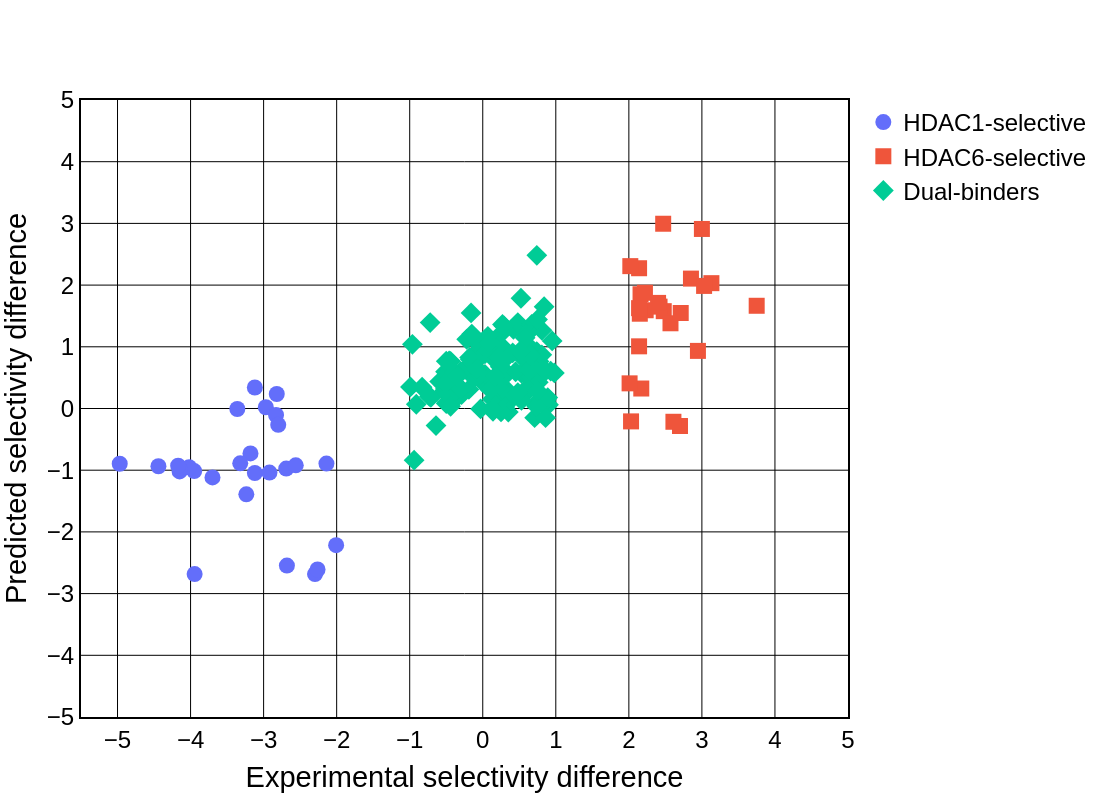

In [54]:
# plot hdac1-selective, hdac6-selective and dual selective compounds in predicted vs experimental plot
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)


#fig = px.scatter(df=HDAC1and6_ref_pred_DF_hdac1Sel, x="SelectivityWindow", y="RF", )
#fig.show() 

dfs = {"HDAC1-selective" : SW_reg_hdac1Sel, "HDAC6-selective": SW_reg_hdac6Sel, "Dual-binders" : SW_reg_dual}




# plot the data
fig = go.Figure()

for i in dfs:
    fig = fig.add_trace(go.Scatter(x = dfs[i]["SelectivityWindow"],
                                   y = dfs[i]["SW_ave"], 
                                   name = i,mode="markers",marker=dict(size=16, symbol = dfs[i]['Marker']) ), )

fig.update_layout(
    autosize=False,
    width=1000,
    height=800,
    xaxis_title="Experimental selectivity difference",
    yaxis_title="Predicted selectivity difference",
    template= "plotly_white",
    
    font=dict(
        #family="Courier New, monospace",
        size=24,
        color="Black"
    )
) 
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', dtick=1, showgrid=True, zeroline=True, mirror=True, zerolinecolor='black',
       zerolinewidth=1, gridwidth=1, gridcolor='black', range=[-5.5, 5])
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', dtick=1, showgrid=True, zeroline=True, mirror=True, zerolinecolor='black',
       zerolinewidth=1, gridwidth=1, gridcolor='black', range=[-5, 5])

#fig.add_shape( # add a horizontal "target" line
#    type="line", line_color="salmon", line_width=3, opacity=1, line_dash="dot",
#    x0=-4, x1=5, y0=2, y1=2, )

#fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)', 'paper_bgcolor': 'rgba(0, 0, 0, 0)',
#})

fig.show()

## Selectivity Window Evaluate Each Class Separately 

In [55]:
SelWin_rf_HDAC1Sel = selectivity_window_reg.copy()
SelWin_rf_HDAC1Sel['selectivity'] = np.zeros(len(SelWin_rf_HDAC1Sel))
SelWin_rf_HDAC1Sel.loc[SelWin_rf_HDAC1Sel[SelWin_rf_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelWin_rf_HDAC1Sel.loc[SelWin_rf_HDAC1Sel[SelWin_rf_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_rf_HDAC1Sel['HDAC1_SW_rf'] = np.zeros(len(SelWin_rf_HDAC1Sel))
SelWin_rf_HDAC1Sel.loc[SelWin_rf_HDAC1Sel[(SelWin_rf_HDAC1Sel['SW_rf'] <= -1.0)].index, 'HDAC1_SW_rf'] = 1
SW_HDAC1Sel = SelWin_rf_HDAC1Sel['selectivity']
SW_HDAC1Sel_rf = SelWin_rf_HDAC1Sel['HDAC1_SW_rf']
conf_matrix_HDAC1Sel_rf=confusion_matrix(SW_HDAC1Sel, SW_HDAC1Sel_rf)
TP_HDAC1Sel_rf = conf_matrix_HDAC1Sel_rf[1][1]
TN_HDAC1Sel_rf = conf_matrix_HDAC1Sel_rf[0][0]
FP_HDAC1Sel_rf = conf_matrix_HDAC1Sel_rf[0][1] 
FN_HDAC1Sel_rf = conf_matrix_HDAC1Sel_rf[1][0]
Accuracy_HDAC1Sel_rf = accuracy_score(SW_HDAC1Sel,SW_HDAC1Sel_rf)
Precision_HDAC1Sel_rf = precision_score(SW_HDAC1Sel, SW_HDAC1Sel_rf)
Sensitivity_HDAC1Sel_rf = recall_score(SW_HDAC1Sel, SW_HDAC1Sel_rf)
SWecificity_HDAC1Sel_rf = round( TN_HDAC1Sel_rf/ (TN_HDAC1Sel_rf+FP_HDAC1Sel_rf),4 )
f1_scores_HDAC1Sel_rf = f1_score(SW_HDAC1Sel, SW_HDAC1Sel_rf)
f1_scores_M_HDAC1Sel_rf = f1_score(SW_HDAC1Sel, SW_HDAC1Sel_rf, average="macro")
BA_scores_HDAC1Sel_rf = balanced_accuracy_score(SW_HDAC1Sel, SW_HDAC1Sel_rf)
MCC_HDAC1Sel_rf = matthews_corrcoef(SW_HDAC1Sel, SW_HDAC1Sel_rf)
NPV_HDAC1Sel_rf= round( TN_HDAC1Sel_rf / (TN_HDAC1Sel_rf+FN_HDAC1Sel_rf),4 )
ROC_AUC_HDAC1Sel_rf = roc_auc_score(SW_HDAC1Sel, SW_HDAC1Sel_rf)
mat_met_SW_rf = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','SWecificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'RF(HDAC1-binder)':[np.mean(TP_HDAC1Sel_rf),np.mean(TN_HDAC1Sel_rf),np.mean(FP_HDAC1Sel_rf),
                 np.mean(FN_HDAC1Sel_rf),np.mean(Accuracy_HDAC1Sel_rf),np.mean(Precision_HDAC1Sel_rf),
                 np.mean(Sensitivity_HDAC1Sel_rf),np.mean(SWecificity_HDAC1Sel_rf),np.mean(f1_scores_HDAC1Sel_rf),
                 np.mean(f1_scores_M_HDAC1Sel_rf), np.mean(BA_scores_HDAC1Sel_rf),np.mean(MCC_HDAC1Sel_rf),
                 np.mean(NPV_HDAC1Sel_rf), np.mean(ROC_AUC_HDAC1Sel_rf)]}) 


SelWin_rf_HDAC6Sel = selectivity_window_reg.copy()
SelWin_rf_HDAC6Sel['selectivity'] = np.zeros(len(SelWin_rf_HDAC6Sel))
SelWin_rf_HDAC6Sel.loc[SelWin_rf_HDAC6Sel[SelWin_rf_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelWin_rf_HDAC6Sel.loc[SelWin_rf_HDAC6Sel[SelWin_rf_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_rf_HDAC6Sel['HDAC6_SW_rf'] = np.zeros(len(SelWin_rf_HDAC6Sel))
SelWin_rf_HDAC6Sel.loc[SelWin_rf_HDAC6Sel[(SelWin_rf_HDAC6Sel['SW_rf'] >= 1.5)].index, 'HDAC6_SW_rf'] = 1
SW_HDAC6Sel = SelWin_rf_HDAC6Sel['selectivity']
SW_HDAC6Sel_rf = SelWin_rf_HDAC6Sel['HDAC6_SW_rf']
conf_matrix_HDAC6Sel_rf=confusion_matrix(SW_HDAC6Sel, SW_HDAC6Sel_rf)
TP_HDAC6Sel_rf = conf_matrix_HDAC6Sel_rf[1][1]
TN_HDAC6Sel_rf = conf_matrix_HDAC6Sel_rf[0][0]
FP_HDAC6Sel_rf = conf_matrix_HDAC6Sel_rf[0][1] 
FN_HDAC6Sel_rf = conf_matrix_HDAC6Sel_rf[1][0]
Accuracy_HDAC6Sel_rf = accuracy_score(SW_HDAC6Sel,SW_HDAC6Sel_rf)
Precision_HDAC6Sel_rf = precision_score(SW_HDAC6Sel, SW_HDAC6Sel_rf)
Sensitivity_HDAC6Sel_rf = recall_score(SW_HDAC6Sel, SW_HDAC6Sel_rf)
SWecificity_HDAC6Sel_rf = round( TN_HDAC6Sel_rf/ (TN_HDAC6Sel_rf+FP_HDAC6Sel_rf),4 )
f1_scores_HDAC6Sel_rf = f1_score(SW_HDAC6Sel, SW_HDAC6Sel_rf)
f1_scores_M_HDAC6Sel_rf = f1_score(SW_HDAC6Sel, SW_HDAC6Sel_rf, average="macro")
BA_scores_HDAC6Sel_rf = balanced_accuracy_score(SW_HDAC6Sel, SW_HDAC6Sel_rf)
MCC_HDAC6Sel_rf = matthews_corrcoef(SW_HDAC6Sel, SW_HDAC6Sel_rf)
NPV_HDAC6Sel_rf= round( TN_HDAC6Sel_rf / (TN_HDAC6Sel_rf+FN_HDAC6Sel_rf),4 )
ROC_AUC_HDAC6Sel_rf = roc_auc_score(SW_HDAC6Sel, SW_HDAC6Sel_rf)
HDAC6_SW_rf_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','SWecificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'RF(HDAC6-binder)':[np.mean(TP_HDAC6Sel_rf),np.mean(TN_HDAC6Sel_rf),np.mean(FP_HDAC6Sel_rf),
                 np.mean(FN_HDAC6Sel_rf),np.mean(Accuracy_HDAC6Sel_rf),np.mean(Precision_HDAC6Sel_rf),
                 np.mean(Sensitivity_HDAC6Sel_rf),np.mean(SWecificity_HDAC6Sel_rf),np.mean(f1_scores_HDAC6Sel_rf),
                 np.mean(f1_scores_M_HDAC6Sel_rf), np.mean(BA_scores_HDAC6Sel_rf),np.mean(MCC_HDAC6Sel_rf),
                 np.mean(NPV_HDAC6Sel_rf), np.mean(ROC_AUC_HDAC6Sel_rf)]}) 
mat_met_SW_rf = mat_met_SW_rf.merge(HDAC6_SW_rf_ave, on='Metric')


SelWin_rf_DualSel = selectivity_window_reg.copy()
SelWin_rf_DualSel['selectivity'] = np.zeros(len(SelWin_rf_DualSel))
SelWin_rf_DualSel.loc[SelWin_rf_DualSel[SelWin_rf_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelWin_rf_DualSel.loc[SelWin_rf_DualSel[SelWin_rf_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_rf_DualSel['Dual_SW_rf'] = np.zeros(len(SelWin_rf_DualSel))
SelWin_rf_DualSel.loc[SelWin_rf_DualSel[(SelWin_rf_DualSel['SW_rf'] >= -1)  & (SelWin_rf_DualSel['SW_rf'] <= 1)].index, 'Dual_SW_rf'] = 1
SW_DualSel = SelWin_rf_DualSel['selectivity']
SW_DualSel_rf = SelWin_rf_DualSel['Dual_SW_rf']
conf_matrix_DualSel_rf=confusion_matrix(SW_DualSel, SW_DualSel_rf)
TP_DualSel_rf = conf_matrix_DualSel_rf[1][1]
TN_DualSel_rf = conf_matrix_DualSel_rf[0][0]
FP_DualSel_rf = conf_matrix_DualSel_rf[0][1] 
FN_DualSel_rf = conf_matrix_DualSel_rf[1][0]
Accuracy_DualSel_rf = accuracy_score(SW_DualSel,SW_DualSel_rf)
Precision_DualSel_rf = precision_score(SW_DualSel, SW_DualSel_rf)
Sensitivity_DualSel_rf = recall_score(SW_DualSel, SW_DualSel_rf)
SWecificity_DualSel_rf = round( TN_DualSel_rf/ (TN_DualSel_rf+FP_DualSel_rf),4 )
f1_scores_DualSel_rf = f1_score(SW_DualSel, SW_DualSel_rf)
f1_scores_M_DualSel_rf = f1_score(SW_DualSel, SW_DualSel_rf, average="macro")
BA_scores_DualSel_rf = balanced_accuracy_score(SW_DualSel, SW_DualSel_rf)
MCC_DualSel_rf = matthews_corrcoef(SW_DualSel, SW_DualSel_rf)
NPV_DualSel_rf= round( TN_DualSel_rf / (TN_DualSel_rf+FN_DualSel_rf),4 )
ROC_AUC_DualSel_rf = roc_auc_score(SW_DualSel, SW_DualSel_rf)
Dual_SW_rf_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','SWecificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'RF(Dual-binder)':[np.mean(TP_DualSel_rf),np.mean(TN_DualSel_rf),np.mean(FP_DualSel_rf),
                 np.mean(FN_DualSel_rf),np.mean(Accuracy_DualSel_rf),np.mean(Precision_DualSel_rf),
                 np.mean(Sensitivity_DualSel_rf),np.mean(SWecificity_DualSel_rf),np.mean(f1_scores_DualSel_rf),
                 np.mean(f1_scores_M_DualSel_rf), np.mean(BA_scores_DualSel_rf),np.mean(MCC_DualSel_rf),
                 np.mean(NPV_DualSel_rf), np.mean(ROC_AUC_DualSel_rf)]}) 
mat_met_SW_rf = mat_met_SW_rf.merge(Dual_SW_rf_ave, on='Metric')
mat_met_SW_rf

,Metric,RF(HDAC1-binder),RF(HDAC6-binder),RF(Dual-binder)
0,TP,6.000000,11.000000,112.000000
1,TN,389.000000,346.000000,108.000000
2,FP,4.000000,48.000000,175.000000
3,FN,21.000000,15.000000,25.000000
4,Accuracy,0.940476,0.850000,0.523810
5,Precision,0.600000,0.186441,0.390244
6,Sensitivity,0.222222,0.423077,0.817518
7,SWecificity,0.989800,0.878200,0.381600
8,F1 score,0.324324,0.258824,0.528302
9,F1 score (macro),0.646596,0.587690,0.523766


In [56]:
SelWin_lgbm_HDAC1Sel = selectivity_window_reg.copy()
SelWin_lgbm_HDAC1Sel['selectivity'] = np.zeros(len(SelWin_lgbm_HDAC1Sel))
SelWin_lgbm_HDAC1Sel.loc[SelWin_lgbm_HDAC1Sel[SelWin_lgbm_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelWin_lgbm_HDAC1Sel.loc[SelWin_lgbm_HDAC1Sel[SelWin_lgbm_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_lgbm_HDAC1Sel['HDAC1_SW_lgbm'] = np.zeros(len(SelWin_lgbm_HDAC1Sel))
SelWin_lgbm_HDAC1Sel.loc[SelWin_lgbm_HDAC1Sel[(SelWin_lgbm_HDAC1Sel['SW_lgbm'] <= -1.0)].index, 'HDAC1_SW_lgbm'] = 1
SW_HDAC1Sel = SelWin_lgbm_HDAC1Sel['selectivity']
SW_HDAC1Sel_lgbm = SelWin_lgbm_HDAC1Sel['HDAC1_SW_lgbm']
conf_matrix_HDAC1Sel_lgbm=confusion_matrix(SW_HDAC1Sel, SW_HDAC1Sel_lgbm)
TP_HDAC1Sel_lgbm = conf_matrix_HDAC1Sel_lgbm[1][1]
TN_HDAC1Sel_lgbm = conf_matrix_HDAC1Sel_lgbm[0][0]
FP_HDAC1Sel_lgbm = conf_matrix_HDAC1Sel_lgbm[0][1] 
FN_HDAC1Sel_lgbm = conf_matrix_HDAC1Sel_lgbm[1][0]
Accuracy_HDAC1Sel_lgbm = accuracy_score(SW_HDAC1Sel,SW_HDAC1Sel_lgbm)
Precision_HDAC1Sel_lgbm = precision_score(SW_HDAC1Sel, SW_HDAC1Sel_lgbm)
Sensitivity_HDAC1Sel_lgbm = recall_score(SW_HDAC1Sel, SW_HDAC1Sel_lgbm)
SWecificity_HDAC1Sel_lgbm = round( TN_HDAC1Sel_lgbm/ (TN_HDAC1Sel_lgbm+FP_HDAC1Sel_lgbm),4 )
f1_scores_HDAC1Sel_lgbm = f1_score(SW_HDAC1Sel, SW_HDAC1Sel_lgbm)
f1_scores_M_HDAC1Sel_lgbm = f1_score(SW_HDAC1Sel, SW_HDAC1Sel_lgbm, average="macro")
BA_scores_HDAC1Sel_lgbm = balanced_accuracy_score(SW_HDAC1Sel, SW_HDAC1Sel_lgbm)
MCC_HDAC1Sel_lgbm = matthews_corrcoef(SW_HDAC1Sel, SW_HDAC1Sel_lgbm)
NPV_HDAC1Sel_lgbm= round( TN_HDAC1Sel_lgbm / (TN_HDAC1Sel_lgbm+FN_HDAC1Sel_lgbm),4 )
ROC_AUC_HDAC1Sel_lgbm = roc_auc_score(SW_HDAC1Sel, SW_HDAC1Sel_lgbm)
mat_met_SW_lgbm = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','SWecificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'lgbm(HDAC1-binder)':[np.mean(TP_HDAC1Sel_lgbm),np.mean(TN_HDAC1Sel_lgbm),np.mean(FP_HDAC1Sel_lgbm),
                 np.mean(FN_HDAC1Sel_lgbm),np.mean(Accuracy_HDAC1Sel_lgbm),np.mean(Precision_HDAC1Sel_lgbm),
                 np.mean(Sensitivity_HDAC1Sel_lgbm),np.mean(SWecificity_HDAC1Sel_lgbm),np.mean(f1_scores_HDAC1Sel_lgbm),
                 np.mean(f1_scores_M_HDAC1Sel_lgbm), np.mean(BA_scores_HDAC1Sel_lgbm),np.mean(MCC_HDAC1Sel_lgbm),
                 np.mean(NPV_HDAC1Sel_lgbm), np.mean(ROC_AUC_HDAC1Sel_lgbm)]}) 


SelWin_lgbm_HDAC6Sel = selectivity_window_reg.copy()
SelWin_lgbm_HDAC6Sel['selectivity'] = np.zeros(len(SelWin_lgbm_HDAC6Sel))
SelWin_lgbm_HDAC6Sel.loc[SelWin_lgbm_HDAC6Sel[SelWin_lgbm_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelWin_lgbm_HDAC6Sel.loc[SelWin_lgbm_HDAC6Sel[SelWin_lgbm_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_lgbm_HDAC6Sel['HDAC6_SW_lgbm'] = np.zeros(len(SelWin_lgbm_HDAC6Sel))
SelWin_lgbm_HDAC6Sel.loc[SelWin_lgbm_HDAC6Sel[(SelWin_lgbm_HDAC6Sel['SW_lgbm'] >= 1.5)].index, 'HDAC6_SW_lgbm'] = 1
SW_HDAC6Sel = SelWin_lgbm_HDAC6Sel['selectivity']
SW_HDAC6Sel_lgbm = SelWin_lgbm_HDAC6Sel['HDAC6_SW_lgbm']
conf_matrix_HDAC6Sel_lgbm=confusion_matrix(SW_HDAC6Sel, SW_HDAC6Sel_lgbm)
TP_HDAC6Sel_lgbm = conf_matrix_HDAC6Sel_lgbm[1][1]
TN_HDAC6Sel_lgbm = conf_matrix_HDAC6Sel_lgbm[0][0]
FP_HDAC6Sel_lgbm = conf_matrix_HDAC6Sel_lgbm[0][1] 
FN_HDAC6Sel_lgbm = conf_matrix_HDAC6Sel_lgbm[1][0]
Accuracy_HDAC6Sel_lgbm = accuracy_score(SW_HDAC6Sel,SW_HDAC6Sel_lgbm)
Precision_HDAC6Sel_lgbm = precision_score(SW_HDAC6Sel, SW_HDAC6Sel_lgbm)
Sensitivity_HDAC6Sel_lgbm = recall_score(SW_HDAC6Sel, SW_HDAC6Sel_lgbm)
SWecificity_HDAC6Sel_lgbm = round( TN_HDAC6Sel_lgbm/ (TN_HDAC6Sel_lgbm+FP_HDAC6Sel_lgbm),4 )
f1_scores_HDAC6Sel_lgbm = f1_score(SW_HDAC6Sel, SW_HDAC6Sel_lgbm)
f1_scores_M_HDAC6Sel_lgbm = f1_score(SW_HDAC6Sel, SW_HDAC6Sel_lgbm, average="macro")
BA_scores_HDAC6Sel_lgbm = balanced_accuracy_score(SW_HDAC6Sel, SW_HDAC6Sel_lgbm)
MCC_HDAC6Sel_lgbm = matthews_corrcoef(SW_HDAC6Sel, SW_HDAC6Sel_lgbm)
NPV_HDAC6Sel_lgbm= round( TN_HDAC6Sel_lgbm / (TN_HDAC6Sel_lgbm+FN_HDAC6Sel_lgbm),4 )
ROC_AUC_HDAC6Sel_lgbm = roc_auc_score(SW_HDAC6Sel, SW_HDAC6Sel_lgbm)
HDAC6_SW_lgbm_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','SWecificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'lgbm(HDAC6-binder)':[np.mean(TP_HDAC6Sel_lgbm),np.mean(TN_HDAC6Sel_lgbm),np.mean(FP_HDAC6Sel_lgbm),
                 np.mean(FN_HDAC6Sel_lgbm),np.mean(Accuracy_HDAC6Sel_lgbm),np.mean(Precision_HDAC6Sel_lgbm),
                 np.mean(Sensitivity_HDAC6Sel_lgbm),np.mean(SWecificity_HDAC6Sel_lgbm),np.mean(f1_scores_HDAC6Sel_lgbm),
                 np.mean(f1_scores_M_HDAC6Sel_lgbm), np.mean(BA_scores_HDAC6Sel_lgbm),np.mean(MCC_HDAC6Sel_lgbm),
                 np.mean(NPV_HDAC6Sel_lgbm), np.mean(ROC_AUC_HDAC6Sel_lgbm)]}) 
mat_met_SW_lgbm = mat_met_SW_lgbm.merge(HDAC6_SW_lgbm_ave, on='Metric')


SelWin_lgbm_DualSel = selectivity_window_reg.copy()
SelWin_lgbm_DualSel['selectivity'] = np.zeros(len(SelWin_lgbm_DualSel))
SelWin_lgbm_DualSel.loc[SelWin_lgbm_DualSel[SelWin_lgbm_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelWin_lgbm_DualSel.loc[SelWin_lgbm_DualSel[SelWin_lgbm_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_lgbm_DualSel['Dual_SW_lgbm'] = np.zeros(len(SelWin_lgbm_DualSel))
SelWin_lgbm_DualSel.loc[SelWin_lgbm_DualSel[(SelWin_lgbm_DualSel['SW_lgbm'] >= -1)  & (SelWin_lgbm_DualSel['SW_lgbm'] <= 1)].index, 'Dual_SW_lgbm'] = 1
SW_DualSel = SelWin_lgbm_DualSel['selectivity']
SW_DualSel_lgbm = SelWin_lgbm_DualSel['Dual_SW_lgbm']
conf_matrix_DualSel_lgbm=confusion_matrix(SW_DualSel, SW_DualSel_lgbm)
TP_DualSel_lgbm = conf_matrix_DualSel_lgbm[1][1]
TN_DualSel_lgbm = conf_matrix_DualSel_lgbm[0][0]
FP_DualSel_lgbm = conf_matrix_DualSel_lgbm[0][1] 
FN_DualSel_lgbm = conf_matrix_DualSel_lgbm[1][0]
Accuracy_DualSel_lgbm = accuracy_score(SW_DualSel,SW_DualSel_lgbm)
Precision_DualSel_lgbm = precision_score(SW_DualSel, SW_DualSel_lgbm)
Sensitivity_DualSel_lgbm = recall_score(SW_DualSel, SW_DualSel_lgbm)
SWecificity_DualSel_lgbm = round( TN_DualSel_lgbm/ (TN_DualSel_lgbm+FP_DualSel_lgbm),4 )
f1_scores_DualSel_lgbm = f1_score(SW_DualSel, SW_DualSel_lgbm)
f1_scores_M_DualSel_lgbm = f1_score(SW_DualSel, SW_DualSel_lgbm, average="macro")
BA_scores_DualSel_lgbm = balanced_accuracy_score(SW_DualSel, SW_DualSel_lgbm)
MCC_DualSel_lgbm = matthews_corrcoef(SW_DualSel, SW_DualSel_lgbm)
NPV_DualSel_lgbm= round( TN_DualSel_lgbm / (TN_DualSel_lgbm+FN_DualSel_lgbm),4 )
ROC_AUC_DualSel_lgbm = roc_auc_score(SW_DualSel, SW_DualSel_lgbm)
Dual_SW_lgbm_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','SWecificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'lgbm(Dual-binder)':[np.mean(TP_DualSel_lgbm),np.mean(TN_DualSel_lgbm),np.mean(FP_DualSel_lgbm),
                 np.mean(FN_DualSel_lgbm),np.mean(Accuracy_DualSel_lgbm),np.mean(Precision_DualSel_lgbm),
                 np.mean(Sensitivity_DualSel_lgbm),np.mean(SWecificity_DualSel_lgbm),np.mean(f1_scores_DualSel_lgbm),
                 np.mean(f1_scores_M_DualSel_lgbm), np.mean(BA_scores_DualSel_lgbm),np.mean(MCC_DualSel_lgbm),
                 np.mean(NPV_DualSel_lgbm), np.mean(ROC_AUC_DualSel_lgbm)]}) 
mat_met_SW_lgbm = mat_met_SW_lgbm.merge(Dual_SW_lgbm_ave, on='Metric')
mat_met_SW_lgbm

,Metric,lgbm(HDAC1-binder),lgbm(HDAC6-binder),lgbm(Dual-binder)
0,TP,20.000000,15.000000,105.000000
1,TN,382.000000,332.000000,145.000000
2,FP,11.000000,62.000000,138.000000
3,FN,7.000000,11.000000,32.000000
4,Accuracy,0.957143,0.826190,0.595238
5,Precision,0.645161,0.194805,0.432099
6,Sensitivity,0.740741,0.576923,0.766423
7,SWecificity,0.972000,0.842600,0.512400
8,F1 score,0.689655,0.291262,0.552632
9,F1 score (macro),0.833319,0.596106,0.591533


In [57]:
SelWin_xgb_HDAC1Sel = selectivity_window_reg.copy()
SelWin_xgb_HDAC1Sel['selectivity'] = np.zeros(len(SelWin_xgb_HDAC1Sel))
SelWin_xgb_HDAC1Sel.loc[SelWin_xgb_HDAC1Sel[SelWin_xgb_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelWin_xgb_HDAC1Sel.loc[SelWin_xgb_HDAC1Sel[SelWin_xgb_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_xgb_HDAC1Sel['HDAC1_SW_xgb'] = np.zeros(len(SelWin_xgb_HDAC1Sel))
SelWin_xgb_HDAC1Sel.loc[SelWin_xgb_HDAC1Sel[(SelWin_xgb_HDAC1Sel['SW_xgb'] <= -1.0)].index, 'HDAC1_SW_xgb'] = 1
SW_HDAC1Sel = SelWin_xgb_HDAC1Sel['selectivity']
SW_HDAC1Sel_xgb = SelWin_xgb_HDAC1Sel['HDAC1_SW_xgb']
conf_matrix_HDAC1Sel_xgb=confusion_matrix(SW_HDAC1Sel, SW_HDAC1Sel_xgb)
TP_HDAC1Sel_xgb = conf_matrix_HDAC1Sel_xgb[1][1]
TN_HDAC1Sel_xgb = conf_matrix_HDAC1Sel_xgb[0][0]
FP_HDAC1Sel_xgb = conf_matrix_HDAC1Sel_xgb[0][1] 
FN_HDAC1Sel_xgb = conf_matrix_HDAC1Sel_xgb[1][0]
Accuracy_HDAC1Sel_xgb = accuracy_score(SW_HDAC1Sel,SW_HDAC1Sel_xgb)
Precision_HDAC1Sel_xgb = precision_score(SW_HDAC1Sel, SW_HDAC1Sel_xgb)
Sensitivity_HDAC1Sel_xgb = recall_score(SW_HDAC1Sel, SW_HDAC1Sel_xgb)
SWecificity_HDAC1Sel_xgb = round( TN_HDAC1Sel_xgb/ (TN_HDAC1Sel_xgb+FP_HDAC1Sel_xgb),4 )
f1_scores_HDAC1Sel_xgb = f1_score(SW_HDAC1Sel, SW_HDAC1Sel_xgb)
f1_scores_M_HDAC1Sel_xgb = f1_score(SW_HDAC1Sel, SW_HDAC1Sel_xgb, average="macro")
BA_scores_HDAC1Sel_xgb = balanced_accuracy_score(SW_HDAC1Sel, SW_HDAC1Sel_xgb)
MCC_HDAC1Sel_xgb = matthews_corrcoef(SW_HDAC1Sel, SW_HDAC1Sel_xgb)
NPV_HDAC1Sel_xgb= round( TN_HDAC1Sel_xgb / (TN_HDAC1Sel_xgb+FN_HDAC1Sel_xgb),4 )
ROC_AUC_HDAC1Sel_xgb = roc_auc_score(SW_HDAC1Sel, SW_HDAC1Sel_xgb)
mat_met_SW_xgb = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','SWecificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'xgb(HDAC1-binder)':[np.mean(TP_HDAC1Sel_xgb),np.mean(TN_HDAC1Sel_xgb),np.mean(FP_HDAC1Sel_xgb),
                 np.mean(FN_HDAC1Sel_xgb),np.mean(Accuracy_HDAC1Sel_xgb),np.mean(Precision_HDAC1Sel_xgb),
                 np.mean(Sensitivity_HDAC1Sel_xgb),np.mean(SWecificity_HDAC1Sel_xgb),np.mean(f1_scores_HDAC1Sel_xgb),
                 np.mean(f1_scores_M_HDAC1Sel_xgb), np.mean(BA_scores_HDAC1Sel_xgb),np.mean(MCC_HDAC1Sel_xgb),
                 np.mean(NPV_HDAC1Sel_xgb), np.mean(ROC_AUC_HDAC1Sel_xgb)]}) 


SelWin_xgb_HDAC6Sel = selectivity_window_reg.copy()
SelWin_xgb_HDAC6Sel['selectivity'] = np.zeros(len(SelWin_xgb_HDAC6Sel))
SelWin_xgb_HDAC6Sel.loc[SelWin_xgb_HDAC6Sel[SelWin_xgb_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelWin_xgb_HDAC6Sel.loc[SelWin_xgb_HDAC6Sel[SelWin_xgb_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_xgb_HDAC6Sel['HDAC6_SW_xgb'] = np.zeros(len(SelWin_xgb_HDAC6Sel))
SelWin_xgb_HDAC6Sel.loc[SelWin_xgb_HDAC6Sel[(SelWin_xgb_HDAC6Sel['SW_xgb'] >= 1.5)].index, 'HDAC6_SW_xgb'] = 1
SW_HDAC6Sel = SelWin_xgb_HDAC6Sel['selectivity']
SW_HDAC6Sel_xgb = SelWin_xgb_HDAC6Sel['HDAC6_SW_xgb']
conf_matrix_HDAC6Sel_xgb=confusion_matrix(SW_HDAC6Sel, SW_HDAC6Sel_xgb)
TP_HDAC6Sel_xgb = conf_matrix_HDAC6Sel_xgb[1][1]
TN_HDAC6Sel_xgb = conf_matrix_HDAC6Sel_xgb[0][0]
FP_HDAC6Sel_xgb = conf_matrix_HDAC6Sel_xgb[0][1] 
FN_HDAC6Sel_xgb = conf_matrix_HDAC6Sel_xgb[1][0]
Accuracy_HDAC6Sel_xgb = accuracy_score(SW_HDAC6Sel,SW_HDAC6Sel_xgb)
Precision_HDAC6Sel_xgb = precision_score(SW_HDAC6Sel, SW_HDAC6Sel_xgb)
Sensitivity_HDAC6Sel_xgb = recall_score(SW_HDAC6Sel, SW_HDAC6Sel_xgb)
SWecificity_HDAC6Sel_xgb = round( TN_HDAC6Sel_xgb/ (TN_HDAC6Sel_xgb+FP_HDAC6Sel_xgb),4 )
f1_scores_HDAC6Sel_xgb = f1_score(SW_HDAC6Sel, SW_HDAC6Sel_xgb)
f1_scores_M_HDAC6Sel_xgb = f1_score(SW_HDAC6Sel, SW_HDAC6Sel_xgb, average="macro")
BA_scores_HDAC6Sel_xgb = balanced_accuracy_score(SW_HDAC6Sel, SW_HDAC6Sel_xgb)
MCC_HDAC6Sel_xgb = matthews_corrcoef(SW_HDAC6Sel, SW_HDAC6Sel_xgb)
NPV_HDAC6Sel_xgb= round( TN_HDAC6Sel_xgb / (TN_HDAC6Sel_xgb+FN_HDAC6Sel_xgb),4 )
ROC_AUC_HDAC6Sel_xgb = roc_auc_score(SW_HDAC6Sel, SW_HDAC6Sel_xgb)
HDAC6_SW_xgb_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','SWecificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'xgb(HDAC6-binder)':[np.mean(TP_HDAC6Sel_xgb),np.mean(TN_HDAC6Sel_xgb),np.mean(FP_HDAC6Sel_xgb),
                 np.mean(FN_HDAC6Sel_xgb),np.mean(Accuracy_HDAC6Sel_xgb),np.mean(Precision_HDAC6Sel_xgb),
                 np.mean(Sensitivity_HDAC6Sel_xgb),np.mean(SWecificity_HDAC6Sel_xgb),np.mean(f1_scores_HDAC6Sel_xgb),
                 np.mean(f1_scores_M_HDAC6Sel_xgb), np.mean(BA_scores_HDAC6Sel_xgb),np.mean(MCC_HDAC6Sel_xgb),
                 np.mean(NPV_HDAC6Sel_xgb), np.mean(ROC_AUC_HDAC6Sel_xgb)]}) 
mat_met_SW_xgb = mat_met_SW_xgb.merge(HDAC6_SW_xgb_ave, on='Metric')


SelWin_xgb_DualSel = selectivity_window_reg.copy()
SelWin_xgb_DualSel['selectivity'] = np.zeros(len(SelWin_xgb_DualSel))
SelWin_xgb_DualSel.loc[SelWin_xgb_DualSel[SelWin_xgb_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelWin_xgb_DualSel.loc[SelWin_xgb_DualSel[SelWin_xgb_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_xgb_DualSel['Dual_SW_xgb'] = np.zeros(len(SelWin_xgb_DualSel))
SelWin_xgb_DualSel.loc[SelWin_xgb_DualSel[(SelWin_xgb_DualSel['SW_xgb'] >= -1)  & (SelWin_xgb_DualSel['SW_xgb'] <= 1)].index, 'Dual_SW_xgb'] = 1
SW_DualSel = SelWin_xgb_DualSel['selectivity']
SW_DualSel_xgb = SelWin_xgb_DualSel['Dual_SW_xgb']
conf_matrix_DualSel_xgb=confusion_matrix(SW_DualSel, SW_DualSel_xgb)
TP_DualSel_xgb = conf_matrix_DualSel_xgb[1][1]
TN_DualSel_xgb = conf_matrix_DualSel_xgb[0][0]
FP_DualSel_xgb = conf_matrix_DualSel_xgb[0][1] 
FN_DualSel_xgb = conf_matrix_DualSel_xgb[1][0]
Accuracy_DualSel_xgb = accuracy_score(SW_DualSel,SW_DualSel_xgb)
Precision_DualSel_xgb = precision_score(SW_DualSel, SW_DualSel_xgb)
Sensitivity_DualSel_xgb = recall_score(SW_DualSel, SW_DualSel_xgb)
SWecificity_DualSel_xgb = round( TN_DualSel_xgb/ (TN_DualSel_xgb+FP_DualSel_xgb),4 )
f1_scores_DualSel_xgb = f1_score(SW_DualSel, SW_DualSel_xgb)
f1_scores_M_DualSel_xgb = f1_score(SW_DualSel, SW_DualSel_xgb, average="macro")
BA_scores_DualSel_xgb = balanced_accuracy_score(SW_DualSel, SW_DualSel_xgb)
MCC_DualSel_xgb = matthews_corrcoef(SW_DualSel, SW_DualSel_xgb)
NPV_DualSel_xgb= round( TN_DualSel_xgb / (TN_DualSel_xgb+FN_DualSel_xgb),4 )
ROC_AUC_DualSel_xgb = roc_auc_score(SW_DualSel, SW_DualSel_xgb)
Dual_SW_xgb_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','SWecificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'xgb(Dual-binder)':[np.mean(TP_DualSel_xgb),np.mean(TN_DualSel_xgb),np.mean(FP_DualSel_xgb),
                 np.mean(FN_DualSel_xgb),np.mean(Accuracy_DualSel_xgb),np.mean(Precision_DualSel_xgb),
                 np.mean(Sensitivity_DualSel_xgb),np.mean(SWecificity_DualSel_xgb),np.mean(f1_scores_DualSel_xgb),
                 np.mean(f1_scores_M_DualSel_xgb), np.mean(BA_scores_DualSel_xgb),np.mean(MCC_DualSel_xgb),
                 np.mean(NPV_DualSel_xgb), np.mean(ROC_AUC_DualSel_xgb)]}) 
mat_met_SW_xgb = mat_met_SW_xgb.merge(Dual_SW_xgb_ave, on='Metric')
mat_met_SW_xgb

,Metric,xgb(HDAC1-binder),xgb(HDAC6-binder),xgb(Dual-binder)
0,TP,18.000000,18.000000,112.000000
1,TN,386.000000,343.000000,129.000000
2,FP,7.000000,51.000000,154.000000
3,FN,9.000000,8.000000,25.000000
4,Accuracy,0.961905,0.859524,0.573810
5,Precision,0.720000,0.260870,0.421053
6,Sensitivity,0.666667,0.692308,0.817518
7,SWecificity,0.982200,0.870600,0.455800
8,F1 score,0.692308,0.378947,0.555831
9,F1 score (macro),0.836002,0.649876,0.573110


In [58]:
SelWin_knn_HDAC1Sel = selectivity_window_reg.copy()
SelWin_knn_HDAC1Sel['selectivity'] = np.zeros(len(SelWin_knn_HDAC1Sel))
SelWin_knn_HDAC1Sel.loc[SelWin_knn_HDAC1Sel[SelWin_knn_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelWin_knn_HDAC1Sel.loc[SelWin_knn_HDAC1Sel[SelWin_knn_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_knn_HDAC1Sel['HDAC1_SW_knn'] = np.zeros(len(SelWin_knn_HDAC1Sel))
SelWin_knn_HDAC1Sel.loc[SelWin_knn_HDAC1Sel[(SelWin_knn_HDAC1Sel['SW_knn'] <= -1.0)].index, 'HDAC1_SW_knn'] = 1
SW_HDAC1Sel = SelWin_knn_HDAC1Sel['selectivity']
SW_HDAC1Sel_knn = SelWin_knn_HDAC1Sel['HDAC1_SW_knn']
conf_matrix_HDAC1Sel_knn=confusion_matrix(SW_HDAC1Sel, SW_HDAC1Sel_knn)
TP_HDAC1Sel_knn = conf_matrix_HDAC1Sel_knn[1][1]
TN_HDAC1Sel_knn = conf_matrix_HDAC1Sel_knn[0][0]
FP_HDAC1Sel_knn = conf_matrix_HDAC1Sel_knn[0][1] 
FN_HDAC1Sel_knn = conf_matrix_HDAC1Sel_knn[1][0]
Accuracy_HDAC1Sel_knn = accuracy_score(SW_HDAC1Sel,SW_HDAC1Sel_knn)
Precision_HDAC1Sel_knn = precision_score(SW_HDAC1Sel, SW_HDAC1Sel_knn)
Sensitivity_HDAC1Sel_knn = recall_score(SW_HDAC1Sel, SW_HDAC1Sel_knn)
SWecificity_HDAC1Sel_knn = round( TN_HDAC1Sel_knn/ (TN_HDAC1Sel_knn+FP_HDAC1Sel_knn),4 )
f1_scores_HDAC1Sel_knn = f1_score(SW_HDAC1Sel, SW_HDAC1Sel_knn)
f1_scores_M_HDAC1Sel_knn = f1_score(SW_HDAC1Sel, SW_HDAC1Sel_knn, average="macro")
BA_scores_HDAC1Sel_knn = balanced_accuracy_score(SW_HDAC1Sel, SW_HDAC1Sel_knn)
MCC_HDAC1Sel_knn = matthews_corrcoef(SW_HDAC1Sel, SW_HDAC1Sel_knn)
NPV_HDAC1Sel_knn= round( TN_HDAC1Sel_knn / (TN_HDAC1Sel_knn+FN_HDAC1Sel_knn),4 )
ROC_AUC_HDAC1Sel_knn = roc_auc_score(SW_HDAC1Sel, SW_HDAC1Sel_knn)
mat_met_SW_knn = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','SWecificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'knn(HDAC1-binder)':[np.mean(TP_HDAC1Sel_knn),np.mean(TN_HDAC1Sel_knn),np.mean(FP_HDAC1Sel_knn),
                 np.mean(FN_HDAC1Sel_knn),np.mean(Accuracy_HDAC1Sel_knn),np.mean(Precision_HDAC1Sel_knn),
                 np.mean(Sensitivity_HDAC1Sel_knn),np.mean(SWecificity_HDAC1Sel_knn),np.mean(f1_scores_HDAC1Sel_knn),
                 np.mean(f1_scores_M_HDAC1Sel_knn), np.mean(BA_scores_HDAC1Sel_knn),np.mean(MCC_HDAC1Sel_knn),
                 np.mean(NPV_HDAC1Sel_knn), np.mean(ROC_AUC_HDAC1Sel_knn)]}) 


SelWin_knn_HDAC6Sel = selectivity_window_reg.copy()
SelWin_knn_HDAC6Sel['selectivity'] = np.zeros(len(SelWin_knn_HDAC6Sel))
SelWin_knn_HDAC6Sel.loc[SelWin_knn_HDAC6Sel[SelWin_knn_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelWin_knn_HDAC6Sel.loc[SelWin_knn_HDAC6Sel[SelWin_knn_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_knn_HDAC6Sel['HDAC6_SW_knn'] = np.zeros(len(SelWin_knn_HDAC6Sel))
SelWin_knn_HDAC6Sel.loc[SelWin_knn_HDAC6Sel[(SelWin_knn_HDAC6Sel['SW_knn'] >= 1.5)].index, 'HDAC6_SW_knn'] = 1
SW_HDAC6Sel = SelWin_knn_HDAC6Sel['selectivity']
SW_HDAC6Sel_knn = SelWin_knn_HDAC6Sel['HDAC6_SW_knn']
conf_matrix_HDAC6Sel_knn=confusion_matrix(SW_HDAC6Sel, SW_HDAC6Sel_knn)
TP_HDAC6Sel_knn = conf_matrix_HDAC6Sel_knn[1][1]
TN_HDAC6Sel_knn = conf_matrix_HDAC6Sel_knn[0][0]
FP_HDAC6Sel_knn = conf_matrix_HDAC6Sel_knn[0][1] 
FN_HDAC6Sel_knn = conf_matrix_HDAC6Sel_knn[1][0]
Accuracy_HDAC6Sel_knn = accuracy_score(SW_HDAC6Sel,SW_HDAC6Sel_knn)
Precision_HDAC6Sel_knn = precision_score(SW_HDAC6Sel, SW_HDAC6Sel_knn)
Sensitivity_HDAC6Sel_knn = recall_score(SW_HDAC6Sel, SW_HDAC6Sel_knn)
SWecificity_HDAC6Sel_knn = round( TN_HDAC6Sel_knn/ (TN_HDAC6Sel_knn+FP_HDAC6Sel_knn),4 )
f1_scores_HDAC6Sel_knn = f1_score(SW_HDAC6Sel, SW_HDAC6Sel_knn)
f1_scores_M_HDAC6Sel_knn = f1_score(SW_HDAC6Sel, SW_HDAC6Sel_knn, average="macro")
BA_scores_HDAC6Sel_knn = balanced_accuracy_score(SW_HDAC6Sel, SW_HDAC6Sel_knn)
MCC_HDAC6Sel_knn = matthews_corrcoef(SW_HDAC6Sel, SW_HDAC6Sel_knn)
NPV_HDAC6Sel_knn= round( TN_HDAC6Sel_knn / (TN_HDAC6Sel_knn+FN_HDAC6Sel_knn),4 )
ROC_AUC_HDAC6Sel_knn = roc_auc_score(SW_HDAC6Sel, SW_HDAC6Sel_knn)
HDAC6_SW_knn_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','SWecificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'knn(HDAC6-binder)':[np.mean(TP_HDAC6Sel_knn),np.mean(TN_HDAC6Sel_knn),np.mean(FP_HDAC6Sel_knn),
                 np.mean(FN_HDAC6Sel_knn),np.mean(Accuracy_HDAC6Sel_knn),np.mean(Precision_HDAC6Sel_knn),
                 np.mean(Sensitivity_HDAC6Sel_knn),np.mean(SWecificity_HDAC6Sel_knn),np.mean(f1_scores_HDAC6Sel_knn),
                 np.mean(f1_scores_M_HDAC6Sel_knn), np.mean(BA_scores_HDAC6Sel_knn),np.mean(MCC_HDAC6Sel_knn),
                 np.mean(NPV_HDAC6Sel_knn), np.mean(ROC_AUC_HDAC6Sel_knn)]}) 
mat_met_SW_knn = mat_met_SW_knn.merge(HDAC6_SW_knn_ave, on='Metric')


SelWin_knn_DualSel = selectivity_window_reg.copy()
SelWin_knn_DualSel['selectivity'] = np.zeros(len(SelWin_knn_DualSel))
SelWin_knn_DualSel.loc[SelWin_knn_DualSel[SelWin_knn_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelWin_knn_DualSel.loc[SelWin_knn_DualSel[SelWin_knn_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_knn_DualSel['Dual_SW_knn'] = np.zeros(len(SelWin_knn_DualSel))
SelWin_knn_DualSel.loc[SelWin_knn_DualSel[(SelWin_knn_DualSel['SW_knn'] >= -1)  & (SelWin_knn_DualSel['SW_knn'] <= 1)].index, 'Dual_SW_knn'] = 1
SW_DualSel = SelWin_knn_DualSel['selectivity']
SW_DualSel_knn = SelWin_knn_DualSel['Dual_SW_knn']
conf_matrix_DualSel_knn=confusion_matrix(SW_DualSel, SW_DualSel_knn)
TP_DualSel_knn = conf_matrix_DualSel_knn[1][1]
TN_DualSel_knn = conf_matrix_DualSel_knn[0][0]
FP_DualSel_knn = conf_matrix_DualSel_knn[0][1] 
FN_DualSel_knn = conf_matrix_DualSel_knn[1][0]
Accuracy_DualSel_knn = accuracy_score(SW_DualSel,SW_DualSel_knn)
Precision_DualSel_knn = precision_score(SW_DualSel, SW_DualSel_knn)
Sensitivity_DualSel_knn = recall_score(SW_DualSel, SW_DualSel_knn)
SWecificity_DualSel_knn = round( TN_DualSel_knn/ (TN_DualSel_knn+FP_DualSel_knn),4 )
f1_scores_DualSel_knn = f1_score(SW_DualSel, SW_DualSel_knn)
f1_scores_M_DualSel_knn = f1_score(SW_DualSel, SW_DualSel_knn, average="macro")
BA_scores_DualSel_knn = balanced_accuracy_score(SW_DualSel, SW_DualSel_knn)
MCC_DualSel_knn = matthews_corrcoef(SW_DualSel, SW_DualSel_knn)
NPV_DualSel_knn= round( TN_DualSel_knn / (TN_DualSel_knn+FN_DualSel_knn),4 )
ROC_AUC_DualSel_knn = roc_auc_score(SW_DualSel, SW_DualSel_knn)
Dual_SW_knn_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','SWecificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'knn(Dual-binder)':[np.mean(TP_DualSel_knn),np.mean(TN_DualSel_knn),np.mean(FP_DualSel_knn),
                 np.mean(FN_DualSel_knn),np.mean(Accuracy_DualSel_knn),np.mean(Precision_DualSel_knn),
                 np.mean(Sensitivity_DualSel_knn),np.mean(SWecificity_DualSel_knn),np.mean(f1_scores_DualSel_knn),
                 np.mean(f1_scores_M_DualSel_knn), np.mean(BA_scores_DualSel_knn),np.mean(MCC_DualSel_knn),
                 np.mean(NPV_DualSel_knn), np.mean(ROC_AUC_DualSel_knn)]}) 
mat_met_SW_knn = mat_met_SW_knn.merge(Dual_SW_knn_ave, on='Metric')
mat_met_SW_knn

,Metric,knn(HDAC1-binder),knn(HDAC6-binder),knn(Dual-binder)
0,TP,20.000000,16.000000,86.000000
1,TN,386.000000,305.000000,174.000000
2,FP,7.000000,89.000000,109.000000
3,FN,7.000000,10.000000,51.000000
4,Accuracy,0.966667,0.764286,0.619048
5,Precision,0.740741,0.152381,0.441026
6,Sensitivity,0.740741,0.615385,0.627737
7,SWecificity,0.982200,0.774100,0.614800
8,F1 score,0.740741,0.244275,0.518072
9,F1 score (macro),0.861465,0.552321,0.601556


In [59]:
SelWin_svm_HDAC1Sel = selectivity_window_reg.copy()
SelWin_svm_HDAC1Sel['selectivity'] = np.zeros(len(SelWin_svm_HDAC1Sel))
SelWin_svm_HDAC1Sel.loc[SelWin_svm_HDAC1Sel[SelWin_svm_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelWin_svm_HDAC1Sel.loc[SelWin_svm_HDAC1Sel[SelWin_svm_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_svm_HDAC1Sel['HDAC1_SW_svm'] = np.zeros(len(SelWin_svm_HDAC1Sel))
SelWin_svm_HDAC1Sel.loc[SelWin_svm_HDAC1Sel[(SelWin_svm_HDAC1Sel['SW_svm'] <= -1.0)].index, 'HDAC1_SW_svm'] = 1
SW_HDAC1Sel = SelWin_svm_HDAC1Sel['selectivity']
SW_HDAC1Sel_svm = SelWin_svm_HDAC1Sel['HDAC1_SW_svm']
conf_matrix_HDAC1Sel_svm=confusion_matrix(SW_HDAC1Sel, SW_HDAC1Sel_svm)
TP_HDAC1Sel_svm = conf_matrix_HDAC1Sel_svm[1][1]
TN_HDAC1Sel_svm = conf_matrix_HDAC1Sel_svm[0][0]
FP_HDAC1Sel_svm = conf_matrix_HDAC1Sel_svm[0][1] 
FN_HDAC1Sel_svm = conf_matrix_HDAC1Sel_svm[1][0]
Accuracy_HDAC1Sel_svm = accuracy_score(SW_HDAC1Sel,SW_HDAC1Sel_svm)
Precision_HDAC1Sel_svm = precision_score(SW_HDAC1Sel, SW_HDAC1Sel_svm)
Sensitivity_HDAC1Sel_svm = recall_score(SW_HDAC1Sel, SW_HDAC1Sel_svm)
SWecificity_HDAC1Sel_svm = round( TN_HDAC1Sel_svm/ (TN_HDAC1Sel_svm+FP_HDAC1Sel_svm),4 )
f1_scores_HDAC1Sel_svm = f1_score(SW_HDAC1Sel, SW_HDAC1Sel_svm)
f1_scores_M_HDAC1Sel_svm = f1_score(SW_HDAC1Sel, SW_HDAC1Sel_svm, average="macro")
BA_scores_HDAC1Sel_svm = balanced_accuracy_score(SW_HDAC1Sel, SW_HDAC1Sel_svm)
MCC_HDAC1Sel_svm = matthews_corrcoef(SW_HDAC1Sel, SW_HDAC1Sel_svm)
NPV_HDAC1Sel_svm= round( TN_HDAC1Sel_svm / (TN_HDAC1Sel_svm+FN_HDAC1Sel_svm),4 )
ROC_AUC_HDAC1Sel_svm = roc_auc_score(SW_HDAC1Sel, SW_HDAC1Sel_svm)
mat_met_SW_svm = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','SWecificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'svm(HDAC1-binder)':[np.mean(TP_HDAC1Sel_svm),np.mean(TN_HDAC1Sel_svm),np.mean(FP_HDAC1Sel_svm),
                 np.mean(FN_HDAC1Sel_svm),np.mean(Accuracy_HDAC1Sel_svm),np.mean(Precision_HDAC1Sel_svm),
                 np.mean(Sensitivity_HDAC1Sel_svm),np.mean(SWecificity_HDAC1Sel_svm),np.mean(f1_scores_HDAC1Sel_svm),
                 np.mean(f1_scores_M_HDAC1Sel_svm), np.mean(BA_scores_HDAC1Sel_svm),np.mean(MCC_HDAC1Sel_svm),
                 np.mean(NPV_HDAC1Sel_svm), np.mean(ROC_AUC_HDAC1Sel_svm)]}) 


SelWin_svm_HDAC6Sel = selectivity_window_reg.copy()
SelWin_svm_HDAC6Sel['selectivity'] = np.zeros(len(SelWin_svm_HDAC6Sel))
SelWin_svm_HDAC6Sel.loc[SelWin_svm_HDAC6Sel[SelWin_svm_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelWin_svm_HDAC6Sel.loc[SelWin_svm_HDAC6Sel[SelWin_svm_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_svm_HDAC6Sel['HDAC6_SW_svm'] = np.zeros(len(SelWin_svm_HDAC6Sel))
SelWin_svm_HDAC6Sel.loc[SelWin_svm_HDAC6Sel[(SelWin_svm_HDAC6Sel['SW_svm'] >= 1.5)].index, 'HDAC6_SW_svm'] = 1
SW_HDAC6Sel = SelWin_svm_HDAC6Sel['selectivity']
SW_HDAC6Sel_svm = SelWin_svm_HDAC6Sel['HDAC6_SW_svm']
conf_matrix_HDAC6Sel_svm=confusion_matrix(SW_HDAC6Sel, SW_HDAC6Sel_svm)
TP_HDAC6Sel_svm = conf_matrix_HDAC6Sel_svm[1][1]
TN_HDAC6Sel_svm = conf_matrix_HDAC6Sel_svm[0][0]
FP_HDAC6Sel_svm = conf_matrix_HDAC6Sel_svm[0][1] 
FN_HDAC6Sel_svm = conf_matrix_HDAC6Sel_svm[1][0]
Accuracy_HDAC6Sel_svm = accuracy_score(SW_HDAC6Sel,SW_HDAC6Sel_svm)
Precision_HDAC6Sel_svm = precision_score(SW_HDAC6Sel, SW_HDAC6Sel_svm)
Sensitivity_HDAC6Sel_svm = recall_score(SW_HDAC6Sel, SW_HDAC6Sel_svm)
SWecificity_HDAC6Sel_svm = round( TN_HDAC6Sel_svm/ (TN_HDAC6Sel_svm+FP_HDAC6Sel_svm),4 )
f1_scores_HDAC6Sel_svm = f1_score(SW_HDAC6Sel, SW_HDAC6Sel_svm)
f1_scores_M_HDAC6Sel_svm = f1_score(SW_HDAC6Sel, SW_HDAC6Sel_svm, average="macro")
BA_scores_HDAC6Sel_svm = balanced_accuracy_score(SW_HDAC6Sel, SW_HDAC6Sel_svm)
MCC_HDAC6Sel_svm = matthews_corrcoef(SW_HDAC6Sel, SW_HDAC6Sel_svm)
NPV_HDAC6Sel_svm= round( TN_HDAC6Sel_svm / (TN_HDAC6Sel_svm+FN_HDAC6Sel_svm),4 )
ROC_AUC_HDAC6Sel_svm = roc_auc_score(SW_HDAC6Sel, SW_HDAC6Sel_svm)
HDAC6_SW_svm_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','SWecificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'svm(HDAC6-binder)':[np.mean(TP_HDAC6Sel_svm),np.mean(TN_HDAC6Sel_svm),np.mean(FP_HDAC6Sel_svm),
                 np.mean(FN_HDAC6Sel_svm),np.mean(Accuracy_HDAC6Sel_svm),np.mean(Precision_HDAC6Sel_svm),
                 np.mean(Sensitivity_HDAC6Sel_svm),np.mean(SWecificity_HDAC6Sel_svm),np.mean(f1_scores_HDAC6Sel_svm),
                 np.mean(f1_scores_M_HDAC6Sel_svm), np.mean(BA_scores_HDAC6Sel_svm),np.mean(MCC_HDAC6Sel_svm),
                 np.mean(NPV_HDAC6Sel_svm), np.mean(ROC_AUC_HDAC6Sel_svm)]}) 
mat_met_SW_svm = mat_met_SW_svm.merge(HDAC6_SW_svm_ave, on='Metric')


SelWin_svm_DualSel = selectivity_window_reg.copy()
SelWin_svm_DualSel['selectivity'] = np.zeros(len(SelWin_svm_DualSel))
SelWin_svm_DualSel.loc[SelWin_svm_DualSel[SelWin_svm_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelWin_svm_DualSel.loc[SelWin_svm_DualSel[SelWin_svm_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_svm_DualSel['Dual_SW_svm'] = np.zeros(len(SelWin_svm_DualSel))
SelWin_svm_DualSel.loc[SelWin_svm_DualSel[(SelWin_svm_DualSel['SW_svm'] >= -1)  & (SelWin_svm_DualSel['SW_svm'] <= 1)].index, 'Dual_SW_svm'] = 1
SW_DualSel = SelWin_svm_DualSel['selectivity']
SW_DualSel_svm = SelWin_svm_DualSel['Dual_SW_svm']
conf_matrix_DualSel_svm=confusion_matrix(SW_DualSel, SW_DualSel_svm)
TP_DualSel_svm = conf_matrix_DualSel_svm[1][1]
TN_DualSel_svm = conf_matrix_DualSel_svm[0][0]
FP_DualSel_svm = conf_matrix_DualSel_svm[0][1] 
FN_DualSel_svm = conf_matrix_DualSel_svm[1][0]
Accuracy_DualSel_svm = accuracy_score(SW_DualSel,SW_DualSel_svm)
Precision_DualSel_svm = precision_score(SW_DualSel, SW_DualSel_svm)
Sensitivity_DualSel_svm = recall_score(SW_DualSel, SW_DualSel_svm)
SWecificity_DualSel_svm = round( TN_DualSel_svm/ (TN_DualSel_svm+FP_DualSel_svm),4 )
f1_scores_DualSel_svm = f1_score(SW_DualSel, SW_DualSel_svm)
f1_scores_M_DualSel_svm = f1_score(SW_DualSel, SW_DualSel_svm, average="macro")
BA_scores_DualSel_svm = balanced_accuracy_score(SW_DualSel, SW_DualSel_svm)
MCC_DualSel_svm = matthews_corrcoef(SW_DualSel, SW_DualSel_svm)
NPV_DualSel_svm= round( TN_DualSel_svm / (TN_DualSel_svm+FN_DualSel_svm),4 )
ROC_AUC_DualSel_svm = roc_auc_score(SW_DualSel, SW_DualSel_svm)
Dual_SW_svm_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','SWecificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'svm(Dual-binder)':[np.mean(TP_DualSel_svm),np.mean(TN_DualSel_svm),np.mean(FP_DualSel_svm),
                 np.mean(FN_DualSel_svm),np.mean(Accuracy_DualSel_svm),np.mean(Precision_DualSel_svm),
                 np.mean(Sensitivity_DualSel_svm),np.mean(SWecificity_DualSel_svm),np.mean(f1_scores_DualSel_svm),
                 np.mean(f1_scores_M_DualSel_svm), np.mean(BA_scores_DualSel_svm),np.mean(MCC_DualSel_svm),
                 np.mean(NPV_DualSel_svm), np.mean(ROC_AUC_DualSel_svm)]}) 
mat_met_SW_svm = mat_met_SW_svm.merge(Dual_SW_svm_ave, on='Metric')
mat_met_SW_svm

,Metric,svm(HDAC1-binder),svm(HDAC6-binder),svm(Dual-binder)
0,TP,6.000000,9.000000,110.000000
1,TN,390.000000,361.000000,105.000000
2,FP,3.000000,33.000000,178.000000
3,FN,21.000000,17.000000,27.000000
4,Accuracy,0.942857,0.880952,0.511905
5,Precision,0.666667,0.214286,0.381944
6,Sensitivity,0.222222,0.346154,0.802920
7,SWecificity,0.992400,0.916200,0.371000
8,F1 score,0.333333,0.264706,0.517647
9,F1 score (macro),0.651741,0.599970,0.511836


In [60]:
SelWin_ave_HDAC1Sel = selectivity_window_reg.copy()
SelWin_ave_HDAC1Sel['selectivity'] = np.zeros(len(SelWin_ave_HDAC1Sel))
SelWin_ave_HDAC1Sel.loc[SelWin_ave_HDAC1Sel[SelWin_ave_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelWin_ave_HDAC1Sel.loc[SelWin_ave_HDAC1Sel[SelWin_ave_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_ave_HDAC1Sel['HDAC1_SW_ave'] = np.zeros(len(SelWin_ave_HDAC1Sel))
SelWin_ave_HDAC1Sel.loc[SelWin_ave_HDAC1Sel[(SelWin_ave_HDAC1Sel['SW_ave'] <= -1.0)].index, 'HDAC1_SW_ave'] = 1
SW_HDAC1Sel = SelWin_ave_HDAC1Sel['selectivity']
SW_HDAC1Sel_ave = SelWin_ave_HDAC1Sel['HDAC1_SW_ave']
conf_matrix_HDAC1Sel_ave=confusion_matrix(SW_HDAC1Sel, SW_HDAC1Sel_ave)
TP_HDAC1Sel_ave = conf_matrix_HDAC1Sel_ave[1][1]
TN_HDAC1Sel_ave = conf_matrix_HDAC1Sel_ave[0][0]
FP_HDAC1Sel_ave = conf_matrix_HDAC1Sel_ave[0][1] 
FN_HDAC1Sel_ave = conf_matrix_HDAC1Sel_ave[1][0]
Accuracy_HDAC1Sel_ave = accuracy_score(SW_HDAC1Sel,SW_HDAC1Sel_ave)
Precision_HDAC1Sel_ave = precision_score(SW_HDAC1Sel, SW_HDAC1Sel_ave)
Sensitivity_HDAC1Sel_ave = recall_score(SW_HDAC1Sel, SW_HDAC1Sel_ave)
SWecificity_HDAC1Sel_ave = round( TN_HDAC1Sel_ave/ (TN_HDAC1Sel_ave+FP_HDAC1Sel_ave),4 )
f1_scores_HDAC1Sel_ave = f1_score(SW_HDAC1Sel, SW_HDAC1Sel_ave)
f1_scores_M_HDAC1Sel_ave = f1_score(SW_HDAC1Sel, SW_HDAC1Sel_ave, average="macro")
BA_scores_HDAC1Sel_ave = balanced_accuracy_score(SW_HDAC1Sel, SW_HDAC1Sel_ave)
MCC_HDAC1Sel_ave = matthews_corrcoef(SW_HDAC1Sel, SW_HDAC1Sel_ave)
NPV_HDAC1Sel_ave= round( TN_HDAC1Sel_ave / (TN_HDAC1Sel_ave+FN_HDAC1Sel_ave),4 )
ROC_AUC_HDAC1Sel_ave = roc_auc_score(SW_HDAC1Sel, SW_HDAC1Sel_ave)
mat_met_SW_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','SWecificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'ave(HDAC1-binder)':[np.mean(TP_HDAC1Sel_ave),np.mean(TN_HDAC1Sel_ave),np.mean(FP_HDAC1Sel_ave),
                 np.mean(FN_HDAC1Sel_ave),np.mean(Accuracy_HDAC1Sel_ave),np.mean(Precision_HDAC1Sel_ave),
                 np.mean(Sensitivity_HDAC1Sel_ave),np.mean(SWecificity_HDAC1Sel_ave),np.mean(f1_scores_HDAC1Sel_ave),
                 np.mean(f1_scores_M_HDAC1Sel_ave), np.mean(BA_scores_HDAC1Sel_ave),np.mean(MCC_HDAC1Sel_ave),
                 np.mean(NPV_HDAC1Sel_ave), np.mean(ROC_AUC_HDAC1Sel_ave)]}) 


SelWin_ave_HDAC6Sel = selectivity_window_reg.copy()
SelWin_ave_HDAC6Sel['selectivity'] = np.zeros(len(SelWin_ave_HDAC6Sel))
SelWin_ave_HDAC6Sel.loc[SelWin_ave_HDAC6Sel[SelWin_ave_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelWin_ave_HDAC6Sel.loc[SelWin_ave_HDAC6Sel[SelWin_ave_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_ave_HDAC6Sel['HDAC6_SW_ave'] = np.zeros(len(SelWin_ave_HDAC6Sel))
SelWin_ave_HDAC6Sel.loc[SelWin_ave_HDAC6Sel[(SelWin_ave_HDAC6Sel['SW_ave'] >= 1.5)].index, 'HDAC6_SW_ave'] = 1
SW_HDAC6Sel = SelWin_ave_HDAC6Sel['selectivity']
SW_HDAC6Sel_ave = SelWin_ave_HDAC6Sel['HDAC6_SW_ave']
conf_matrix_HDAC6Sel_ave=confusion_matrix(SW_HDAC6Sel, SW_HDAC6Sel_ave)
TP_HDAC6Sel_ave = conf_matrix_HDAC6Sel_ave[1][1]
TN_HDAC6Sel_ave = conf_matrix_HDAC6Sel_ave[0][0]
FP_HDAC6Sel_ave = conf_matrix_HDAC6Sel_ave[0][1] 
FN_HDAC6Sel_ave = conf_matrix_HDAC6Sel_ave[1][0]
Accuracy_HDAC6Sel_ave = accuracy_score(SW_HDAC6Sel,SW_HDAC6Sel_ave)
Precision_HDAC6Sel_ave = precision_score(SW_HDAC6Sel, SW_HDAC6Sel_ave)
Sensitivity_HDAC6Sel_ave = recall_score(SW_HDAC6Sel, SW_HDAC6Sel_ave)
SWecificity_HDAC6Sel_ave = round( TN_HDAC6Sel_ave/ (TN_HDAC6Sel_ave+FP_HDAC6Sel_ave),4 )
f1_scores_HDAC6Sel_ave = f1_score(SW_HDAC6Sel, SW_HDAC6Sel_ave)
f1_scores_M_HDAC6Sel_ave = f1_score(SW_HDAC6Sel, SW_HDAC6Sel_ave, average="macro")
BA_scores_HDAC6Sel_ave = balanced_accuracy_score(SW_HDAC6Sel, SW_HDAC6Sel_ave)
MCC_HDAC6Sel_ave = matthews_corrcoef(SW_HDAC6Sel, SW_HDAC6Sel_ave)
NPV_HDAC6Sel_ave= round( TN_HDAC6Sel_ave / (TN_HDAC6Sel_ave+FN_HDAC6Sel_ave),4 )
ROC_AUC_HDAC6Sel_ave = roc_auc_score(SW_HDAC6Sel, SW_HDAC6Sel_ave)
HDAC6_SW_ave_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','SWecificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'ave(HDAC6-binder)':[np.mean(TP_HDAC6Sel_ave),np.mean(TN_HDAC6Sel_ave),np.mean(FP_HDAC6Sel_ave),
                 np.mean(FN_HDAC6Sel_ave),np.mean(Accuracy_HDAC6Sel_ave),np.mean(Precision_HDAC6Sel_ave),
                 np.mean(Sensitivity_HDAC6Sel_ave),np.mean(SWecificity_HDAC6Sel_ave),np.mean(f1_scores_HDAC6Sel_ave),
                 np.mean(f1_scores_M_HDAC6Sel_ave), np.mean(BA_scores_HDAC6Sel_ave),np.mean(MCC_HDAC6Sel_ave),
                 np.mean(NPV_HDAC6Sel_ave), np.mean(ROC_AUC_HDAC6Sel_ave)]}) 
mat_met_SW_ave = mat_met_SW_ave.merge(HDAC6_SW_ave_ave, on='Metric')


SelWin_ave_DualSel = selectivity_window_reg.copy()
SelWin_ave_DualSel['selectivity'] = np.zeros(len(SelWin_ave_DualSel))
SelWin_ave_DualSel.loc[SelWin_ave_DualSel[SelWin_ave_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelWin_ave_DualSel.loc[SelWin_ave_DualSel[SelWin_ave_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_ave_DualSel['Dual_SW_ave'] = np.zeros(len(SelWin_ave_DualSel))
SelWin_ave_DualSel.loc[SelWin_ave_DualSel[(SelWin_ave_DualSel['SW_ave'] >= -1)  & (SelWin_ave_DualSel['SW_ave'] <= 1)].index, 'Dual_SW_ave'] = 1
SW_DualSel = SelWin_ave_DualSel['selectivity']
SW_DualSel_ave = SelWin_ave_DualSel['Dual_SW_ave']
conf_matrix_DualSel_ave=confusion_matrix(SW_DualSel, SW_DualSel_ave)
TP_DualSel_ave = conf_matrix_DualSel_ave[1][1]
TN_DualSel_ave = conf_matrix_DualSel_ave[0][0]
FP_DualSel_ave = conf_matrix_DualSel_ave[0][1] 
FN_DualSel_ave = conf_matrix_DualSel_ave[1][0]
Accuracy_DualSel_ave = accuracy_score(SW_DualSel,SW_DualSel_ave)
Precision_DualSel_ave = precision_score(SW_DualSel, SW_DualSel_ave)
Sensitivity_DualSel_ave = recall_score(SW_DualSel, SW_DualSel_ave)
SWecificity_DualSel_ave = round( TN_DualSel_ave/ (TN_DualSel_ave+FP_DualSel_ave),4 )
f1_scores_DualSel_ave = f1_score(SW_DualSel, SW_DualSel_ave)
f1_scores_M_DualSel_ave = f1_score(SW_DualSel, SW_DualSel_ave, average="macro")
BA_scores_DualSel_ave = balanced_accuracy_score(SW_DualSel, SW_DualSel_ave)
MCC_DualSel_ave = matthews_corrcoef(SW_DualSel, SW_DualSel_ave)
NPV_DualSel_ave= round( TN_DualSel_ave / (TN_DualSel_ave+FN_DualSel_ave),4 )
ROC_AUC_DualSel_ave = roc_auc_score(SW_DualSel, SW_DualSel_ave)
Dual_SW_ave_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','SWecificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'ave(Dual-binder)':[np.mean(TP_DualSel_ave),np.mean(TN_DualSel_ave),np.mean(FP_DualSel_ave),
                 np.mean(FN_DualSel_ave),np.mean(Accuracy_DualSel_ave),np.mean(Precision_DualSel_ave),
                 np.mean(Sensitivity_DualSel_ave),np.mean(SWecificity_DualSel_ave),np.mean(f1_scores_DualSel_ave),
                 np.mean(f1_scores_M_DualSel_ave), np.mean(BA_scores_DualSel_ave),np.mean(MCC_DualSel_ave),
                 np.mean(NPV_DualSel_ave), np.mean(ROC_AUC_DualSel_ave)]}) 
mat_met_SW_ave = mat_met_SW_ave.merge(Dual_SW_ave_ave, on='Metric')
mat_met_SW_ave

,Metric,ave(HDAC1-binder),ave(HDAC6-binder),ave(Dual-binder)
0,TP,11.000000,17.000000,113.000000
1,TN,389.000000,347.000000,125.000000
2,FP,4.000000,47.000000,158.000000
3,FN,16.000000,9.000000,24.000000
4,Accuracy,0.952381,0.866667,0.566667
5,Precision,0.733333,0.265625,0.416974
6,Sensitivity,0.407407,0.653846,0.824818
7,SWecificity,0.989800,0.880700,0.441700
8,F1 score,0.523810,0.377778,0.553922
9,F1 score (macro),0.749373,0.651556,0.566313


In [61]:
mat_met_SP_ave

,Metric,ave(HDAC1-binder),ave(HDAC6-binder),ave(Dual-binder)
0,TP,8.000000,13.000000,107.000000
1,TN,390.000000,353.000000,119.000000
2,FP,3.000000,41.000000,164.000000
3,FN,19.000000,13.000000,30.000000
4,Accuracy,0.947619,0.871429,0.538095
5,Precision,0.727273,0.240741,0.394834
6,Sensitivity,0.296296,0.500000,0.781022
7,Specificity,0.992400,0.895900,0.420500
8,F1 score,0.421053,0.325000,0.524510
9,F1 score (macro),0.696811,0.626974,0.537718


In [62]:
# write the results of selective profiling to an excel file

with pd.ExcelWriter("OUTPUT/ExternalSet_EvaluationResults_SelProf.xlsx") as writer:
   
    # use to_excel function and specify the sheet_name and index 
    # to store the dataframe in specified sheet
    mat_met_SP_rf.to_excel(writer, sheet_name="RF", )
    mat_met_SP_lgbm.to_excel(writer, sheet_name="LGBM", )
    mat_met_SP_xgb.to_excel(writer, sheet_name="XGB", )
    mat_met_SP_knn.to_excel(writer, sheet_name="KNN", )
    mat_met_SP_svm.to_excel(writer, sheet_name="SVM", )
    mat_met_SP_ave.to_excel(writer, sheet_name="AVERAGE", )

In [63]:
# write the results of selective profiling to an excel file

with pd.ExcelWriter("OUTPUT/ExternalSet_EvaluationResults_SelWin.xlsx") as writer:
   
    # use to_excel function and specify the sheet_name and index 
    # to store the dataframe in specified sheet
    mat_met_SW_rf.to_excel(writer, sheet_name="RF", )
    mat_met_SW_lgbm.to_excel(writer, sheet_name="LGBM", )
    mat_met_SW_xgb.to_excel(writer, sheet_name="XGB", )
    mat_met_SW_knn.to_excel(writer, sheet_name="KNN", )
    mat_met_SW_svm.to_excel(writer, sheet_name="SVM", )
    mat_met_SW_ave.to_excel(writer, sheet_name="AVERAGE", )

### Compare the Structures correctly and incorrectly identified by both approaches

In [64]:
selectivity_profile_class = selectivity_profile_reg[['molecule_chembl_id', 'SelectivityWindow', 'label', 'SP_ave']]

selectivity_profile_class['class'] = np.zeros(len(selectivity_profile_class))
selectivity_profile_class.loc[selectivity_profile_class[selectivity_profile_class.label == 'HDAC1-selective'].index, "class"] = 'HDAC1-selective'
selectivity_profile_class.loc[selectivity_profile_class[selectivity_profile_class.label == 'HDAC6-selective'].index, "class"] = 'HDAC6-selective'
selectivity_profile_class.loc[selectivity_profile_class[selectivity_profile_class.label == 'Dual-binder'].index, "class"] = 'Dual-binder'


selectivity_profile_class['class_predict'] = np.zeros(len(selectivity_profile_class))
selectivity_profile_class.loc[selectivity_profile_class[(selectivity_profile_class['SP_ave'] >= 1.5)].index, "class_predict"] = 'HDAC6-selective'
selectivity_profile_class.loc[selectivity_profile_class[(selectivity_profile_class['SP_ave'] <=-1.0 ) ].index, "class_predict"] = 'HDAC1-selective'
selectivity_profile_class.loc[selectivity_profile_class[(selectivity_profile_class['SP_ave'] >= -1.0)  & (selectivity_profile_class['SP_ave'] <= 1.0) ].index, "class_predict"] = 'Dual-binder'
selectivity_profile_class

,molecule_chembl_id,SelectivityWindow,label,SP_ave,class,class_predict
0,CHEMBL4442817,0.7754,Semi-selective,0.596897,0.0,Dual-binder
1,CHEMBL4455447,0.2951,Dual-binder,0.697638,Dual-binder,Dual-binder
2,CHEMBL4463358,0.7392,Dual-binder,0.765175,Dual-binder,Dual-binder
3,CHEMBL4463948,0.7707,Dual-binder,0.669519,Dual-binder,Dual-binder
4,CHEMBL4465542,0.7379,Semi-selective,0.788675,0.0,Dual-binder
...,...,...,...,...,...,...
415,CHEMBL5220434,0.8300,Dual-binder,0.966783,Dual-binder,Dual-binder
416,CHEMBL5220776,0.6500,Dual-binder,1.102249,Dual-binder,0.0
417,CHEMBL5220934,1.1100,Semi-selective,2.122435,0.0,HDAC6-selective
418,CHEMBL5221043,-0.1500,Dual-binder,1.377446,Dual-binder,0.0


In [65]:
selectivity_window_class = selectivity_window_reg[['molecule_chembl_id', 'SelectivityWindow', 'label', 'SW_ave']]

selectivity_window_class['class'] = np.zeros(len(selectivity_window_class))
selectivity_window_class.loc[selectivity_window_class[selectivity_window_class.label == 'HDAC1-selective'].index, "class"] = 'HDAC1-selective'
selectivity_window_class.loc[selectivity_window_class[selectivity_window_class.label == 'HDAC6-selective'].index, "class"] = 'HDAC6-selective'
selectivity_window_class.loc[selectivity_window_class[selectivity_window_class.label == 'Dual-binder'].index, "class"] = 'Dual-binder'


selectivity_window_class['class_predict'] = np.zeros(len(selectivity_window_class))
selectivity_window_class.loc[selectivity_window_class[(selectivity_window_class['SW_ave'] >= 1.5)].index, "class_predict"] = 'HDAC6-selective'
selectivity_window_class.loc[selectivity_window_class[(selectivity_window_class['SW_ave'] <=-1.0 ) ].index, "class_predict"] = 'HDAC1-selective'
selectivity_window_class.loc[selectivity_window_class[(selectivity_window_class['SW_ave'] >= -1.0)  & (selectivity_window_class['SW_ave'] <= 1.0) ].index, "class_predict"] = 'Dual-binder'
selectivity_window_class

,molecule_chembl_id,SelectivityWindow,label,SW_ave,class,class_predict
0,CHEMBL4442817,0.7754,Semi-selective,0.732903,0.0,Dual-binder
1,CHEMBL4455447,0.2951,Dual-binder,0.967388,Dual-binder,Dual-binder
2,CHEMBL4463358,0.7392,Dual-binder,0.923173,Dual-binder,Dual-binder
3,CHEMBL4463948,0.7707,Dual-binder,0.762422,Dual-binder,Dual-binder
4,CHEMBL4465542,0.7379,Semi-selective,0.807370,0.0,Dual-binder
...,...,...,...,...,...,...
415,CHEMBL5220434,0.8300,Dual-binder,0.641004,Dual-binder,Dual-binder
416,CHEMBL5220776,0.6500,Dual-binder,0.860111,Dual-binder,Dual-binder
417,CHEMBL5220934,1.1100,Semi-selective,2.005927,0.0,HDAC6-selective
418,CHEMBL5221043,-0.1500,Dual-binder,1.205447,Dual-binder,0.0


In [69]:
smi_codes = pd.read_csv("input/HDAC1and6_external_420Mols.csv", )
smi_codes

,molecule_chembl_id,smiles,type_HDAC1,pChEMBL_HDAC1,standard_value_HDAC1,type_HDAC6,pChEMBL_HDAC6,standard_value_HDAC6,document_chembl_id_hdac1,SelectivityWindow,label
0,CHEMBL4442817,CCCCCCCOC(=O)Cc1ccc(NC(=O)CCCCCCC(=O)NO)cc1,IC50,6.508638,310.0,IC50,7.283997,52.0,CHEMBL4304814,0.7754,Semi-selective
1,CHEMBL4455447,O=C(CCCCCCC(=O)Nc1ccc(CC(=O)OCCCC(F)CF)cc1)NO,IC50,7.136677,73.0,IC50,7.431798,37.0,CHEMBL4304814,0.2951,Dual-binder
2,CHEMBL4463358,O=C(CCCCCCC(=O)Nc1ccc(CC(=O)OCCCCCCCC(F)CF)cc1)NO,IC50,6.716699,192.0,IC50,7.455932,35.0,CHEMBL4304814,0.7392,Dual-binder
3,CHEMBL4463948,CCCCCCOC(=O)Cc1ccc(NC(=O)CCCCCCC(=O)NO)cc1,IC50,6.638272,230.0,IC50,7.408935,39.0,CHEMBL4304814,0.7707,Dual-binder
4,CHEMBL4465542,CCCCCCCCCOC(=O)Cc1ccc(NC(=O)CCCCCCC(=O)NO)cc1,IC50,6.047208,897.0,IC50,6.785156,164.0,CHEMBL4304814,0.7379,Semi-selective
...,...,...,...,...,...,...,...,...,...,...,...
415,CHEMBL5220434,Cn1c([C@@H]2C[C@@H](OCc3ccc(C(=O)NO)s3)CN2c2nc...,IC50,7.060000,88.0,IC50,7.890000,13.0,CHEMBL5214954,0.8300,Dual-binder
416,CHEMBL5220776,CC[C@H](Nc1nc(N)nc(N)c1C#N)c1nc2cccc(Cl)c2c(=O...,IC50,6.700000,198.0,IC50,7.350000,45.0,CHEMBL5214954,0.6500,Dual-binder
417,CHEMBL5220934,O=C(NO)c1ccc(Cn2c([C@@H]3CC4(CC4)CN3c3ncnc4[nH...,IC50,6.440000,360.0,IC50,7.550000,28.0,CHEMBL5214954,1.1100,Semi-selective
418,CHEMBL5221043,CC[C@H](Nc1ncnc2[nH]cnc12)c1nc2cccc(F)c2c(=O)n...,IC50,7.070000,85.0,IC50,6.920000,121.0,CHEMBL5214954,-0.1500,Dual-binder


In [67]:
SP_NotCorrectIdentified = selectivity_profile_class[selectivity_profile_class['class'] != selectivity_profile_class['class_predict']]
SP_NotCorrectIdentified = pd.merge(smi_codes[['molecule_chembl_id','smiles']], SP_NotCorrectIdentified,on='molecule_chembl_id' )
SP_NotCorrectIdentified

,molecule_chembl_id,smiles,SelectivityWindow,label,SP_ave,class,class_predict
0,CHEMBL4442817,CCCCCCCOC(=O)Cc1ccc(NC(=O)CCCCCCC(=O)NO)cc1,0.7754,Semi-selective,0.596897,0.0,Dual-binder
1,CHEMBL4465542,CCCCCCCCCOC(=O)Cc1ccc(NC(=O)CCCCCCC(=O)NO)cc1,0.7379,Semi-selective,0.788675,0.0,Dual-binder
2,CHEMBL4514924,O=C(CCCCCCC(=O)Nc1ccc(CC(=O)OCCCCCCCCCC(F)CF)c...,0.5706,Semi-selective,0.765175,0.0,Dual-binder
3,CHEMBL4533314,CCCCCCCCOC(=O)Cc1ccc(NC(=O)CCCCCCC(=O)NO)cc1,0.8471,Semi-selective,0.788675,0.0,Dual-binder
4,CHEMBL4554719,O=C(CCCCCCC(=O)Nc1ccc(CC(=O)OCCCCCCCCC(F)CF)cc...,0.4397,Semi-selective,0.765175,0.0,Dual-binder
...,...,...,...,...,...,...,...
232,CHEMBL5219941,N#Cc1c(N)nc(N)nc1N1CCC[C@H]1c1nc2cccc(Cl)c2c(=...,0.2100,Dual-binder,1.058536,Dual-binder,0.0
233,CHEMBL5220776,CC[C@H](Nc1nc(N)nc(N)c1C#N)c1nc2cccc(Cl)c2c(=O...,0.6500,Dual-binder,1.102249,Dual-binder,0.0
234,CHEMBL5220934,O=C(NO)c1ccc(Cn2c([C@@H]3CC4(CC4)CN3c3ncnc4[nH...,1.1100,Semi-selective,2.122435,0.0,HDAC6-selective
235,CHEMBL5221043,CC[C@H](Nc1ncnc2[nH]cnc12)c1nc2cccc(F)c2c(=O)n...,-0.1500,Dual-binder,1.377446,Dual-binder,0.0


In [68]:
SW_NotCorrectIdentified = selectivity_window_class[selectivity_window_class['class'] != selectivity_window_class['class_predict']]
SW_NotCorrectIdentified = pd.merge(smi_codes[['molecule_chembl_id','smiles']], SW_NotCorrectIdentified,on='molecule_chembl_id' )
SW_NotCorrectIdentified

,molecule_chembl_id,smiles,SelectivityWindow,label,SW_ave,class,class_predict
0,CHEMBL4442817,CCCCCCCOC(=O)Cc1ccc(NC(=O)CCCCCCC(=O)NO)cc1,0.7754,Semi-selective,0.732903,0.0,Dual-binder
1,CHEMBL4465542,CCCCCCCCCOC(=O)Cc1ccc(NC(=O)CCCCCCC(=O)NO)cc1,0.7379,Semi-selective,0.807370,0.0,Dual-binder
2,CHEMBL4514924,O=C(CCCCCCC(=O)Nc1ccc(CC(=O)OCCCCCCCCCC(F)CF)c...,0.5706,Semi-selective,0.923173,0.0,Dual-binder
3,CHEMBL4533314,CCCCCCCCOC(=O)Cc1ccc(NC(=O)CCCCCCC(=O)NO)cc1,0.8471,Semi-selective,0.807370,0.0,Dual-binder
4,CHEMBL4554719,O=C(CCCCCCC(=O)Nc1ccc(CC(=O)OCCCCCCCCC(F)CF)cc...,0.4397,Semi-selective,0.923173,0.0,Dual-binder
...,...,...,...,...,...,...,...
226,CHEMBL5218549,CC[C@H](Nc1ncnc2[nH]cnc12)c1nc2cccc(F)c2c(=O)n...,0.7400,Dual-binder,2.482642,Dual-binder,HDAC6-selective
227,CHEMBL5218764,N#Cc1c(N)nc(N)nc1N1CC2(CC2)C[C@H]1c1nc2cccc(F)...,1.0300,Semi-selective,1.852816,0.0,HDAC6-selective
228,CHEMBL5219798,Cn1c([C@@H]2C[C@@H](OC(=O)NCc3ccc(C(=O)NO)cc3)...,0.5800,Dual-binder,1.146133,Dual-binder,0.0
229,CHEMBL5220934,O=C(NO)c1ccc(Cn2c([C@@H]3CC4(CC4)CN3c3ncnc4[nH...,1.1100,Semi-selective,2.005927,0.0,HDAC6-selective


In [77]:
SPvsSW = smi_codes[['molecule_chembl_id', 'smiles', 'SelectivityWindow', 'label']]
SPvsSW = pd.merge(SPvsSW, selectivity_profile_class[['molecule_chembl_id', 'SP_ave', 'class_predict']], on="molecule_chembl_id",)
SPvsSW = pd.merge(SPvsSW, selectivity_window_class[['molecule_chembl_id', 'SW_ave', 'class_predict']], on="molecule_chembl_id",)
SPvsSW.rename(columns={'class_predict_x': 'class_predict_SP', 'class_predict_y': 'class_predict_SW'},inplace=True)

SPvsSW

,molecule_chembl_id,smiles,SelectivityWindow,label,SP_ave,class_predict_SP,SW_ave,class_predict_SW
0,CHEMBL4442817,CCCCCCCOC(=O)Cc1ccc(NC(=O)CCCCCCC(=O)NO)cc1,0.7754,Semi-selective,0.596897,Dual-binder,0.732903,Dual-binder
1,CHEMBL4455447,O=C(CCCCCCC(=O)Nc1ccc(CC(=O)OCCCC(F)CF)cc1)NO,0.2951,Dual-binder,0.697638,Dual-binder,0.967388,Dual-binder
2,CHEMBL4463358,O=C(CCCCCCC(=O)Nc1ccc(CC(=O)OCCCCCCCC(F)CF)cc1)NO,0.7392,Dual-binder,0.765175,Dual-binder,0.923173,Dual-binder
3,CHEMBL4463948,CCCCCCOC(=O)Cc1ccc(NC(=O)CCCCCCC(=O)NO)cc1,0.7707,Dual-binder,0.669519,Dual-binder,0.762422,Dual-binder
4,CHEMBL4465542,CCCCCCCCCOC(=O)Cc1ccc(NC(=O)CCCCCCC(=O)NO)cc1,0.7379,Semi-selective,0.788675,Dual-binder,0.807370,Dual-binder
...,...,...,...,...,...,...,...,...
415,CHEMBL5220434,Cn1c([C@@H]2C[C@@H](OCc3ccc(C(=O)NO)s3)CN2c2nc...,0.8300,Dual-binder,0.966783,Dual-binder,0.641004,Dual-binder
416,CHEMBL5220776,CC[C@H](Nc1nc(N)nc(N)c1C#N)c1nc2cccc(Cl)c2c(=O...,0.6500,Dual-binder,1.102249,0.0,0.860111,Dual-binder
417,CHEMBL5220934,O=C(NO)c1ccc(Cn2c([C@@H]3CC4(CC4)CN3c3ncnc4[nH...,1.1100,Semi-selective,2.122435,HDAC6-selective,2.005927,HDAC6-selective
418,CHEMBL5221043,CC[C@H](Nc1ncnc2[nH]cnc12)c1nc2cccc(F)c2c(=O)n...,-0.1500,Dual-binder,1.377446,0.0,1.205447,0.0


In [78]:
# check for the differently predicted compounds by selectivity profiling and selectivity window approaches 
## HDAC1-selective ones

SPvsSW[(SPvsSW['class_predict_SP'] != SPvsSW['class_predict_SW']) & (SPvsSW['label'] == 'HDAC1-selective' )]

,molecule_chembl_id,smiles,SelectivityWindow,label,SP_ave,class_predict_SP,SW_ave,class_predict_SW
384,CHEMBL5219006,CCC(=O)CCCCC[C@H](NC(=O)[C@H]1CC12CCN(C)CC2)c1...,-3.95,HDAC1-selective,-0.869191,Dual-binder,-1.013558,HDAC1-selective
385,CHEMBL5219074,CCC(=O)CCCCC[C@H](NC(=O)[C@H]1CC12CCN(C)CC2)c1...,-2.92,HDAC1-selective,-0.726179,Dual-binder,-1.038029,HDAC1-selective
389,CHEMBL5219422,CCC(=O)CCCCC[C@H](NC(=O)[C@H]1CC12CCN(C)CC2)c1...,-4.15,HDAC1-selective,-0.910823,Dual-binder,-1.020026,HDAC1-selective
391,CHEMBL5219634,CCC(=O)CCCCC[C@H](NC(=O)[C@H]1CC12CCN(C)CC2)c1...,-4.02,HDAC1-selective,-1.008888,HDAC1-selective,-0.952208,Dual-binder
400,CHEMBL5220616,CCC(=O)CCCCC[C@H](NC(=O)[C@H]1CC12CCN(C)CC2)c1...,-3.70,HDAC1-selective,-0.888623,Dual-binder,-1.117020,HDAC1-selective


In [79]:
# check for the differently predicted compounds by selectivity profiling and selectivity window approaches 
## HDAC6-selective ones

SPvsSW[(SPvsSW['class_predict_SP'] != SPvsSW['class_predict_SW']) & (SPvsSW['label'] == 'HDAC6-selective' )]

,molecule_chembl_id,smiles,SelectivityWindow,label,SP_ave,class_predict_SP,SW_ave,class_predict_SW
24,CHEMBL4782478,CC(C)c1cc(C(=O)N2Cc3ccc(NCc4ccc(C(=O)NO)cc4)cc...,2.477556,HDAC6-selective,1.448009,0.0,1.577622,HDAC6-selective
59,CHEMBL4800426,O=C(NO)c1ccc(CN(Cc2nnnn2Cc2ccccc2)C(=O)c2ccccc...,2.230000,HDAC6-selective,1.328440,0.0,1.592285,HDAC6-selective
149,CHEMBL4851389,Nc1c(F)cc(C(=O)NO)cc1F,2.150000,HDAC6-selective,1.421042,0.0,1.536318,HDAC6-selective
152,CHEMBL4862563,O=C(NO)c1cc(F)c(Cn2nnnc2-c2cccs2)c(F)c1,2.570000,HDAC6-selective,0.676191,Dual-binder,1.381229,0.0
153,CHEMBL4863455,Cc1c(F)cc(C(=O)NO)cc1F,2.710000,HDAC6-selective,1.429522,0.0,1.547992,HDAC6-selective
276,CHEMBL5204550,O=C(/C=C/c1csc(Br)n1)NO,2.945642,HDAC6-selective,1.289532,0.0,0.933658,Dual-binder


In [80]:
# check for the differently predicted compounds by selectivity profiling and selectivity window approaches 
## Dual-binder ones

SPvsSW[(SPvsSW['class_predict_SP'] != SPvsSW['class_predict_SW']) & (SPvsSW['label'] == 'Dual-binder' )]

,molecule_chembl_id,smiles,SelectivityWindow,label,SP_ave,class_predict_SP,SW_ave,class_predict_SW
128,CHEMBL4796066,O=C(NO)c1ccc(Nc2c3ccccc3nc3ccc(Br)cc23)cc1,0.53,Dual-binder,1.235332,0.0,0.569970,Dual-binder
193,CHEMBL5085680,O=C(NO)c1ccc(/C=C/c2ccnc(-c3ccsc3)c2)cc1,0.59,Dual-binder,1.629491,HDAC6-selective,1.204831,0.0
323,CHEMBL5173462,O=C(NC1C2CC3CC(C2)CC1C3)c1cn(CCCCCCS)c2ccccc12,0.95,Dual-binder,0.814403,Dual-binder,1.094668,0.0
329,CHEMBL5180263,O=C(CCCCCCn1nc(C(=O)NC2C3CC4CC(C3)CC2C4)c2cccc...,0.03,Dual-binder,1.077172,0.0,0.884622,Dual-binder
331,CHEMBL5187827,O=C(NC1C2CC3CC(C2)CC1C3)c1cn(CCCCCCCS)c2ccccc12,-0.10,Dual-binder,0.814673,Dual-binder,1.088964,0.0
351,CHEMBL5187697,COc1cc2nc(NCCCCCCC(=O)NO)nc(NC3CCN(C)CC3)c2cc1OC,-0.44,Dual-binder,1.009827,0.0,0.765326,Dual-binder
353,CHEMBL5201140,COc1cc2nc(NCCCCCC(=O)NO)nc(NC3CCN(Cc4ccccc4)CC...,-0.72,Dual-binder,1.666789,HDAC6-selective,1.392017,0.0
379,CHEMBL5220945,Cc1nc2c(F)cc(-c3nc(Nc4ccc(CNC(=O)CC(=O)NO)cc4)...,0.65,Dual-binder,1.104395,0.0,0.877049,Dual-binder
404,CHEMBL5218454,N#Cc1c(N)nc(N)nc1N1CC2(CC2)C[C@H]1c1nc2cccc(F)...,0.41,Dual-binder,1.026874,0.0,0.901898,Dual-binder
406,CHEMBL5218525,Cn1c([C@@H]2C[C@@H](OCc3ccc(C(=O)NO)cc3)CN2c2n...,0.75,Dual-binder,1.715488,HDAC6-selective,1.442454,0.0
